In [1]:
%matplotlib inline

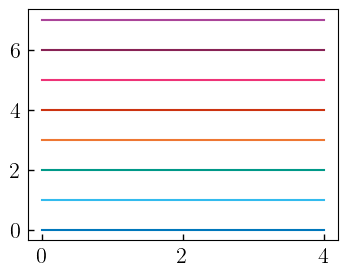

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap
from jax import grad
from jax import random as jran
import os
import h5py
import time

mred = u"#d62728"
morange = u"#ff7f0e"
mgreen = u"#2ca02c"
mblue = u"#1f77b4"
mpurple = u"#9467bd"
fact = 1.0
plt.rcParams["figure.figsize"] = (4*fact, 3*fact)
plt.rc('font', family="serif")
plt.rc('font', size=18)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']
for i, x in enumerate(colors):
    plt.plot(np.ones(5)*i, color=x)

# Define some basic quantities

In [24]:
from diffmah.individual_halo_assembly import _calc_halo_history
from diffstar.constants import TODAY
from diffstar.stars import fstar_tools
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value

# Define our cosmci time array to make some predictions
#t_table = np.linspace(0.1, TODAY, 100)
# t_table = np.logspace(-1, np.log10(TODAY), 100)

# t_table = np.linspace(1.0, TODAY, 20)
t_table = (TODAY - Planck13.lookback_time(np.arange(0,2.1,0.5)).value)[::-1]
t_table = np.concatenate((np.linspace(1.0, 3, 5), t_table))
t_table = np.clip(t_table, None, TODAY)
z_table = np.array([z_at_value(Planck13.age, x * u.Gyr, zmin=-1) for x in t_table])

t_sel_hists = np.argmin(np.subtract.outer(z_table, np.arange(0,2.1,0.5))**2, axis=0)[::-1]

print(t_table)
print(z_table)
lgt = np.log10(t_table)
# Define some mass bins for predictions
# logm0_binmids = np.linspace(11.5, 13.5, 5)
logm0_binmids = np.linspace(11.0, 14.5, 8)

# logm0_binmids = np.linspace(12.0, 12.5, 3)
logm0_bin_widths = np.ones_like(logm0_binmids) * 0.1


# Define some useful quantities and masks for later
fstar_tdelay = 1.0
index_select, index_high = fstar_tools(t_table, fstar_tdelay=fstar_tdelay)


sm_loss_weight = jnp.where(t_table>2.0, 1.0, 1e10)
fstar_loss_MS_weight = jnp.where(t_table[index_select]>2.0, 1.0, 1e10)
fstar_loss_Q_weight = jnp.where(t_table[index_select]>5.0, 1.0, 1e10)

sm_loss_sel = np.arange(len(t_table))[t_table>1.0]
fstar_loss_MS_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>2.0]
fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>5.0]


[ 1.          1.5         2.          2.5         3.          3.28815902
  4.28204677  5.86687427  8.60796997 13.8       ]
[ 5.67661227e+00  4.09192219e+00  3.19812061e+00  2.61161433e+00
  2.19131955e+00  1.99768476e+00  1.49849167e+00  9.99086320e-01
  4.99492499e-01 -2.57036385e-04]


/Users/alarcon/anaconda3/anaconda3/envs/diffpop/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1054: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(self._lookback_time_integrand_scalar, z, inf)[0]


# Generate some individual MAH histories with DiffmahPop

from diffmah.monte_carlo_halo_population import mc_halo_population
from diffstarpop.utils import get_t50_p50

Nhalos = 100
logmpeak_diffmahpop = []
mah_params_diffmahpop = []

log_mahs = np.zeros((len(logm0_binmids), Nhalos, len(t_table)))
for i, binmid in enumerate(logm0_binmids):
    _res = mc_halo_population(t_table, TODAY, binmid * np.ones(Nhalos))
    _mahparams = np.array([
        np.ones(Nhalos)*np.log10(TODAY),
        binmid * np.ones(Nhalos),
        _res.lgtc,
        np.ones(Nhalos)*3.5,
        _res.early_index,
        _res.late_index,
    ]).T
    
    logmpeak_diffmahpop.append(binmid * np.ones(Nhalos))
    mah_params_diffmahpop.append(_mahparams)
    
    log_mahs[i] = _res.log_mah
    

    
logmpeak_diffmahpop = np.concatenate(logmpeak_diffmahpop)
mah_params_diffmahpop = np.concatenate(mah_params_diffmahpop)
log_mahs_diffmahpop = np.concatenate(log_mahs)

halo_data_MC = mah_params_diffmahpop[:, np.array([1,2,4,5])].copy() # We only need logm, logtauc, early, late

t50, p50 = get_t50_p50(t_table, 10**log_mahs_diffmahpop, 0.5, log_mahs_diffmahpop[:,-1], window_length = 9)
#p50 = p50.reshape((len(logm0_binmids), N))

halo_data_MC_diffmahpop = halo_data_MC.copy()
p50_diffmahpop = p50.copy()

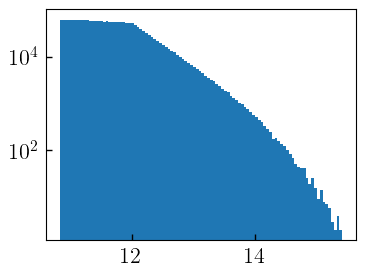

In [25]:
path = "/Users/alarcon/Documents/diffmah_data/SMDPL/"

mah_params_arr = np.load(path+"mah_params_arr_576_small.npy")
u_fit_params_arr = np.load(path+"u_fit_params_arr_576_small.npy")
fit_params_arr = np.load(path+"fit_params_arr_576_small.npy")
p50_arr = np.load(path+"p50_arr_576_small.npy")

logmpeak = mah_params_arr[:,1]

plt.hist(logmpeak, 100)
plt.yscale('log')
plt.show()

In [26]:
from diffsky.diffndhist import tw_ndhist, tw_ndhist_weighted

bins_mstar = jnp.linspace(7, 12, 25)
bins_ssfr = jnp.linspace(-13, -8.5, 25)
delta_bins_mstar = float(jnp.diff(bins_mstar)[0])
delta_bins_ssfr = float(jnp.diff(bins_ssfr)[0])

bins_LO = []
bins_HI = []
for i in range(len(bins_mstar)-1):
    for j in range(len(bins_ssfr)-1):
        bins_LO.append([bins_mstar[i], bins_ssfr[j]])
        bins_HI.append([bins_mstar[i+1], bins_ssfr[j+1]])
bins_LO = np.array(bins_LO)
bins_HI = np.array(bins_HI)
bins_LO.shape, bins_HI.shape


((576, 2), (576, 2))

In [27]:
from diffstarpop.monte_carlo_diff_halo_population import (
    sm_sfr_history_diffstar_scan_XsfhXmah_vmap,
    sm_sfr_history_diffstar_scan_MS_XsfhXmah_vmap,
    _jax_get_dt_array,
    calc_hist_mstar_ssfr,
)
def calculate_SMDPL_sumstats(
    t_table,
    logm0_binmids,
    logm0_bin_widths,
    mah_params, 
    fit_params, 
    p50,
    bins_LO, 
    bins_HI
):
    logmpeak = mah_params[:, 1]

    lgt = np.log10(t_table)

    fstar_tdelay = 1.0
    index_select, index_high = fstar_tools(t_table, fstar_tdelay=fstar_tdelay)
    dt = _jax_get_dt_array(t_table)

    stats = []
    for i in range(len(logm0_binmids)):

        print("Calculating m0=[%.2f, %.2f]"%(logm0_binmids[i] - logm0_bin_widths[i], logm0_binmids[i] + logm0_bin_widths[i]))
        sel = (logmpeak > logm0_binmids[i] - logm0_bin_widths[i]) & (logmpeak < logm0_binmids[i] + logm0_bin_widths[i])
        print("Nhalos:", sel.sum())
        _res = sm_sfr_history_diffstar_scan_XsfhXmah_vmap(
            t_table,
            lgt,
            dt,
            mah_params[sel][:, [1,2,4,5]],
            fit_params[sel][:,[0,1,2,4]].copy(),
            fit_params[sel][:,[5,6,7,8]].copy(),
            index_select,
            index_high,
            fstar_tdelay,
        )
        
        (
            mstar_histories,
            sfr_histories,
            fstar_histories,
        ) = _res
        
        ssfr = sfr_histories / mstar_histories
        weights_quench_bin = jnp.where(ssfr > 1e-11, 1.0, 0.0)
        
        n_histories = len(mstar_histories)
        ndsig = np.ones((n_histories, 2))
        ndsig[:,0] *= delta_bins_mstar
        ndsig[:,1] *= delta_bins_ssfr

        _stats = calculate_sumstats_bin(
            mstar_histories, 
            sfr_histories, 
            p50[sel], 
            weights_quench_bin,
            ndsig, bins_LO, bins_HI
        )
        stats.append(_stats)

    print("Reshaping results")
        
    new_stats = []
    nres = len(_stats)
    for j in range(nres):
        _new_stats = []
        for i in range(len(logm0_binmids)):
            _new_stats.append(stats[i][j])
        new_stats.append(np.array(_new_stats))


    # np.save("/Users/alarcon/Documents/diffmah_data/SMDPL_sfh_sumstats.npy", new_stats)
    return new_stats



def calculate_sumstats_bin(
    mstar_histories, sfr_histories, p50, weights_MS, ndsig, bins_LO, bins_HI
):

    weights_Q = 1.0 - weights_MS

    # Clip weights. When all weights in a time
    # step are 0, Nans will occur in gradients.
    eps = 1e-10
    weights_Q = jnp.clip(weights_Q, eps, None)
    weights_MS = jnp.clip(weights_MS, eps, None)

    weights_early = jnp.where(p50 < 0.5, 1.0, 0.0)
    weights_late = 1.0 - weights_early
    weights_early = jnp.clip(weights_early, eps, None)
    weights_late = jnp.clip(weights_late, eps, None)

    ssfr = sfr_histories / mstar_histories
    
    mstar_histories = jnp.where(mstar_histories > 0.0, jnp.log10(mstar_histories), 0.0)
    sfr_histories = jnp.where(sfr_histories > 0.0, jnp.log10(sfr_histories), 0.0)
    
    ssfr = jnp.where(ssfr > 0.0, jnp.log10(ssfr), -50.0)

    mean_sm = jnp.average(mstar_histories, axis=0)
    mean_sfr_MS = jnp.average(sfr_histories, weights=weights_MS, axis=0)
    mean_sfr_Q = jnp.average(sfr_histories, weights=weights_Q, axis=0)

    mean_sm_early = jnp.average(mstar_histories, weights=weights_early, axis=0)
    mean_sm_late = jnp.average(mstar_histories, weights=weights_late, axis=0)

    variance_sm = jnp.average(
        (mstar_histories - mean_sm[None, :]) ** 2, axis=0,
    )

    variance_sfr_MS = jnp.average(
        (sfr_histories - mean_sfr_MS[None, :]) ** 2, weights=weights_MS, axis=0,
    )
    variance_sfr_Q = jnp.average(
        (sfr_histories - mean_sfr_Q[None, :]) ** 2, weights=weights_Q, axis=0,
    )
    variance_sm_early = jnp.average(
        (mstar_histories - mean_sm[None, :]) ** 2, weights=weights_early, axis=0,
    )
    variance_sm_late = jnp.average(
        (mstar_histories - mean_sm[None, :]) ** 2, weights=weights_late, axis=0,
    )

    NHALO_MS = jnp.sum(weights_MS, axis=0)
    NHALO_Q = jnp.sum(weights_Q, axis=0)
    quench_frac = NHALO_Q / (NHALO_Q + NHALO_MS)

    mean_sfr_Q = jnp.where(quench_frac == 0.0, 0.0, mean_sfr_Q)
    variance_sfr_Q = jnp.where(quench_frac == 0.0, 0.0, variance_sfr_Q)
    mean_sfr_MS = jnp.where(quench_frac == 1.0, 0.0, mean_sfr_MS)
    variance_sfr_MS = jnp.where(quench_frac == 1.0, 0.0, variance_sfr_MS)

    NHALO_MS_early = jnp.sum(weights_MS * weights_early[:, None], axis=0)
    NHALO_Q_early = jnp.sum(weights_Q * weights_early[:, None], axis=0)
    quench_frac_early = NHALO_Q_early / (NHALO_Q_early + NHALO_MS_early)

    NHALO_MS_late = jnp.sum(weights_MS * weights_late[:, None], axis=0)
    NHALO_Q_late = jnp.sum(weights_Q * weights_late[:, None], axis=0)
    quench_frac_late = NHALO_Q_late / (NHALO_Q_late + NHALO_MS_late)
    
    
    """
    counts = np.zeros((len(t_table[t_sel_hists]), len(bins_mstar)-1, len(bins_mstar)-1))
    for i, tid in enumerate(t_sel_hists):
        _counts = np.histogram2d(mstar_histories[:,tid], ssfr[:,tid], bins=[bins_mstar, bins_ssfr])[0]
        # _counts = np.clip(_counts, 1e-10, None)
        _counts /= _counts.sum()
        counts[i] = _counts
        
    counts = counts.reshape(len(t_sel_hists), (len(bins_mstar)-1)*(len(bins_mstar)-1))
    """
    weight = jnp.ones(len(sfr_histories))
    counts = calc_hist_mstar_ssfr(
        mstar_histories.T[t_sel_hists], ssfr.T[t_sel_hists], ndsig, weight, bins_LO, bins_HI
    )

    _out = (
        mean_sm,
        variance_sm,
        mean_sfr_MS,
        mean_sfr_Q,
        variance_sfr_MS,
        variance_sfr_Q,
        quench_frac,
        mean_sm_early,
        mean_sm_late,
        variance_sm_early,
        variance_sm_late,
        quench_frac_early,
        quench_frac_late,
        counts,
    )
    return _out

MC_res_target = calculate_SMDPL_sumstats(
    t_table,
    logm0_binmids,
    logm0_bin_widths,
    mah_params_arr, 
    u_fit_params_arr, 
    p50_arr,
    bins_LO, 
    bins_HI
)

# MC_res_target = np.array(MC_res_target)

Calculating m0=[10.90, 11.10]
Nhalos: 264007
Calculating m0=[11.40, 11.60]
Nhalos: 251579
Calculating m0=[11.90, 12.10]
Nhalos: 221115
Calculating m0=[12.40, 12.60]
Nhalos: 81419
Calculating m0=[12.90, 13.10]
Nhalos: 27465
Calculating m0=[13.40, 13.60]
Nhalos: 8594
Calculating m0=[13.90, 14.10]
Nhalos: 2373
Calculating m0=[14.40, 14.60]
Nhalos: 474
Reshaping results


In [28]:

Nhalos = 3000
halo_data_MC = []
p50 = []
for i in range(len(logm0_binmids)):
    _sel = (logmpeak > logm0_binmids[i] - logm0_bin_widths[i]) & (logmpeak < logm0_binmids[i] + logm0_bin_widths[i])
    print(_sel.sum())
    replace = True if _sel.sum() < Nhalos else False
    sel = np.random.choice(np.arange(len(p50_arr))[_sel], Nhalos, replace=replace)
    halo_data_MC.append(mah_params_arr[sel])
    p50.append(p50_arr[sel])
halo_data_MC = np.concatenate(halo_data_MC, axis=0)[:, np.array([1,2,4,5])]
p50 = np.concatenate(p50, axis=0)


264007
251579
221115
81419
27465
8594
2373
474


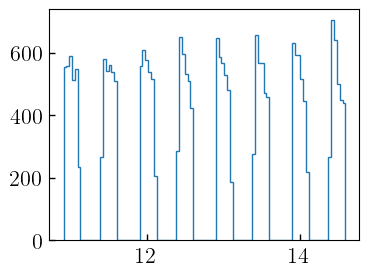

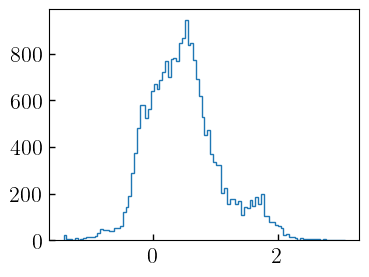

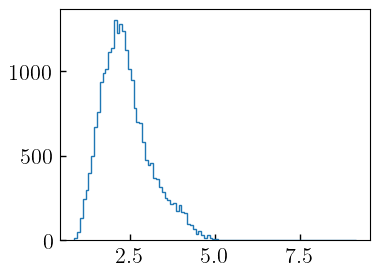

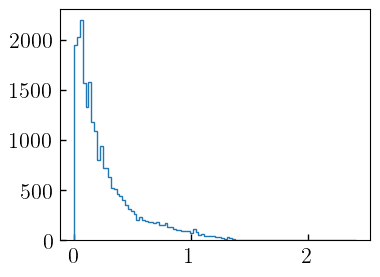

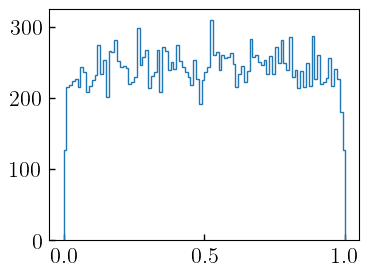

In [29]:
for i in range(4):
    # plt.hist(halo_data_MC_diffmahpop[:,i], 100, histtype='step')
    plt.hist(halo_data_MC[:,i], 100, histtype='step')
    plt.show()
    
plt.hist(p50, 100, histtype='step')
plt.show()

NameError: name 'log_mahs' is not defined

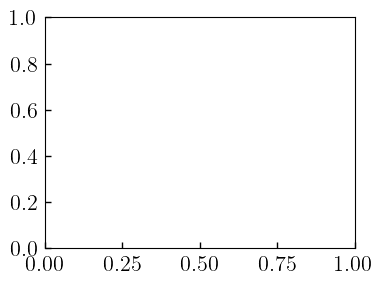

In [9]:
colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']
fig, ax = plt.subplots()

ax.plot(t_table, 10**log_mahs[0].T, colors[0], alpha=0.5)
ax.plot(t_table, 10**log_mahs[1].T, colors[2], alpha=0.5)
ax.plot(t_table, 10**log_mahs[2].T, colors[4], alpha=0.5)
ax.plot(t_table, 10**log_mahs[3].T, colors[5], alpha=0.5)
ax.plot(t_table, 10**log_mahs[4].T, colors[6], alpha=0.5)
ax.set_yscale('log')
ax.set_ylim(1e9, 1e14)
ax.set_xlim(0, TODAY)
ax.set_xlabel('Cosmic time [Gyr]')
ax.set_ylabel(r'$M_{\rm halo} [M_\odot]$')
ax.set_title("DiffmahPop histories")

legend_elements = [
    Line2D([0], [0], color=colors[0], label=r'$\log M_0 = %.1f$'%logm0_binmids[0]),
    Line2D([0], [0], color=colors[2], label=r'$\log M_0 = %.1f$'%logm0_binmids[1]),
    Line2D([0], [0], color=colors[4], label=r'$\log M_0 = %.1f$'%logm0_binmids[2]),
    Line2D([0], [0], color=colors[5], label=r'$\log M_0 = %.1f$'%logm0_binmids[3]),
    Line2D([0], [0], color=colors[6], label=r'$\log M_0 = %.1f$'%logm0_binmids[4]),
]
ax.legend(handles=legend_elements, loc=2, bbox_to_anchor=(1,1,))

plt.show()

### Get the default DiffstarPOP parameters for quenched and main sequence populations

In [9]:
from diffstarpop.pdf_quenched import DEFAULT_SFH_PDF_QUENCH_PARAMS
from diffstarpop.pdf_mainseq import DEFAULT_SFH_PDF_MAINSEQ_PARAMS

DEFAULT_SFH_PDF_QUENCH_PARAMS, DEFAULT_SFH_PDF_MAINSEQ_PARAMS

(OrderedDict([('frac_quench_x0', 11.86),
              ('frac_quench_k', 1.611),
              ('frac_quench_ylo', -0.872),
              ('frac_quench_yhi', 2.139),
              ('mean_ulgm_quench_ylo', 11.54),
              ('mean_ulgm_quench_yhi', 12.08),
              ('mean_ulgy_quench_ylo', 0.481),
              ('mean_ulgy_quench_yhi', -0.223),
              ('mean_ul_quench_ylo', -1.274),
              ('mean_ul_quench_yhi', 1.766),
              ('mean_utau_quench_ylo', 55.48),
              ('mean_utau_quench_yhi', -66.54),
              ('mean_uqt_quench_ylo', 1.744),
              ('mean_uqt_quench_yhi', 0.042),
              ('mean_uqs_quench_ylo', -2.979),
              ('mean_uqs_quench_yhi', 3.52),
              ('mean_udrop_quench_ylo', -0.508),
              ('mean_udrop_quench_yhi', -3.785),
              ('mean_urej_quench_ylo', 2.139),
              ('mean_urej_quench_yhi', -3.043),
              ('chol_ulgm_ulgm_quench_ylo', -1.645),
              ('chol_ulgm_ulg

### Get the default DiffstarPOP assembly bias parameters

In [10]:
from diffstarpop.pdf_model_assembly_bias_shifts import DEFAULT_R_MAINSEQ_PARAMS, DEFAULT_R_QUENCH_PARAMS

DEFAULT_R_MAINSEQ_PARAMS, DEFAULT_R_QUENCH_PARAMS

(OrderedDict([('R_ulgm_mainseq_ylo', -0.558),
              ('R_ulgm_mainseq_yhi', 0.575),
              ('R_ulgy_mainseq_ylo', -1.227),
              ('R_ulgy_mainseq_yhi', 2.171),
              ('R_ul_mainseq_ylo', 5.164),
              ('R_ul_mainseq_yhi', -3.384),
              ('R_utau_mainseq_ylo', 5.828),
              ('R_utau_mainseq_yhi', -5.587)]),
 OrderedDict([('R_Fquench', 0.994),
              ('R_ulgm_quench_ylo', -1.264),
              ('R_ulgm_quench_yhi', 0.44),
              ('R_ulgy_quench_ylo', -0.165),
              ('R_ulgy_quench_yhi', -1.083),
              ('R_ul_quench_ylo', 5.653),
              ('R_ul_quench_yhi', -4.126),
              ('R_utau_quench_ylo', 5.613),
              ('R_utau_quench_yhi', -6.922),
              ('R_uqt_quench_ylo', 0.19),
              ('R_uqt_quench_yhi', 0.191),
              ('R_uqs_quench_ylo', 2.124),
              ('R_uqs_quench_yhi', -2.699),
              ('R_udrop_quench_ylo', 1.071),
              ('R_udrop_quench_yh

# Draw individual SFH histories 


In [11]:
from diffstarpop.monte_carlo_diff_halo_population import (
    draw_sfh_Q_vmap,
    draw_sfh_MS_vmap,
    draw_sfh_MIX_vmap,
    draw_sfh_MIX,
)


In [12]:
def dict_to_array(dictionary):
    return np.array(list(dictionary.values()))

In [12]:
n_histories = int(1e3)
ran_key = jran.PRNGKey(0)

t0 = time.time()
histories = draw_sfh_MIX_vmap(
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    dict_to_array(DEFAULT_SFH_PDF_QUENCH_PARAMS),
    dict_to_array(DEFAULT_SFH_PDF_MAINSEQ_PARAMS),
    dict_to_array(DEFAULT_R_QUENCH_PARAMS),
    dict_to_array(DEFAULT_R_MAINSEQ_PARAMS),
)
t1 = time.time()
print(t1-t0)

3.59211802482605


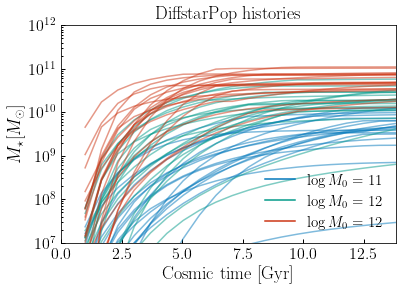

In [15]:
fig, ax = plt.subplots()

choice = np.random.choice(len(histories[0][0]), 20, replace=False)

ax.plot(t_table, histories[0][0][choice].T, colors[0], alpha=0.5)
ax.plot(t_table, histories[0][1][choice].T, colors[2], alpha=0.5)
ax.plot(t_table, histories[0][2][choice].T, colors[4], alpha=0.5)
ax.set_yscale('log')
ax.set_ylim(1e7, 1e12)
ax.set_xlim(0, TODAY)
ax.set_xlabel('Cosmic time [Gyr]')
ax.set_ylabel(r'$M_{\rm \star} [M_\odot]$')
ax.set_title("DiffstarPop histories")

legend_elements = [
    Line2D([0], [0], color=colors[0], label=r'$\log M_0 = %d$'%logm0_binmids[0]),
    Line2D([0], [0], color=colors[2], label=r'$\log M_0 = %d$'%logm0_binmids[1]),
    Line2D([0], [0], color=colors[4], label=r'$\log M_0 = %d$'%logm0_binmids[2]),
]
ax.legend(handles=legend_elements, loc=0)

plt.show()

# Calculate first and second order moments of Mstar, SFH with DiffstarPop drawing individual SFH histories


### Compare the calculations between two different `diffstar` kernel implementations using `vmap` or `scan` 

In [13]:
from diffstarpop.monte_carlo_diff_halo_population import (
    sumstats_sfh_Q_vmap,
    sumstats_sfh_MS_vmap,
    sumstats_sfh_MIX_vmap,
    sumstats_sfh_MIX_p50_vmap,
    sumstats_sfh_with_hists_vmap,
)


In [14]:


N_PDF_Q = len(DEFAULT_SFH_PDF_QUENCH_PARAMS)
N_PDF_MS = len(DEFAULT_SFH_PDF_MAINSEQ_PARAMS)
N_R_Q = len(DEFAULT_R_QUENCH_PARAMS)
N_R_MS = len(DEFAULT_R_MAINSEQ_PARAMS)

n_histories = int(1e3)
ndsig = np.ones((2*n_histories, 2))
ndsig[:,0] *= delta_bins_mstar
ndsig[:,1] *= delta_bins_ssfr

_loss_data = (
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    index_select,
    index_high,
    fstar_tdelay,
    ndsig,
    bins_LO,
    bins_HI,
    MC_res_target
)

"""
init_guess = np.concatenate((
    dict_to_array(DEFAULT_SFH_PDF_QUENCH_PARAMS),
    dict_to_array(DEFAULT_SFH_PDF_MAINSEQ_PARAMS),
    dict_to_array(DEFAULT_R_QUENCH_PARAMS),
    dict_to_array(DEFAULT_R_MAINSEQ_PARAMS),
))
"""
init_guess = outputs[0].copy()



NameError: name 'outputs' is not defined

In [220]:

n_histories = int(1e4)
ran_key = jran.PRNGKey(0)

t0 = time.time()
MC_res_init_guess = sumstats_sfh_MIX_p50_vmap(
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    # halo_data_MC_diffmahpop.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    init_guess[0:N_PDF_Q],
    init_guess[N_PDF_Q:N_PDF_Q+N_PDF_MS],
    init_guess[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
    init_guess[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
)
t1 = time.time()
print(t1-t0)

2.6680119037628174


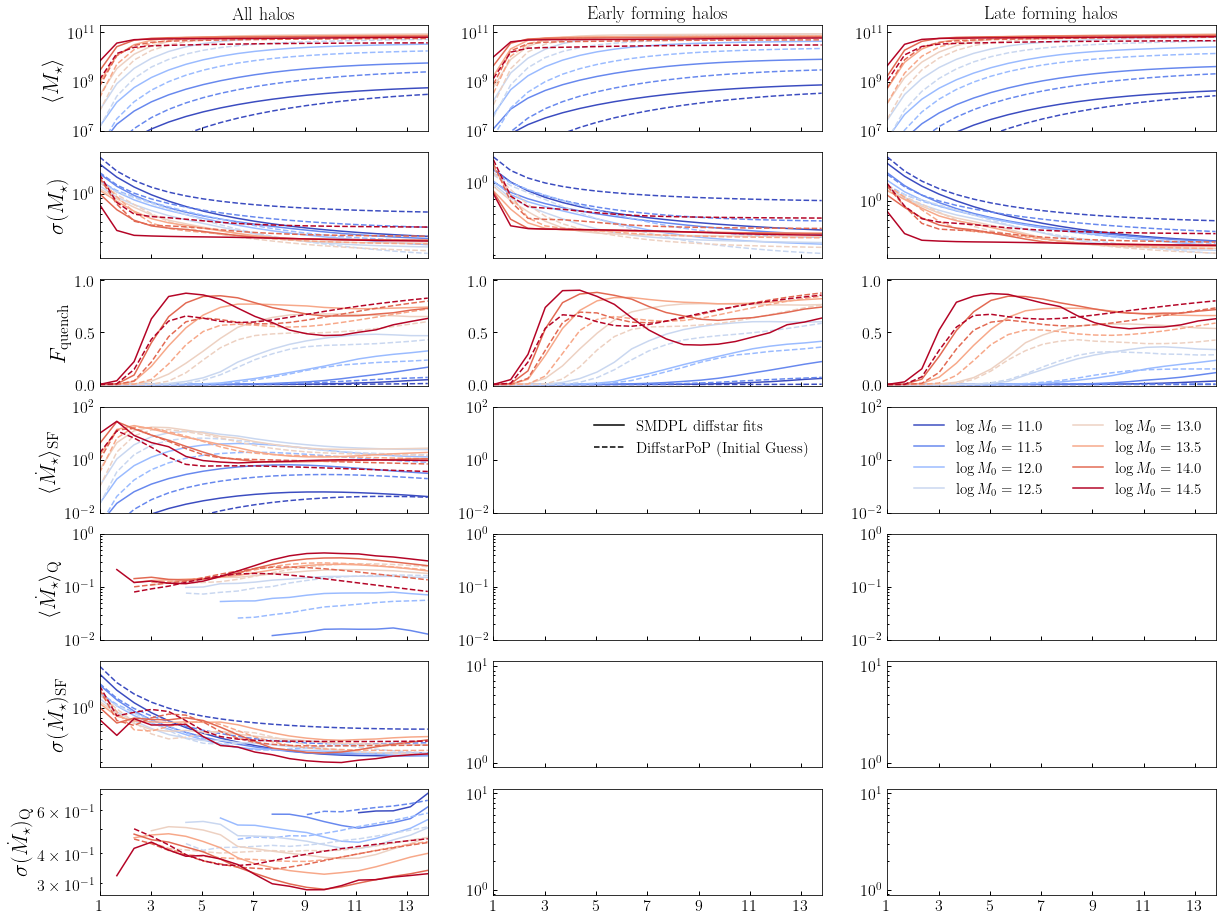

In [221]:
NM0 = len(logm0_binmids)
colors = plt.get_cmap("viridis")(np.linspace(0,1,NM0))
colors = plt.get_cmap("coolwarm")(np.linspace(0,1,NM0))

fontsize = 22
fig, ax = plt.subplots(7,3, figsize=(20,16), sharex=True, sharey=False)

lw = 1.5

for i in range(NM0):    
    
    ax[0,0].plot(t_table, 10**MC_res_target[0][i], ls="-", color=colors[i])
    ax[0,1].plot(t_table, 10**MC_res_target[7][i], ls="-", color=colors[i])
    ax[0,2].plot(t_table, 10**MC_res_target[8][i], ls="-", color=colors[i])
    
    ax[1,0].plot(t_table, np.sqrt(MC_res_target[1][i]), ls="-", color=colors[i])
    ax[1,1].plot(t_table, np.sqrt(MC_res_target[9][i]), ls="-", color=colors[i])
    ax[1,2].plot(t_table, np.sqrt(MC_res_target[10][i]), ls="-", color=colors[i])
    
    ax[2,0].plot(t_table, MC_res_target[6][i], ls="-", color=colors[i])
    ax[2,1].plot(t_table, MC_res_target[11][i], ls="-", color=colors[i])
    ax[2,2].plot(t_table, MC_res_target[12][i], ls="-", color=colors[i])

    mskQ = np.array(MC_res_target[6][i] > 0.01)
    mskSF = np.array(MC_res_target[6][i] < 0.99)
    ax[3,0].plot(t_table[mskSF], 10**MC_res_target[2][i][mskSF], ls="-", color=colors[i])
    ax[4,0].plot(t_table[mskQ], 10**MC_res_target[3][i][mskQ], ls="-", color=colors[i])

    ax[5,0].plot(t_table[mskSF], np.sqrt(MC_res_target[4][i])[mskSF], ls="-", color=colors[i])
    ax[6,0].plot(t_table[mskQ], np.sqrt(MC_res_target[5][i])[mskQ], ls="-", color=colors[i])
    
    ################################
    
    ax[0,0].plot(t_table, 10**MC_res_init_guess[0][i], ls="--", color=colors[i], lw=lw)
    ax[0,1].plot(t_table, 10**MC_res_init_guess[7][i], ls="--", color=colors[i], lw=lw)
    ax[0,2].plot(t_table, 10**MC_res_init_guess[8][i], ls="--", color=colors[i], lw=lw)
    
    ax[1,0].plot(t_table, np.sqrt(MC_res_init_guess[1][i]), ls="--", color=colors[i], lw=lw)
    ax[1,1].plot(t_table, np.sqrt(MC_res_init_guess[9][i]), ls="--", color=colors[i], lw=lw)
    ax[1,2].plot(t_table, np.sqrt(MC_res_init_guess[10][i]), ls="--", color=colors[i], lw=lw)
    
    ax[2,0].plot(t_table, MC_res_init_guess[6][i], ls="--", color=colors[i], lw=lw)
    ax[2,1].plot(t_table, MC_res_init_guess[11][i], ls="--", color=colors[i], lw=lw)
    ax[2,2].plot(t_table, MC_res_init_guess[12][i], ls="--", color=colors[i], lw=lw)

    mskQ = np.array(MC_res_init_guess[6][i] > 0.01)
    mskSF = np.array(MC_res_init_guess[6][i] < 0.99)
    ax[3,0].plot(t_table[mskSF], 10**MC_res_init_guess[2][i][mskSF], ls="--", color=colors[i], lw=lw)
    ax[4,0].plot(t_table[mskQ], 10**MC_res_init_guess[3][i][mskQ], ls="--", color=colors[i], lw=lw)

    ax[5,0].plot(t_table[mskSF], np.sqrt(MC_res_init_guess[4][i])[mskSF], ls="--", color=colors[i], lw=lw)
    ax[6,0].plot(t_table[mskQ], np.sqrt(MC_res_init_guess[5][i])[mskQ], ls="--", color=colors[i], lw=lw)

ax[0,0].set_title("All halos")
ax[0,1].set_title("Early forming halos")
ax[0,2].set_title("Late forming halos")

ax[0,0].set_ylabel(r'$\langle M_\star\rangle$', fontsize=fontsize)
ax[1,0].set_ylabel(r'$\sigma( M_\star)$', fontsize=fontsize)
ax[2,0].set_ylabel(r'$F_{\rm quench}$', fontsize=fontsize)
ax[3,0].set_ylabel(r'$\langle \dot{M}_\star\rangle_{\rm{SF}}$', fontsize=fontsize)
ax[4,0].set_ylabel(r'$\langle \dot{M}_\star\rangle_{\rm{Q}}$', fontsize=fontsize)
ax[5,0].set_ylabel(r'$\sigma( \dot{M}_\star)_{\rm{SF}}$', fontsize=fontsize)
ax[6,0].set_ylabel(r'$\sigma( \dot{M}_\star)_{\rm{Q}}$', fontsize=fontsize)

for i in range(3):
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 2e11)
    ax[2,i].set_ylim(-0.01,1.01)
    ax[3,i].set_yscale('log')
    ax[4,i].set_yscale('log')
    ax[3,i].set_ylim(1e-2, 1e2)
    ax[4,i].set_ylim(1e-2, 1e0)
    ax[5,i].set_yscale('log')
    ax[6,i].set_yscale('log')
    
ax[0,0].set_xlim(1.0, TODAY)
ax[0,0].set_xticks(np.arange(1,13.1,2))

legend_elements = [
    Line2D([0], [0], color=colors[i], label=r'$\log M_0 = %.1f$'%logm0_binmids[i])
    for i in range(NM0)
]
ax[3,2].legend(handles=legend_elements, loc=1, ncol=2)

legend_elements = [
    Line2D([0], [0], color='k', ls='-', label=r"SMDPL diffstar fits"),
    Line2D([0], [0], color='k', ls='--', label=r"DiffstarPoP (Initial Guess)"),
]
ax[3,1].legend(handles=legend_elements, loc=1, ncol=1)

#plt.savefig("SMDPL_diffstarpop_sumstats_initialguess.png", bbox_inches='tight', dpi=300)
# plt.savefig("SMDPL_diffstarpop_sumstats_extrapol.png", bbox_inches='tight', dpi=300)

plt.show()

In [21]:
for i, x in enumerate(MC_res_target):
    print(i, x.shape)

0 (7, 10)
1 (7, 10)
2 (7, 10)
3 (7, 10)
4 (7, 10)
5 (7, 10)
6 (7, 10)
7 (7, 10)
8 (7, 10)
9 (7, 10)
10 (7, 10)
11 (7, 10)
12 (7, 10)
13 (7, 10, 576)


In [20]:
bins_LO.shape

(576, 2)

In [15]:
from diffstarpop.monte_carlo_diff_halo_population import sumstats_sfh_with_hists
from functools import partial
from jax import lax

from diffstarpop.fit_pop_helpers import *
from functools import partial
from diffstarpop.monte_carlo_diff_halo_population import (
    _tw_cuml_lax_kern_vmap,
    compute_sumstats_MIX_p50,
    calc_hist_mstar_ssfr,
)



In [16]:
from diffstarpop.fit_pop_helpers import (
    loss_p50, loss_p50_deriv, loss_p50_deriv_np,
    loss_hists, loss_hists_deriv, loss_hists_deriv_np,
    loss_hists_vmap, loss_hists_vmap_deriv, loss_hists_vmap_deriv_np,
)
# from diffstarpop.utils import minimizer, minimize


In [17]:
from diffstarpop.fit_pop_helpers import *
from functools import partial
@partial(jjit, static_argnames=["n_histories"])
def loss_hists_vmap(params, loss_data, n_histories, ran_key):
    (
        t_table,
        logm0_binmids,
        halo_data,
        p50,
        index_select,
        index_high,
        sfr_tdelay,
        ndsig,
        bins_LO,
        bins_HI,
        t_sel_hists,
        target_data,
        # target_data_weights,
    ) = loss_data
    (
        mean_sm_target,
        variance_sm_target,
        mean_sfr_MS_target,
        mean_sfr_Q_target,
        variance_sfr_MS_target,
        variance_sfr_Q_target,
        quench_frac_target,
        mean_sm_early_target,
        mean_sm_late_target,
        variance_sm_early_target,
        variance_sm_late_target,
        quench_frac_early_target,
        quench_frac_late_target,
        counts_target,
    ) = target_data

    _npar = 0
    pdf_q_params = params[_npar : _npar + N_PDF_Q]
    _npar += N_PDF_Q
    pdf_ms_params = params[_npar : _npar + N_PDF_MS]
    _npar += N_PDF_MS
    r_q_params = params[_npar : _npar + N_R_Q]
    _npar += N_R_Q
    r_ms_params = params[_npar : _npar + N_R_MS]

    _res = sumstats_sfh_with_hists_vmap(
        t_table,
        logm0_binmids,
        halo_data,
        p50,
        n_histories,
        ran_key,
        index_select,
        index_high,
        sfr_tdelay,
        ndsig,
        bins_LO,
        bins_HI,
        t_sel_hists,
        pdf_q_params,
        pdf_ms_params,
        r_q_params,
        r_ms_params,
    )
    (
        mean_sm,
        variance_sm,
        mean_sfr_MS,
        mean_sfr_Q,
        variance_sfr_MS,
        variance_sfr_Q,
        quench_frac,
        mean_sm_early,
        mean_sm_late,
        variance_sm_early,
        variance_sm_late,
        quench_frac_early,
        quench_frac_late,
        counts,
    ) = _res

    wQ = jnp.where(quench_frac_target > 0.01, 1.0, 0.0)
    wSF = jnp.where(quench_frac_target < 0.99, 1.0, 0.0)
    
    loss = mse(mean_sm, mean_sm_target)
    loss += mse(mean_sm_early, mean_sm_early_target)
    loss += mse(mean_sm_late, mean_sm_late_target)
    """
    loss += mse_var(variance_sm, variance_sm_target)
    loss += msew(mean_sfr_MS, mean_sfr_MS_target, wSF)
    loss += msew(mean_sfr_Q, mean_sfr_Q_target, wQ)
    loss += msew_var(variance_sfr_MS, variance_sfr_MS_target, wSF)
    loss += msew_var(variance_sfr_Q, variance_sfr_Q_target, wQ)
    loss += mse(quench_frac, quench_frac_target)

    loss += mse_var(variance_sm_early, variance_sm_early_target)
    loss += mse_var(variance_sm_late, variance_sm_late_target)
    loss += mse(quench_frac_early, quench_frac_early_target)
    loss += mse(quench_frac_late, quench_frac_late_target)
    """
    loss += 1e4 * mse(counts, counts_target)
    #loss += (1.0 / 20.0) * mse_arch(counts, counts_target)

    return loss

loss_hists_vmap_deriv = jjit(
    grad(loss_hists_vmap, argnums=(0)), static_argnames=["n_histories"]
)


def loss_hists_vmap_deriv_np(params, data, n_histories, ran_key):
    return np.array(loss_hists_vmap_deriv(params, data, n_histories, ran_key)).astype(
        float
    )

In [18]:

from diffstarpop.json_utils import load_params, write_params_json, print_all_default_dicts
path_json = "/Users/alarcon/Documents/source/diffstarpop/diffstarpop/bestfit_diffstarpop_params_UM_hists_v4.json"
outputs = load_params(path_json)




In [30]:
ran_key = jran.PRNGKey(np.random.randint(2**32))
n_histories = int(1e3)

N_PDF_Q = len(DEFAULT_SFH_PDF_QUENCH_PARAMS)
N_PDF_MS = len(DEFAULT_SFH_PDF_MAINSEQ_PARAMS)
N_R_Q = len(DEFAULT_R_QUENCH_PARAMS)
N_R_MS = len(DEFAULT_R_MAINSEQ_PARAMS)

ndsig = np.ones((2*n_histories, 2))
ndsig[:,0] *= delta_bins_mstar
ndsig[:,1] *= delta_bins_ssfr



_loss_data = (
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    index_select,
    index_high,
    fstar_tdelay,
    ndsig,
    bins_LO,
    bins_HI,
    t_sel_hists,
    MC_res_target
)

"""
init_guess = np.concatenate((
    dict_to_array(DEFAULT_SFH_PDF_QUENCH_PARAMS),
    dict_to_array(DEFAULT_SFH_PDF_MAINSEQ_PARAMS),
    dict_to_array(DEFAULT_R_QUENCH_PARAMS),
    dict_to_array(DEFAULT_R_MAINSEQ_PARAMS),
))
"""
init_guess = outputs[0].copy()


"""
# loss_hists(p, _loss_data, n_histories, ran_key)
t0 = time.time()
print(loss_hists_scan(init_guess.copy(), _loss_data, n_histories, ran_key))
t1 = time.time()
print("loss scan", t1-t0)

t0 = time.time()
print(loss_hists_scan_deriv_np(init_guess.copy(), _loss_data, n_histories, ran_key))
t1 = time.time()
print("grad scan", t1-t0)

"""
t0 = time.time()
print(loss_hists_vmap(init_guess.copy(), _loss_data, n_histories, ran_key))
t1 = time.time()
print("loss vmap", t1-t0)

t0 = time.time()
print(loss_hists_vmap_deriv_np(init_guess.copy(), _loss_data, n_histories, ran_key))
t1 = time.time()
print("grad vmap", t1-t0)


0.05762471
loss vmap 3.7513129711151123
[ 1.54076694e-02  1.21341273e-03 -5.05865319e-03 -2.97497073e-03
  9.37142223e-03  2.06895526e-02  6.73887581e-02  1.12774611e-01
 -1.17515530e-02 -2.00105440e-02 -1.04606501e-03 -2.64766812e-03
  1.85554385e-01  3.24381828e-01 -1.05732959e-02 -1.89596657e-02
 -8.99681170e-03 -1.52507843e-02 -9.76825692e-03 -1.94179267e-02
 -5.96048683e-03 -1.06672999e-02 -5.14640510e-02 -8.70174319e-02
 -3.43984887e-02 -5.30808046e-02 -8.50343406e-02 -1.39043421e-01
 -6.43127784e-03 -1.02634635e-02  3.47307418e-03  6.94540888e-03
 -4.38611861e-03 -8.54940061e-03 -2.19562463e-03 -5.32376487e-03
 -1.39782482e-04 -2.13148902e-04 -2.21431779e-04 -4.03858954e-04
 -7.19247852e-04 -1.22408243e-03  7.27031147e-04  1.08290906e-03
 -5.12925908e-03 -7.95091689e-03  1.30072795e-02  2.07749940e-02
 -6.99042139e-05 -5.28784985e-05  5.51762292e-04  1.11452828e-03
  7.56086200e-04  1.55147573e-03 -1.55409500e-02 -2.53190100e-02
 -1.44730497e-04 -2.97612860e-04  2.12370884e-04  

In [20]:
from jax.example_libraries import optimizers as jax_opt

In [31]:
n_histories = int(1e3)
# n_histories = int(1e4)
n_step = int(1e4)
step_size=0.01


N_PDF_Q = len(DEFAULT_SFH_PDF_QUENCH_PARAMS)
N_PDF_MS = len(DEFAULT_SFH_PDF_MAINSEQ_PARAMS)
N_R_Q = len(DEFAULT_R_QUENCH_PARAMS)
N_R_MS = len(DEFAULT_R_MAINSEQ_PARAMS)

ndsig = np.ones((2*n_histories, 2))
ndsig[:,0] *= delta_bins_mstar
ndsig[:,1] *= delta_bins_ssfr

_loss_data = (
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    index_select,
    index_high,
    fstar_tdelay,
    ndsig,
    bins_LO,
    bins_HI,
    t_sel_hists,
    MC_res_target
)
"""
init_guess = np.concatenate((
    dict_to_array(DEFAULT_SFH_PDF_QUENCH_PARAMS),
    dict_to_array(DEFAULT_SFH_PDF_MAINSEQ_PARAMS),
    dict_to_array(DEFAULT_R_QUENCH_PARAMS),
    dict_to_array(DEFAULT_R_MAINSEQ_PARAMS),
))
"""
init_guess = outputs[0].copy()




params_init = init_guess.copy()
ran_key = jran.PRNGKey(np.random.randint(2**32))

loss_arr = np.zeros(n_step).astype("f4") + np.inf

opt_init, opt_update, get_params = jax_opt.adam(step_size)
opt_state = opt_init(params_init)

n_params = len(params_init)
params_arr = np.zeros((n_step, n_params)).astype("f4")

n_mah = 100
sampled_mahs_inds_arr = np.zeros((n_step, n_histories))
no_nan_grads_arr = np.zeros(n_step)
for istep in range(n_step):
    t0 = time.time()
    ran_key, subkey = jran.split(ran_key, 2)

    p = np.array(get_params(opt_state))

    loss = loss_hists_vmap(p, _loss_data, n_histories, ran_key)
    grads = loss_hists_vmap_deriv(p, _loss_data, n_histories, ran_key)
    
    no_nan_params = np.all(np.isfinite(p))
    no_nan_loss = np.isfinite(loss)
    no_nan_grads = np.all(np.isfinite(grads))
    if ~no_nan_params | ~no_nan_loss | ~no_nan_grads:
        # break
        if istep > 0:
            indx_best = np.nanargmin(loss_arr[:istep])
            best_fit_params = params_arr[indx_best]
            best_fit_loss = loss_arr[indx_best]
        else:
            best_fit_params = np.copy(p)
            best_fit_loss = 999.99
    else:
        params_arr[istep, :] = p
        loss_arr[istep] = loss
        opt_state = opt_update(istep, grads, opt_state)
        
    keys = jran.split(ran_key, 5)
    

    sampled_mahs_inds = jran.choice(
        keys[0], n_mah, shape=(n_histories,), replace=True
    )
    sampled_mahs_inds_arr[istep] = sampled_mahs_inds
    no_nan_grads_arr[istep] = ~no_nan_grads
    t1 = time.time()
    print(istep, loss, t1-t0, no_nan_grads)
    if ~no_nan_grads:
        break
"""
indx_best = np.nanargmin(loss_arr)
best_fit_params = params_arr[indx_best]
loss = loss_arr[indx_best]
"""


0 0.055456102 4.393955945968628 True
1 0.045228895 4.209478855133057 True
2 0.039603475 4.157081127166748 True
3 0.03720572 4.106820821762085 True
4 0.032283522 3.9963676929473877 True
5 0.036866214 4.099852800369263 True
6 0.04098108 4.074245929718018 True
7 0.04031676 3.917466878890991 True
8 0.032479726 4.01202917098999 True
9 0.028635882 4.113484144210815 True
10 0.026072975 4.666985034942627 True
11 0.028409867 4.590719938278198 True
12 0.02647895 4.122976779937744 True
13 0.028701918 4.407819986343384 True
14 0.030793864 4.25906777381897 True
15 0.026963495 4.149770975112915 True
16 0.02937759 4.08705997467041 True
17 0.02340042 4.174888849258423 True
18 0.022339422 4.14766001701355 True
19 0.021724086 4.164618015289307 True
20 0.026592297 4.366177797317505 True
21 0.022698518 4.026026964187622 True
22 0.022236025 4.015721082687378 True
23 0.02353075 4.122041940689087 True
24 0.021376904 4.045164108276367 True
25 0.025707278 4.122876882553101 True
26 0.02167333 4.132205963134766 

KeyboardInterrupt: 

In [21]:
@partial(jjit, static_argnames=["n_histories"])
def _fun(
    params,
    data,
    n_histories,
    ran_key
):
    (
        t_table,
        logmh,
        mah_params,
        p50,
        index_select,
        index_high,
        fstar_tdelay,
    ) = data
    _npar = 0
    pdf_q_params = params[_npar : _npar + N_PDF_Q]
    _npar += N_PDF_Q
    pdf_ms_params = params[_npar : _npar + N_PDF_MS]
    _npar += N_PDF_MS
    r_q_params = params[_npar : _npar + N_R_Q]
    _npar += N_R_Q
    r_ms_params = params[_npar : _npar + N_R_MS]
    mstar, sfr, fstar, p50_sampled, weight = draw_sfh_MIX(
            t_table,
            logmh,
            mah_params,
            p50,
            n_histories,
            ran_key,
            index_select,
            index_high,
            fstar_tdelay,
            pdf_q_params,
            pdf_ms_params,
            r_q_params,
            r_ms_params,
        )
    return (jnp.mean(jnp.log10(mstar)) - 10.0)**2

_fun_deriv = jjit(grad(_fun, argnums=(0)), static_argnames=["n_histories"])


In [22]:
bin_id = 4
_data_test = (
    t_table,
    logm0_binmids[bin_id],
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id],
    p50.reshape(len(logm0_binmids),Nhalos)[bin_id],
    index_select,
    index_high,
    fstar_tdelay
)

print(_fun(p, _data_test, n_histories, ran_key))
print(_fun_deriv(p, _data_test, n_histories, ran_key))

4.663771
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  1.4750719e-02  8.0536216e-01 -5.3058136e-01 -5.3058136e-01
  5.6052095e-01  5.6052095e-01  2.2070570e-02  2.2070570e-02
 -4.6800885e-01 -4.6800885e-01  7.5474508e-02  7.5474508e-02
 -1.0555073e-02 -1.0555073e-02 -2.1638265e-03 -2.1638265e-03
  5.0434833e-03  5.0434833e-03  2.8283620e-01  2.8283620e-01
  4.0386230e-01  4.0386230e-01  3.6153194e-01  3.6153194e-01
  1.7972542e-02  1.7972542e-02  2.0293411e-02  2.0293411e-02
  1.6204685e-03  1.6204685e-03 -2.5368198e-03 -2.5368198e-03
 -6.3821753e-06 -6.3821753e-06 -2.7904299e-03 -2.7904299e-03
  1.7450863e-02  1.7450863e-02 -2.6525154e-03 -2.6525154e-03
  1.8877944e-02  1.8877944e-02 -4.3963246e-02 -4.3963246e-02
  3.0962742e-04  3.0962742e-04 -1.5239820e-03 -1.5239820e-03
  8.6327892e-04  8.6327892e-04  1.4648287e-02  1.4648287e-02
 -2.2391840e-04 -2.2391840e-04  1.7503359e-03  1.7503359e-03
 -8.0975576e-04 -8.0975576e-04 -4.5573030e-02 -4.5573030e-02
 -1.0594869e-04

In [34]:
@jjit
def _fun(arr, param):
    arr = jnp.where(arr+param > 0.0, jnp.log10(arr + param), 0.0)
    return jnp.mean(arr)

_t = jnp.linspace(-5.,5., 100)
_fun_deriv = jjit(vmap(grad(_fun, argnums=(1)),in_axes=(0,None)))
_fun(_t, 0.), _fun_deriv(_t, 5.)

(Array(0.13602169, dtype=float32),
 Array([       nan, 4.2995057 , 2.1497579 , 1.4331731 , 1.0748789 ,
        0.8599028 , 0.716586  , 0.6142163 , 0.53743947, 0.47772387,
        0.42995158, 0.390865  , 0.3582929 , 0.33073193, 0.30710816,
        0.28663436, 0.2687197 , 0.25291267, 0.23886196, 0.22629029,
        0.21497574, 0.20473883, 0.19543251, 0.18693545, 0.17914645,
        0.1719806 , 0.16536596, 0.15924132, 0.15355411, 0.14825915,
        0.14331718, 0.13869403, 0.13435985, 0.13028835, 0.12645634,
        0.1228433 , 0.11943098, 0.11620311, 0.11314514, 0.11024398,
        0.10748789, 0.10486622, 0.10236941, 0.09998873, 0.09771626,
        0.09554479, 0.09346773, 0.09147905, 0.08957323, 0.08774521,
        0.0859903 , 0.08430422, 0.08268298, 0.08112293, 0.07962065,
        0.078173  , 0.07677706, 0.0754301 , 0.07412957, 0.07287315,
        0.07165859, 0.07048386, 0.06934702, 0.06824628, 0.06717993,
        0.06614639, 0.06514417, 0.06417187, 0.06322817, 0.06231181,
        0.061

In [84]:
bin_id = 4

for i in range(Nhalos):
    _data_test = (
        t_table,
        logm0_binmids[bin_id],
        halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id,i].reshape(1,4),
        np.atleast_1d(p50.reshape(len(logm0_binmids),Nhalos)[bin_id,i]),
        index_select,
        index_high,
        fstar_tdelay
    )

    print(
        i, 
        _fun(p, _data_test, n_histories, ran_key), 
        np.isfinite(_fun_deriv(p, _data_test, n_histories, ran_key)).all()
    )


KeyboardInterrupt: 

In [22]:
from jax.config import config
config.update("jax_debug_nans", False)
config.update("jax_debug_infs", False)

bin_id = 4
i = 12
_data_test = (
    t_table,
    logm0_binmids[bin_id],
    # halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id,i].reshape(1,4),
    jnp.array([13.0892 ,  3.06174,  9.14408,  2.4136 ]).reshape(1,4),
    # np.atleast_1d(p50.reshape(len(logm0_binmids),Nhalos)[bin_id,i]),
    np.atleast_1d(0.997),
    index_select,
    index_high,
    fstar_tdelay
)

print(
    i, 
    _fun(p, _data_test, n_histories, ran_key), 
    np.isfinite(_fun_deriv(p, _data_test, n_histories, ran_key)).all()
)


NameError: name 'p' is not defined

In [14]:
np.atleast_1d(0.99)

array([0.99])

In [50]:
# _arr = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[4,12].copy()
_arr = jnp.array([13.0892 ,  3.06174,  9.14408,  2.4136 ])
_arr = [jnp.log10(TODAY), *_arr[0:2], 3.5, *_arr[2:4]]
mah_histories = _calc_halo_history(lgt, *_arr)

_arr = jnp.array([13.0892 ,  1.0,  2.0,  0.5 ])
_arr = [jnp.log10(TODAY), *_arr[0:2], 3.5, *_arr[2:4]]
mah_histories1 = _calc_halo_history(lgt, *_arr)

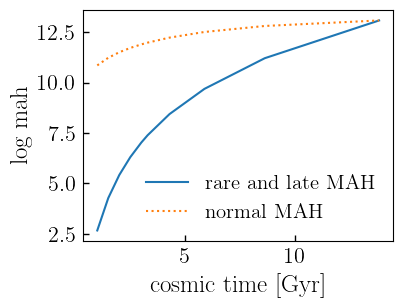

In [51]:
plt.plot(t_table, mah_histories[1], label='rare and late MAH')
plt.plot(t_table, mah_histories1[1], ls=':', label='normal MAH')
plt.xlabel("cosmic time [Gyr]")
plt.ylabel("log mah")
plt.legend()

In [115]:
from diffstarpop.star_wrappers import UH, sfh_scan_tobs_kern, sm_sfr_history_diffstar_scan
dt = _jax_get_dt_array(t_table)
_arr = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[4,12].copy()
sfr_ms_params = jnp.array([12.0, -0.0, 4.0, 5.0])
q_params = jnp.array([0.7, -1.0, -1.0, -1.0])
def _fun(
        sfr_ms_params,
):
    sfr_params = [*sfr_ms_params[0:3], UH, sfr_ms_params[3]]
    ms_sfr = sfh_scan_tobs_kern(t_table, _arr, sfr_params)

    return ms_sfr# jnp.mean(ms_sfr)# jnp.mean(jnp.log10(ms_sfr))
_fun_deriv = jjit(grad(_fun, argnums=(0)))

_fun(sfr_ms_params)#, _fun_deriv(sfr_ms_params)

Array([0.00000000e+00, 1.26383965e-36, 4.33661448e-31, 8.52796926e-27,
       2.74714878e-23, 1.59748084e-21, 1.92124781e-16, 2.15538323e-10,
       4.82595526e-03, 1.96351681e+01], dtype=float32)

In [45]:
indx_best = np.nanargmin(loss_arr)
best_fit_params = params_arr[indx_best]
loss = loss_arr[indx_best]

params_init = best_fit_params.copy()


In [48]:
n_histories = int(1e4)
n_step = int(1e4)
step_size = 0.01

N_PDF_Q = len(DEFAULT_SFH_PDF_QUENCH_PARAMS)
N_PDF_MS = len(DEFAULT_SFH_PDF_MAINSEQ_PARAMS)
N_R_Q = len(DEFAULT_R_QUENCH_PARAMS)
N_R_MS = len(DEFAULT_R_MAINSEQ_PARAMS)

ndsig = np.ones((2*n_histories, 2))
ndsig[:,0] *= delta_bins_mstar
ndsig[:,1] *= delta_bins_ssfr

_loss_data = (
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    index_select,
    index_high,
    fstar_tdelay,
    ndsig,
    bins_LO,
    bins_HI,
    t_sel_hists,
    MC_res_target
)

init_guess = np.concatenate((
    dict_to_array(DEFAULT_SFH_PDF_QUENCH_PARAMS),
    dict_to_array(DEFAULT_SFH_PDF_MAINSEQ_PARAMS),
    dict_to_array(DEFAULT_R_QUENCH_PARAMS),
    dict_to_array(DEFAULT_R_MAINSEQ_PARAMS),
))

# ran_key = jran.PRNGKey(np.random.randint(2**32))
# ran_key = jran.PRNGKey(0)

loss_arr = np.zeros(n_step).astype("f4") + np.inf

# opt_init, opt_update, get_params = jax_opt.adam(step_size)
# opt_state = opt_init(params_init)

n_params = len(params_init)
params_arr = np.zeros((n_step, n_params)).astype("f4")

no_nan_grads_arr = np.zeros(n_step)
for istep in range(n_step):
    t0 = time.time()
    ran_key, subkey = jran.split(ran_key, 2)

    p = np.array(get_params(opt_state))

    loss = loss_hists_vmap(p, _loss_data, n_histories, ran_key)
    grads = loss_hists_vmap_deriv(p, _loss_data, n_histories, ran_key)
    
    no_nan_params = np.all(np.isfinite(p))
    no_nan_loss = np.isfinite(loss)
    no_nan_grads = np.all(np.isfinite(grads))
    if ~no_nan_params | ~no_nan_loss | ~no_nan_grads:
        # break
        if istep > 0:
            indx_best = np.nanargmin(loss_arr[:istep])
            best_fit_params = params_arr[indx_best]
            best_fit_loss = loss_arr[indx_best]
        else:
            best_fit_params = np.copy(p)
            best_fit_loss = 999.99
    else:
        params_arr[istep, :] = p
        loss_arr[istep] = loss
        opt_state = opt_update(istep, grads, opt_state)
        
    keys = jran.split(ran_key, 5)
    
    no_nan_grads_arr[istep] = ~no_nan_grads
    t1 = time.time()
    print(istep, loss, t1-t0, no_nan_grads)
    # if ~no_nan_grads:
    #     break

"""
indx_best = np.nanargmin(loss_arr)
best_fit_params = params_arr[indx_best]
loss = loss_arr[indx_best]

"""

0 0.012527874 281.3499071598053 True
1 0.01309467 214.70076966285706 True
2 0.012759006 223.70534801483154 True
3 0.013587017 208.56979393959045 True
4 0.012796013 278.19221091270447 True
5 0.012620278 239.9941530227661 True
6 0.013256041 229.76965022087097 True
7 0.012516901 198.70203018188477 True
8 0.013000352 217.38328289985657 True
9 0.012064626 225.85739588737488 True
10 0.0124507435 229.79326105117798 True
11 0.012820805 168.50619792938232 True
12 0.012516184 167.13487792015076 True
13 0.012867805 180.0395529270172 True
14 0.012667323 173.39441585540771 True
15 0.012169141 179.63154196739197 True
16 0.012359667 192.7078320980072 True
17 0.012222148 187.9534740447998 True
18 0.0123671405 183.4627809524536 True
19 0.012368439 208.49374222755432 True
20 0.0123572685 208.14464783668518 True
21 0.012732151 223.3848111629486 True
22 0.012987329 210.93783497810364 True
23 0.012499073 213.54369688034058 True
24 0.012252714 184.67550683021545 True
25 0.012040546 170.53386187553406 True
2

KeyboardInterrupt: 

In [49]:
indx_best2 = np.nanargmin(loss_arr)
best_fit_params2 = params_arr[indx_best2]
loss2 = loss_arr[indx_best2]

In [76]:
n_histories = int(5e3)
n_step = int(1e2)
step_size = 0.01


# ran_key = jran.PRNGKey(np.random.randint(2**32))
ran_key = jran.PRNGKey(0)

loss_arr = np.zeros(n_step).astype("f4") + np.inf

# opt_init, opt_update, get_params = jax_opt.adam(step_size)
# opt_state = opt_init(params_init)

n_params = len(params_init)
params_arr = np.zeros((n_step, n_params)).astype("f4")

n_mah = 100
sampled_mahs_inds_arr = np.zeros((n_step, n_histories))
no_nan_grads_arr = np.zeros(n_step)
for istep in range(n_step):
    t0 = time.time()
    ran_key, subkey = jran.split(ran_key, 2)

    p = np.array(get_params(opt_state))

    loss = loss_p50(p, _loss_data, n_histories, ran_key)
    grads = loss_p50_deriv(p, _loss_data, n_histories, ran_key)
    
    no_nan_params = np.all(np.isfinite(p))
    no_nan_loss = np.isfinite(loss)
    no_nan_grads = np.all(np.isfinite(grads))
    if ~no_nan_params | ~no_nan_loss | ~no_nan_grads:
        # break
        if istep > 0:
            indx_best = np.nanargmin(loss_arr[:istep])
            best_fit_params = params_arr[indx_best]
            best_fit_loss = loss_arr[indx_best]
        else:
            best_fit_params = np.copy(p)
            best_fit_loss = 999.99
    else:
        params_arr[istep, :] = p
        loss_arr[istep] = loss
        opt_state = opt_update(istep, grads, opt_state)
        
    keys = jran.split(ran_key, 5)
    

    sampled_mahs_inds = jran.choice(
        keys[0], n_mah, shape=(n_histories,), replace=True
    )
    sampled_mahs_inds_arr[istep] = sampled_mahs_inds
    no_nan_grads_arr[istep] = ~no_nan_grads
    t1 = time.time()
    print(istep, loss, t1-t0, no_nan_grads)
    # if loss < 0.05:
    #     break

"""
indx_best = np.nanargmin(loss_arr)
best_fit_params = params_arr[indx_best]
loss = loss_arr[indx_best]

"""

0 0.018539041 40.92223310470581 True
1 0.020497877 33.083258867263794 True
2 0.019654617 31.372318029403687 True
3 0.02087221 31.100286960601807 True
4 0.020715687 31.94072389602661 True
5 0.01873094 34.36488199234009 True
6 0.020600937 31.74677085876465 True
7 0.019209394 39.047439098358154 True
8 0.01972091 35.02100992202759 True
9 0.019371945 37.64165496826172 True
10 0.019859517 39.738121032714844 True
11 0.018634817 34.61252784729004 True
12 0.019148203 34.43887901306152 True
13 0.019522365 36.45312690734863 True
14 0.018894458 35.39856195449829 True
15 0.018491905 41.01181221008301 True
16 0.01901765 34.48942804336548 True
17 0.018161297 33.77324390411377 True
18 0.01928672 38.750288248062134 True
19 0.02056546 33.75440192222595 True
20 0.01987597 35.536927938461304 True
21 0.018495368 34.944334745407104 True
22 0.01779069 35.81099796295166 True
23 0.018025672 37.17343211174011 True
24 0.01982776 33.27502703666687 True
25 0.019161692 44.26388216018677 True
26 0.019138673 33.98938

'\nindx_best = np.nanargmin(loss_arr)\nbest_fit_params = params_arr[indx_best]\nloss = loss_arr[indx_best]\n\n'

In [77]:
indx_best3 = np.nanargmin(loss_arr)
best_fit_params3 = params_arr[indx_best3]
loss3 = loss_arr[indx_best3]

In [90]:
ran_key = jran.PRNGKey(0)
for istep in range(54):
    t0 = time.time()
    ran_key, subkey = jran.split(ran_key, 2)
    
loss = loss_p50(params_arr[istep], _loss_data, n_histories, ran_key)
grads = loss_p50_deriv(params_arr[istep], _loss_data, n_histories, ran_key)

In [ ]:
NAN_KEYS = jran.split(ran_key, 5)

In [59]:
import numpy as np
from numpy.random import RandomState
from jax import vmap
from jax import jit as jjit
from jax import numpy as jnp
from jax import random as jran
from collections import OrderedDict
from functools import partial

from diffstar.stars import (
    calculate_sm_sfr_fstar_history_from_mah,
    DEFAULT_SFR_PARAMS as DEFAULT_SFR_PARAMS_DICT,
    _get_unbounded_sfr_params,
    _integrate_sfr,
    compute_fstar,
    fstar_tools,
)
from diffstar.quenching import (
    DEFAULT_Q_PARAMS as DEFAULT_Q_PARAMS_DICT,
    _get_unbounded_q_params,
    quenching_function,
)
from diffstar.main_sequence import get_ms_sfh_from_mah_kern
from diffstar.utils import jax_np_interp, _jax_get_dt_array


from diffmah.individual_halo_assembly import _calc_halo_history

from diffstarpop.pdf_quenched import (
    get_smah_means_and_covs_quench,
    DEFAULT_SFH_PDF_QUENCH_PARAMS,
    frac_quench_vs_lgm0,
)
from diffstarpop.pdf_mainseq import get_smah_means_and_covs_mainseq, DEFAULT_SFH_PDF_MAINSEQ_PARAMS
from diffstarpop.pdf_model_assembly_bias_shifts import (
    DEFAULT_R_QUENCH_PARAMS,
    DEFAULT_R_MAINSEQ_PARAMS,
    _get_slopes_quench,
    _get_slopes_mainseq,
    _get_shift_to_PDF_mean,
)
from diffstarpop.star_wrappers import (
    sm_sfr_history_diffstar_scan_XsfhXmah_vmap,
    sm_sfr_history_diffstar_scan_MS_XsfhXmah_vmap,
)
from diffstarpop.utils import _tw_cuml_lax_kern


from functools import partial
from diffstarpop.star_wrappers import (
    sm_sfr_history_diffstar_scan_XsfhXmah_vmap,
    sm_sfr_history_diffstar_scan_MS_XsfhXmah_vmap,
)


@partial(jjit, static_argnames=["n_histories"])
def _fun(
    t_table,
    logmh,
    mah_params,
    p50,
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    pdf_parameters_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    R_model_params_MS=DEFAULT_R_MAINSEQ_PARAMS,
):
    lgt = jnp.log10(t_table)
    dt = _jax_get_dt_array(t_table)
    logmh = jnp.atleast_1d(logmh)

    (choice_key, quench_key, mainseq_key, fquench_key, ran_key) = jran.split(ran_key, 5)
    n_mah = len(mah_params)

    sampled_mahs_inds = jran.choice(
        choice_key, n_mah, shape=(n_histories,), replace=True
    )
    mah_params_sampled = mah_params[sampled_mahs_inds]
    p50_sampled = p50[sampled_mahs_inds]

    _res = get_smah_means_and_covs_mainseq(logmh, *pdf_parameters_MS)
    means_mainseq, covs_mainseq = _res
    means_mainseq = means_mainseq[0]
    covs_mainseq = covs_mainseq[0]

    R_vals_mainseq = _get_slopes_mainseq(logmh, *R_model_params_MS)
    R_vals_mainseq = jnp.array(R_vals_mainseq)[:, 0]
    shifts_mainseq = jnp.einsum("p,h->hp", R_vals_mainseq, (p50_sampled - 0.5))

    sfr_params_MS = jran.multivariate_normal(
        mainseq_key, means_mainseq, covs_mainseq, shape=(n_histories,)
    )
    sfr_params_MS = sfr_params_MS + shifts_mainseq
    # q_params_MS = jnp.ones_like(q_params_Q) * 10.0

    mstar_MS, sfr_MS, fstar_MS = sm_sfr_history_diffstar_scan_MS_XsfhXmah_vmap(
        t_table,
        lgt,
        dt,
        mah_params_sampled,
        sfr_params_MS,
        index_select,
        index_high,
        fstar_tdelay,
    )
    mstar_MS = jnp.where(mstar_MS>0.0, jnp.log10(mstar_MS), 0.0) 
    return (jnp.mean(mstar_MS) - 10.0)**2

_fun_deriv = jjit(grad(_fun, argnums=(9, 10)), static_argnames=["n_histories"])


In [66]:
binid = 3
_res = _fun(
    _loss_data[0],
    _loss_data[1][binid],
    _loss_data[2][binid],
    _loss_data[3][binid],
    n_histories,
    ran_key,
    _loss_data[4],
    _loss_data[5],
    _loss_data[6],
    p[N_PDF_Q:N_PDF_Q+N_PDF_MS],
    p[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
)

print(_res)

_res_grads = _fun_deriv(
    _loss_data[0],
    _loss_data[1][binid],
    _loss_data[2][binid],
    _loss_data[3][binid],
    n_histories,
    ran_key,
    _loss_data[4],
    _loss_data[5],
    _loss_data[6],
    p[N_PDF_Q:N_PDF_Q+N_PDF_MS],
    p[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
)

print(_res_grads)


0.36601254
(DeviceArray([-5.0228345e-03, -5.0228345e-03,  3.1189024e-01,
              3.1189024e-01, -9.0579391e-02, -9.0579391e-02,
             -9.8150112e-03, -9.8150112e-03, -1.9840196e-01,
             -1.9840196e-01, -1.1302834e-01, -1.1302834e-01,
             -2.0473240e-02, -2.0473240e-02, -2.6698029e-01,
             -2.6698029e-01,  6.3770282e-04,  6.3770282e-04,
             -1.0377981e-02, -1.0377981e-02, -1.9005980e-04,
             -1.9005980e-04,  1.1041158e-02,  1.1041158e-02,
             -5.9196786e-03, -5.9196786e-03,  1.1106974e-02,
              1.1106974e-02], dtype=float32), DeviceArray([-0.01634221, -0.01634221, -0.00705876, -0.00705876,
             -0.00464512, -0.00464512,  0.00011704,  0.00011704],            dtype=float32))


In [32]:
indx_best = np.nanargmin(loss_arr)
best_fit_params = params_arr[indx_best]
loss = loss_arr[indx_best]

In [50]:
# t_table = np.linspace(0.1, TODAY, 100)

_best_fit_params = best_fit_params2.copy()
n_histories = int(1e4)
ran_key = jran.PRNGKey(0)
i = 21
t0 = time.time()
MC_res_best_fit = sumstats_sfh_MIX_p50_vmap(
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    _best_fit_params[0:N_PDF_Q],
    _best_fit_params[N_PDF_Q:N_PDF_Q+N_PDF_MS],
    _best_fit_params[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
    _best_fit_params[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
)
t1 = time.time()
print(t1-t0)

9.881993770599365


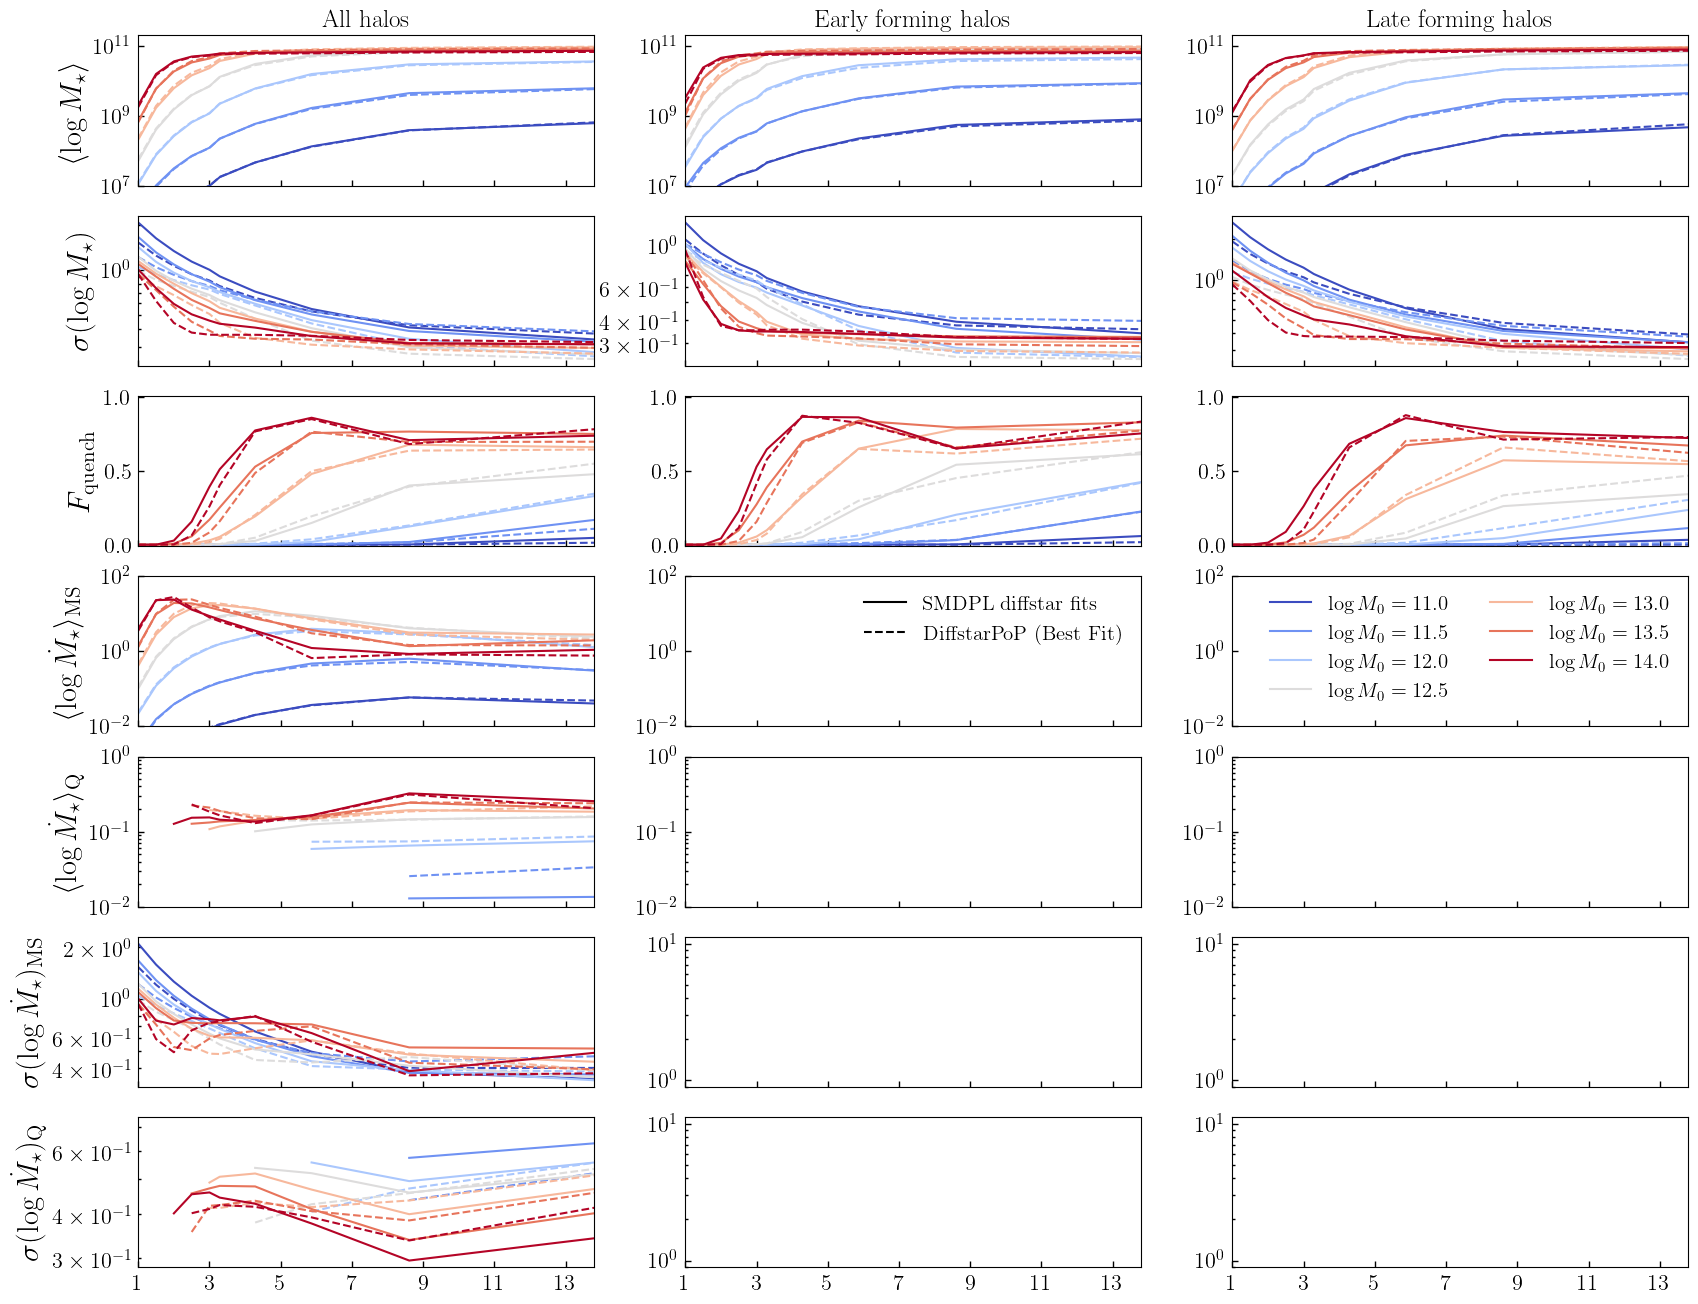

In [51]:
NM0 = len(logm0_binmids)
colors = plt.get_cmap("viridis")(np.linspace(0,1,NM0))
colors = plt.get_cmap("coolwarm")(np.linspace(0,1,NM0))

fontsize = 22
fig, ax = plt.subplots(7,3, figsize=(20,16), sharex=True, sharey=False)

lw = 1.5

for i in range(NM0):    
    
    ax[0,0].plot(t_table, 10**MC_res_target[0][i], ls="-", color=colors[i])
    ax[0,1].plot(t_table, 10**MC_res_target[7][i], ls="-", color=colors[i])
    ax[0,2].plot(t_table, 10**MC_res_target[8][i], ls="-", color=colors[i])
    
    ax[1,0].plot(t_table, np.sqrt(MC_res_target[1][i]), ls="-", color=colors[i])
    ax[1,1].plot(t_table, np.sqrt(MC_res_target[9][i]), ls="-", color=colors[i])
    ax[1,2].plot(t_table, np.sqrt(MC_res_target[10][i]), ls="-", color=colors[i])
    
    ax[2,0].plot(t_table, MC_res_target[6][i], ls="-", color=colors[i])
    ax[2,1].plot(t_table, MC_res_target[11][i], ls="-", color=colors[i])
    ax[2,2].plot(t_table, MC_res_target[12][i], ls="-", color=colors[i])

    mskQ = np.array(MC_res_target[6][i] > 0.01)
    mskSF = np.array(MC_res_target[6][i] < 0.99)
    ax[3,0].plot(t_table[mskSF], 10**MC_res_target[2][i][mskSF], ls="-", color=colors[i])
    ax[4,0].plot(t_table[mskQ], 10**MC_res_target[3][i][mskQ], ls="-", color=colors[i])

    ax[5,0].plot(t_table[mskSF], np.sqrt(MC_res_target[4][i])[mskSF], ls="-", color=colors[i])
    ax[6,0].plot(t_table[mskQ], np.sqrt(MC_res_target[5][i])[mskQ], ls="-", color=colors[i])
    
    ################################
    
    ax[0,0].plot(t_table, 10**MC_res_best_fit[0][i], ls="--", color=colors[i], lw=lw)
    ax[0,1].plot(t_table, 10**MC_res_best_fit[7][i], ls="--", color=colors[i], lw=lw)
    ax[0,2].plot(t_table, 10**MC_res_best_fit[8][i], ls="--", color=colors[i], lw=lw)
    
    ax[1,0].plot(t_table, np.sqrt(MC_res_best_fit[1][i]), ls="--", color=colors[i], lw=lw)
    ax[1,1].plot(t_table, np.sqrt(MC_res_best_fit[9][i]), ls="--", color=colors[i], lw=lw)
    ax[1,2].plot(t_table, np.sqrt(MC_res_best_fit[10][i]), ls="--", color=colors[i], lw=lw)
    
    ax[2,0].plot(t_table, MC_res_best_fit[6][i], ls="--", color=colors[i], lw=lw)
    ax[2,1].plot(t_table, MC_res_best_fit[11][i], ls="--", color=colors[i], lw=lw)
    ax[2,2].plot(t_table, MC_res_best_fit[12][i], ls="--", color=colors[i], lw=lw)

    mskQ = np.array(MC_res_best_fit[6][i] > 0.01)
    mskSF = np.array(MC_res_best_fit[6][i] < 0.99)
    ax[3,0].plot(t_table[mskSF], 10**MC_res_best_fit[2][i][mskSF], ls="--", color=colors[i], lw=lw)
    ax[4,0].plot(t_table[mskQ], 10**MC_res_best_fit[3][i][mskQ], ls="--", color=colors[i], lw=lw)

    ax[5,0].plot(t_table[mskSF], np.sqrt(MC_res_best_fit[4][i])[mskSF], ls="--", color=colors[i], lw=lw)
    ax[6,0].plot(t_table[mskQ], np.sqrt(MC_res_best_fit[5][i])[mskQ], ls="--", color=colors[i], lw=lw)

ax[0,0].set_title("All halos")
ax[0,1].set_title("Early forming halos")
ax[0,2].set_title("Late forming halos")

ax[0,0].set_ylabel(r'$\langle \log M_\star\rangle$', fontsize=fontsize)
ax[1,0].set_ylabel(r'$\sigma(\log M_\star)$', fontsize=fontsize)
ax[2,0].set_ylabel(r'$F_{\rm quench}$', fontsize=fontsize)
ax[3,0].set_ylabel(r'$\langle \log\dot{M}_\star\rangle_{\rm{MS}}$', fontsize=fontsize)
ax[4,0].set_ylabel(r'$\langle \log \dot{M}_\star\rangle_{\rm{Q}}$', fontsize=fontsize)
ax[5,0].set_ylabel(r'$\sigma( \log\dot{M}_\star)_{\rm{MS}}$', fontsize=fontsize)
ax[6,0].set_ylabel(r'$\sigma( \log\dot{M}_\star)_{\rm{Q}}$', fontsize=fontsize)

for i in range(3):
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 2e11)
    ax[2,i].set_ylim(-0.01,1.01)
    ax[3,i].set_yscale('log')
    ax[4,i].set_yscale('log')
    ax[3,i].set_ylim(1e-2, 1e2)
    ax[4,i].set_ylim(1e-2, 1e0)
    ax[5,i].set_yscale('log')
    ax[6,i].set_yscale('log')
    
ax[0,0].set_xlim(1.0, TODAY)
ax[0,0].set_xticks(np.arange(1,13.1,2))

legend_elements = [
    Line2D([0], [0], color=colors[i], label=r'$\log M_0 = %.1f$'%logm0_binmids[i])
    for i in range(NM0)
]
ax[3,2].legend(handles=legend_elements, loc=1, ncol=2)

legend_elements = [
    Line2D([0], [0], color='k', ls='-', label=r"SMDPL diffstar fits"),
    Line2D([0], [0], color='k', ls='--', label=r"DiffstarPoP (Best Fit)"),
]
ax[3,1].legend(handles=legend_elements, loc=1, ncol=1)

# plt.savefig("SMDPL_diffstarpop_sumstats_bestfit.png", bbox_inches='tight', dpi=300)
# plt.savefig("SMDPL_diffstarpop_sumstats_bestfit_v2.png", bbox_inches='tight', dpi=300)

plt.show()

In [16]:
from diffstarpop.json_utils import load_params, write_params_json, print_all_default_dicts

In [58]:
path_json = "/Users/alarcon/Documents/source/diffstarpop/diffstarpop/bestfit_diffstarpop_params_UM_hists_v4.json"

In [59]:
write_params_json(path_json, best_fit_params2)

In [232]:
outputs = load_params(path_json)
print_all_default_dicts(outputs[1:])

DEFAULT_SFH_PDF_QUENCH_PARAMS = OrderedDict(
    frac_quench_x0=11.860,
    frac_quench_k=1.611,
    frac_quench_ylo=-0.872,
    frac_quench_yhi=2.139,
    mean_ulgm_quench_ylo=11.540,
    mean_ulgm_quench_yhi=12.080,
    mean_ulgy_quench_ylo=0.481,
    mean_ulgy_quench_yhi=-0.223,
    mean_ul_quench_ylo=-1.274,
    mean_ul_quench_yhi=1.766,
    mean_utau_quench_ylo=55.480,
    mean_utau_quench_yhi=-66.540,
    mean_uqt_quench_ylo=1.744,
    mean_uqt_quench_yhi=0.042,
    mean_uqs_quench_ylo=-2.979,
    mean_uqs_quench_yhi=3.520,
    mean_udrop_quench_ylo=-0.508,
    mean_udrop_quench_yhi=-3.785,
    mean_urej_quench_ylo=2.139,
    mean_urej_quench_yhi=-3.043,
    chol_ulgm_ulgm_quench_ylo=-1.645,
    chol_ulgm_ulgm_quench_yhi=0.010,
    chol_ulgy_ulgy_quench_ylo=-1.125,
    chol_ulgy_ulgy_quench_yhi=-0.530,
    chol_ul_ul_quench_ylo=-0.701,
    chol_ul_ul_quench_yhi=0.544,
    chol_utau_utau_quench_ylo=0.833,
    chol_utau_utau_quench_yhi=1.100,
    chol_uqt_uqt_quench_ylo=-1.001,
   

In [17]:
import scipy.optimize as so
from scipy.ndimage import gaussian_filter

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, bins_x, bins_y, ax=None, smooth=False, level=0.68, weights=None, **contour_kwargs):

    nbins_x = len(bins_x) - 1
    nbins_y = len(bins_y) - 1
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(bins_x,bins_y), density=1, weights=weights)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    if smooth:
        H = gaussian_filter(H, 1.0, )
    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, level))
    levels = [one_sigma]

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)

    return contour

def density_contourf(xdata, ydata, bins_x, bins_y, ax=None, smooth=False, levels=0.68, weights=None, **contour_kwargs):

    nbins_x = len(bins_x) - 1
    nbins_y = len(bins_y) - 1
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(bins_x,bins_y), density=1, weights=weights)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    if smooth:
        H = gaussian_filter(H, 1.0, )
    pdf = (H*(x_bin_sizes*y_bin_sizes))

    new_levels = []
    for level in np.sort(levels)[::-1]:
        _new_level = so.brentq(find_confidence_interval, 0., 1., args=(pdf, level))
        new_levels.append(_new_level)
        
    

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        contour = plt.contourf(X, Y, Z, levels=new_levels, origin="lower", **contour_kwargs)
    else:
        contour = ax.contourf(X, Y, Z, levels=new_levels, origin="lower", **contour_kwargs)

    return contour


In [18]:
from diffmah.individual_halo_assembly import _calc_halo_history
from diffstar.utils import _get_dt_array
# from diffstarpop.utils import get_t50_p50

_calc_halo_history_vmap = jjit(vmap(_calc_halo_history, in_axes=(None, *[0]*6)))

_ids = np.argmin(np.subtract.outer(z_table, np.arange(0,2.1,0.5))**2, axis=0)[::-1]


ValueError: cannot reshape array of size 64400 into shape (100,10000,4)

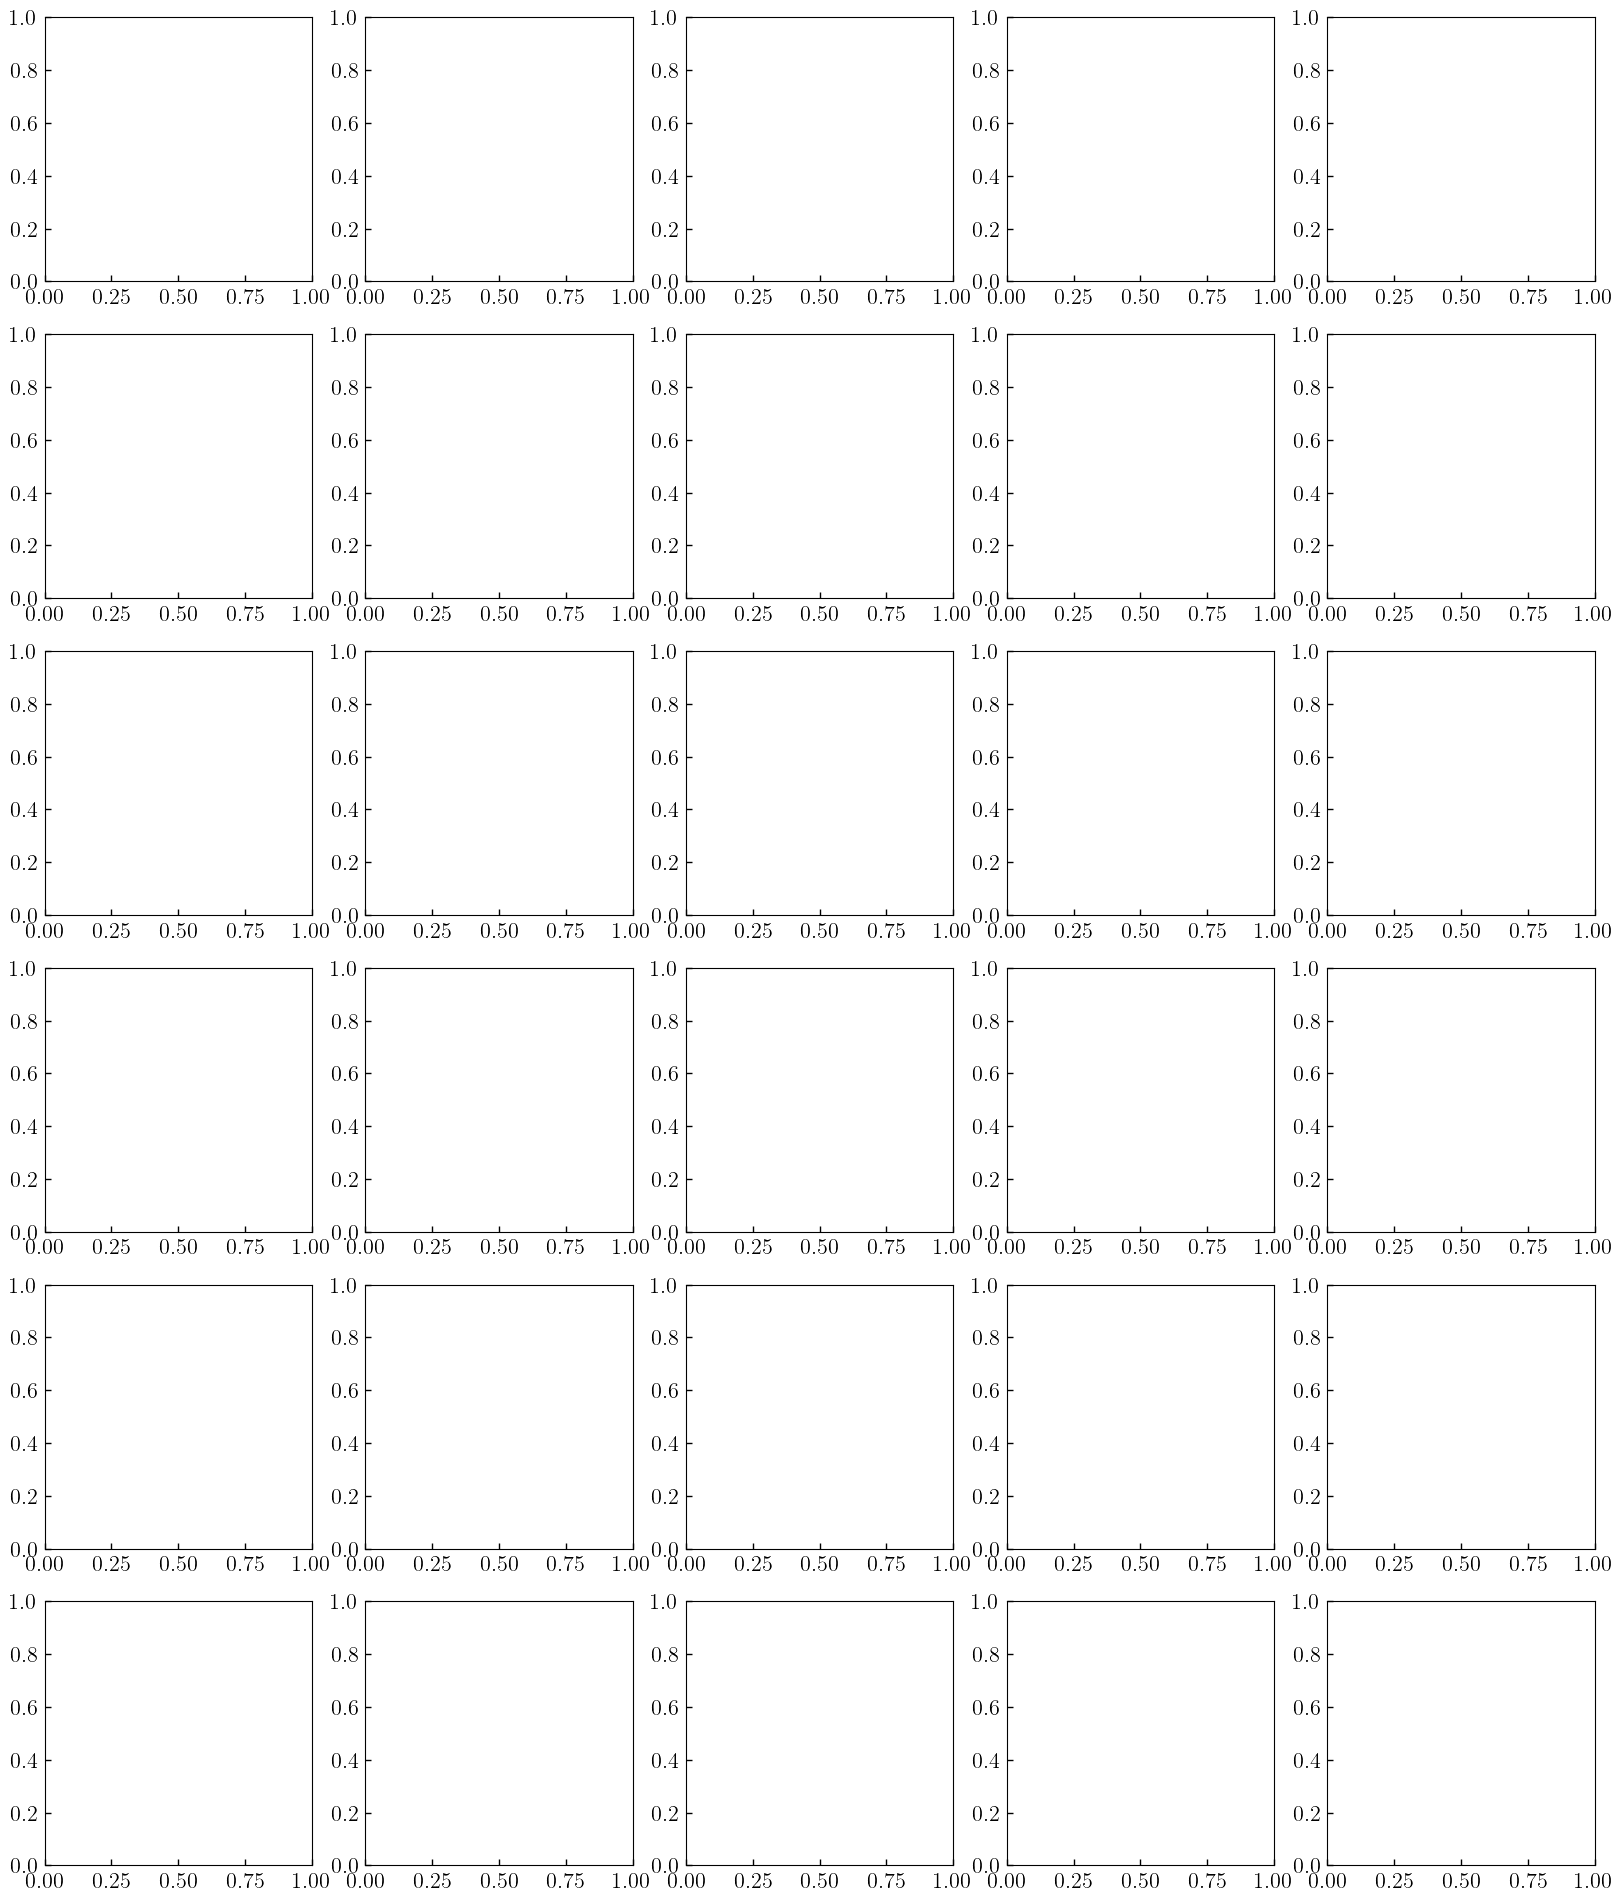

In [26]:
"""
init_guess = np.concatenate((
    dict_to_array(DEFAULT_SFH_PDF_QUENCH_PARAMS),
    dict_to_array(DEFAULT_SFH_PDF_MAINSEQ_PARAMS),
    dict_to_array(DEFAULT_R_QUENCH_PARAMS),
    dict_to_array(DEFAULT_R_MAINSEQ_PARAMS),
))
"""
init_guess = outputs[0].copy()


colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']
colors_test = plt.get_cmap("Greys")(np.linspace(0.3,0.7, 3))

n_histories = int(5e4)
ran_key = jran.PRNGKey(0)

nbins_x = np.linspace(7, 12, 40)
nbins_y = np.linspace(-13, -8.5, 40)
        
nbins_x = bins_mstar.copy()
nbins_y = bins_ssfr.copy()

smooth = False
_fact = 4
fig, ax = plt.subplots(6, 5, figsize=(5*_fact,6*_fact))
lgt = jnp.log10(t_table)
# for i, bin_id in enumerate([2,4,6]):
for i, bin_id in enumerate([1, 2, 3, 4, 5, 6]):
    t0 = time.time()
    histories = draw_sfh_MIX(
        t_table,
        logm0_binmids[bin_id],
        halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id],
        p50.reshape(len(logm0_binmids),Nhalos)[bin_id],
        n_histories,
        ran_key,
        index_select,
        index_high,
        fstar_tdelay,
        init_guess[0:N_PDF_Q],
        init_guess[N_PDF_Q:N_PDF_Q+N_PDF_MS],
        init_guess[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
        init_guess[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
        #_best_fit_params[0:N_PDF_Q],
        #_best_fit_params[N_PDF_Q:N_PDF_Q+N_PDF_MS],
        #_best_fit_params[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
        #_best_fit_params[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
    )

    weights = histories[4].copy()
    _params = np.zeros((Nhalos, 6))
    _params[:, 0] = np.log10(TODAY)
    _params[:, 1:3] = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id][:, 0:2]
    _params[:, 3] = 3.5
    _params[:, 4:6] = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id][:, 2:4]

    mah_histories = _calc_halo_history_vmap(lgt, *_params.T)

    _mask = (logmpeak > logm0_binmids[bin_id] - logm0_bin_widths[bin_id]) 
    _mask &= (logmpeak < logm0_binmids[bin_id] + logm0_bin_widths[bin_id])
    mah_histories_SMDPL = _calc_halo_history_vmap(lgt, *mah_params_arr[_mask].T)

    histories_SMDPL = sm_sfr_history_diffstar_scan_XsfhXmah_vmap(
        t_table,
        jnp.log10(t_table),
        _get_dt_array(t_table),
        mah_params_arr[_mask][:, np.array([1,2,4,5])],
        u_fit_params_arr[_mask][:,np.array([0,1,2,4])],
        u_fit_params_arr[_mask][:,5:9],
        index_select,
        index_high,
        fstar_tdelay,
    )
    t1 = time.time()
    print("time i", t1-t0)
    # for j, t_id in enumerate(t_sel_hists[::-1]):
    for j, t_id in enumerate(_ids[::-1]):

        t0 = time.time()


        xdata = np.log10(histories[0][:, t_id])
        print(np.round(np.average(xdata, weights=np.array(weights)),2))
        ydata = np.log10(histories[1][:, t_id] / histories[0][:, t_id])
        
        density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=smooth, weights=weights, level=0.68, linestyles=['--'], colors=[colors[4]])
        density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=smooth, weights=weights, level=0.95, linestyles=['--'], colors=[colors[4]])

        xdata = np.log10(histories_SMDPL[0][:, t_id])
        ydata = np.log10(histories_SMDPL[1][:, t_id] / histories_SMDPL[0][:, t_id])
        print(np.round(np.mean(xdata),2))
        # density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=smooth, level=0.68, linestyles=['--'], colors=[colors[4]])
        # density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=smooth, level=0.95, linestyles=['--'], colors=[colors[4]])
        # density_contourf(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=smooth, levels=[0.68, 0.95], linestyles=['--'], colors=[colors[4]])
        density_contourf(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=smooth, levels=[0.0, .68, 0.95], colors=colors_test)
        t1 = time.time()
        # print("time j", t1-t0)
        
        ax[i,j].text(7.2, -12.5, r"$\log M_0 = %.1f$"%logm0_binmids[bin_id], fontsize=18)
        ax[i,j].text(7.2, -12.5+0.5, r"$z = %.1f$"%abs(z_table[t_id]), fontsize=18)
        ax[i,j].set_xlabel(r'$\log M_\star$')
        ax[i,j].set_ylabel(r'$\log \rm{sSFR}$')
        ax[i,j].set_xticks(np.arange(7,12.1,1))
        ax[i,j].set_yticks(np.arange(-13,-8.9,1))
        
fig.subplots_adjust(wspace=0.4, hspace=0.3)

legend_elements = [
    Line2D([0], [0], color=colors[4], ls='--', label=r'DiffstarPoP'),
    Patch(facecolor=colors_test[0], edgecolor=colors_test[1], label=r'SMDPL Diffstar')
]
ax[5,0].legend(handles=legend_elements, loc=2)
# fig.savefig("mstar_vs_ssfr_diffstarpop_smdpl_v2.png", bbox_inches="tight", dpi=300)
plt.show()
        

In [19]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


In [20]:
path_json = "/Users/alarcon/Documents/source/diffstarpop/diffstarpop/bestfit_diffstarpop_params_UM_hists_v4.json"
outputs = load_params(path_json)


time i 144.49510669708252
12.5 2.9947026044961014
9.18
nan


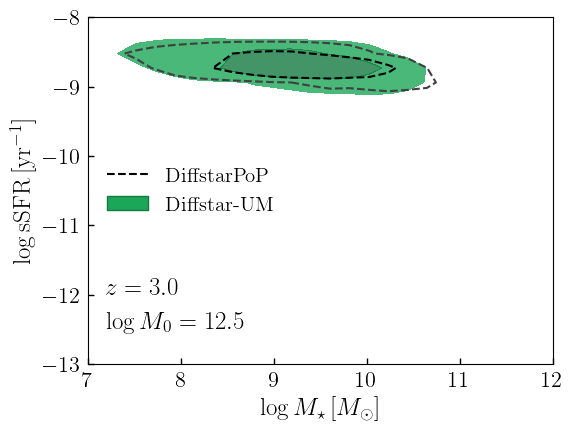

12.5 2.9629849364007934
9.2
nan


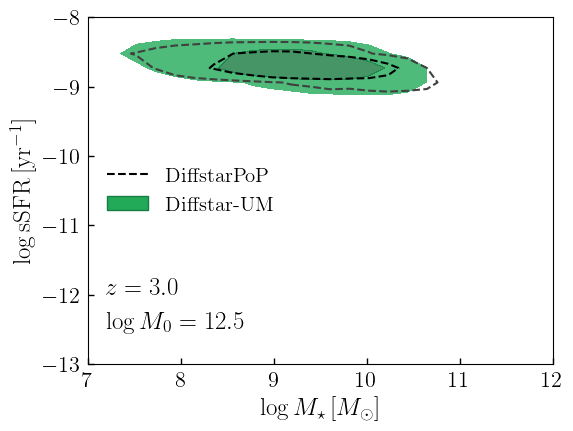

12.5 2.9318768277875353
9.23
nan


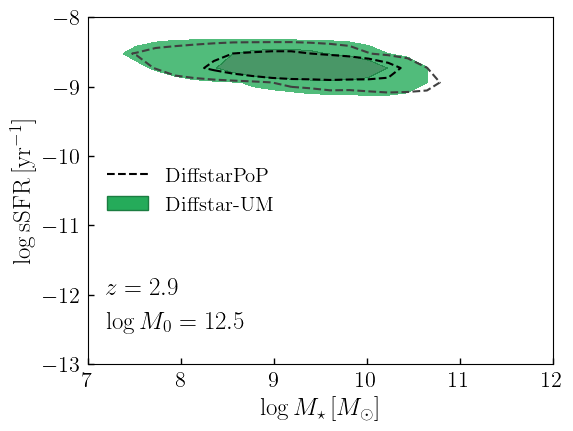

12.5 2.9165454686400625
9.24
nan


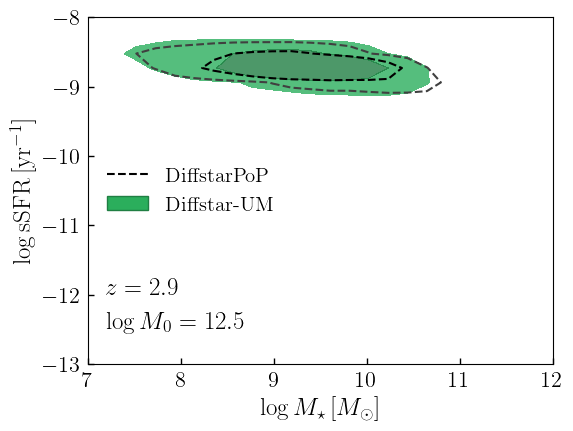

12.5 2.8714152755834985
9.27
nan


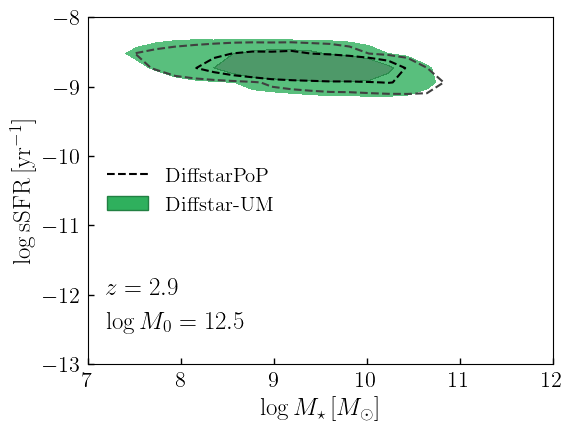

12.5 2.842026710276336
9.3
nan


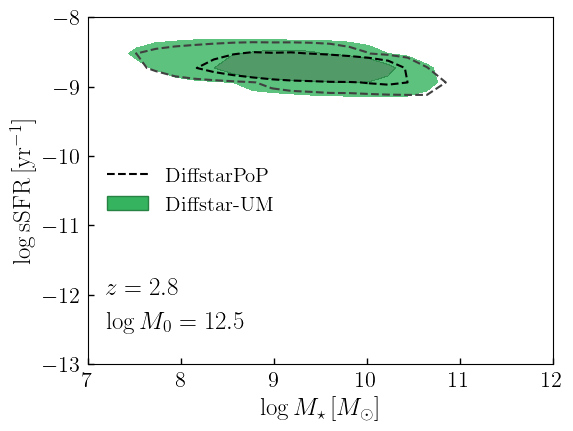

12.5 2.813177363458304
9.32
nan


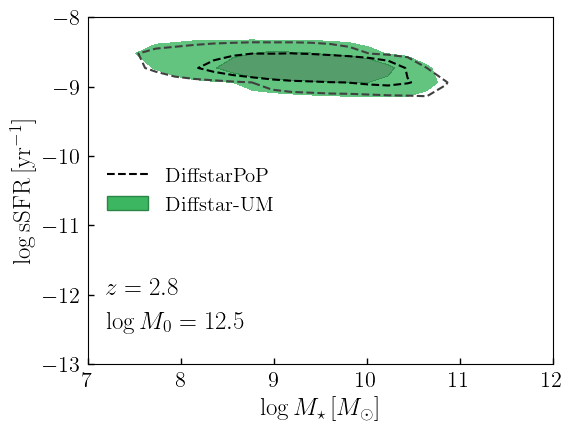

12.5 2.7848513853193726
9.34
nan


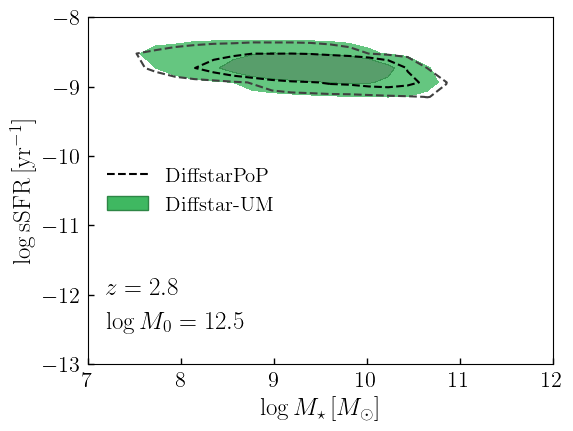

12.5 2.7570336318215474
9.36
nan


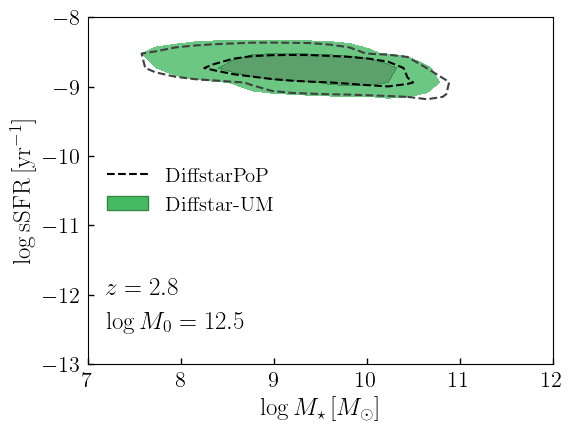

12.5 2.729709437706067
9.38
nan


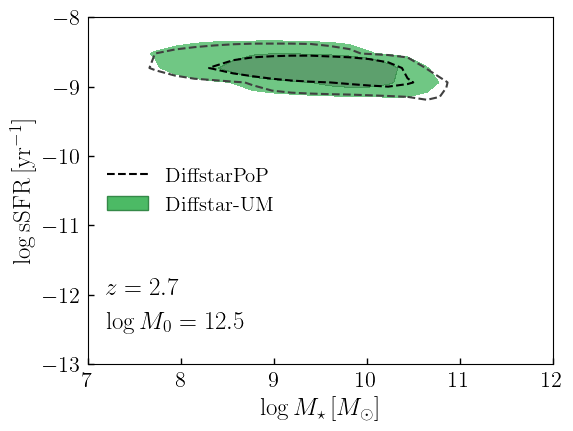

12.5 2.7028648040767567
9.4
nan


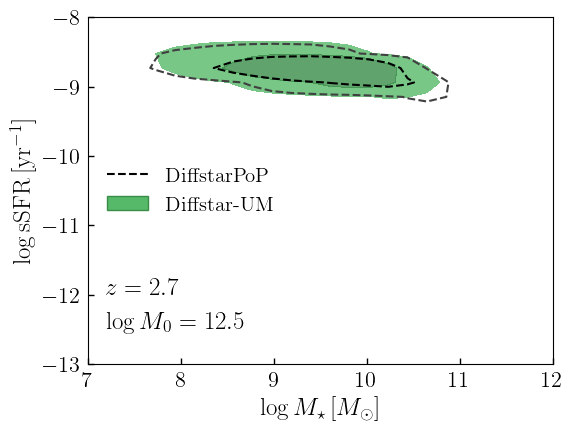

12.5 2.663467670280455
9.43
nan


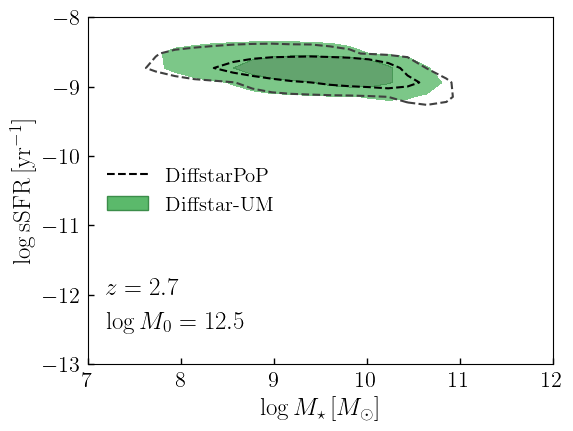

12.5 2.637764029574282
9.45
nan


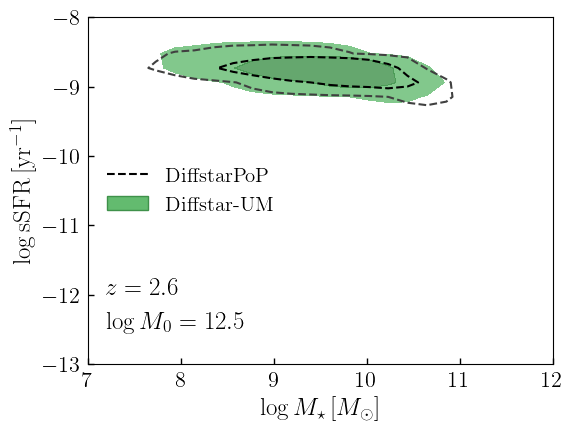

12.5 2.6000196382486203
9.48
nan


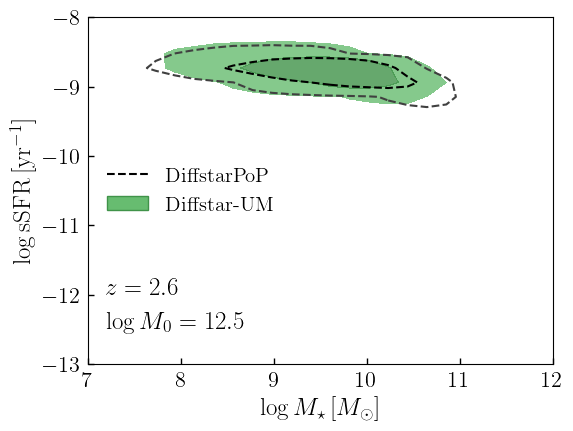

12.5 2.575380375955474
9.5
nan


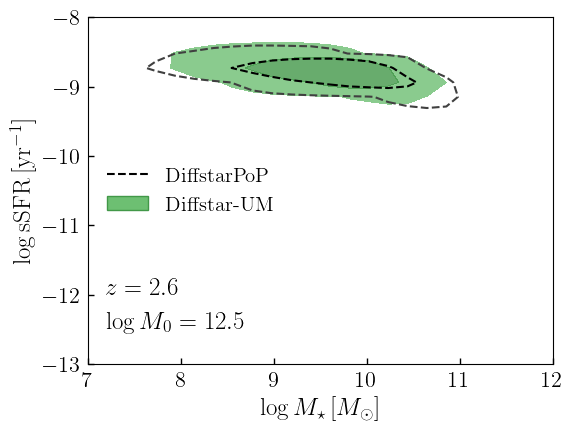

12.5 2.5511470196697696
9.52
nan


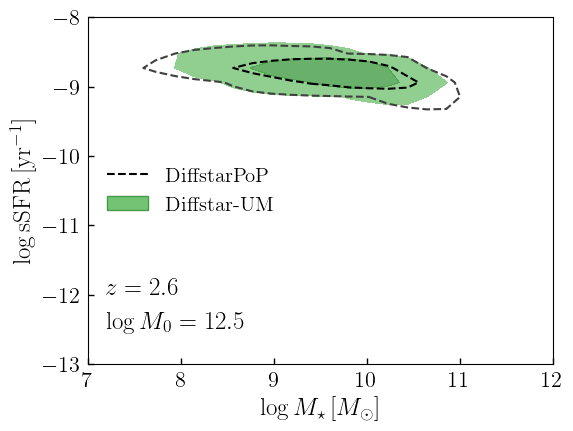

12.5 2.5155345975483137
9.54
nan


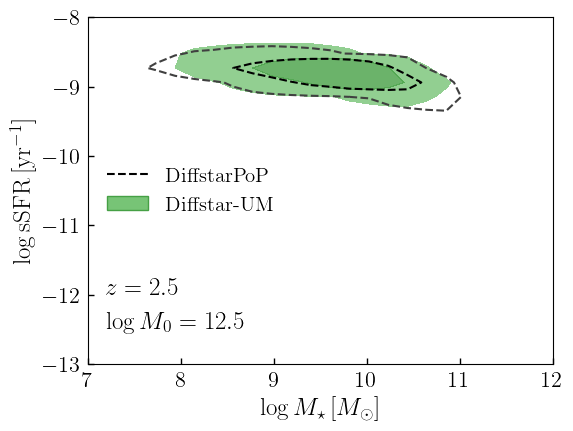

12.5 2.48077669698431
9.57
nan


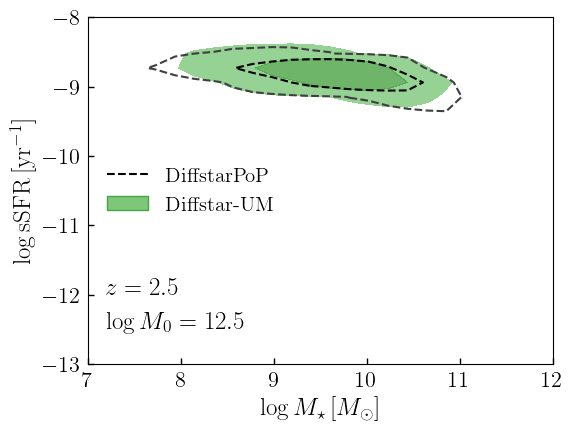

12.5 2.4580632280827746
9.59
nan


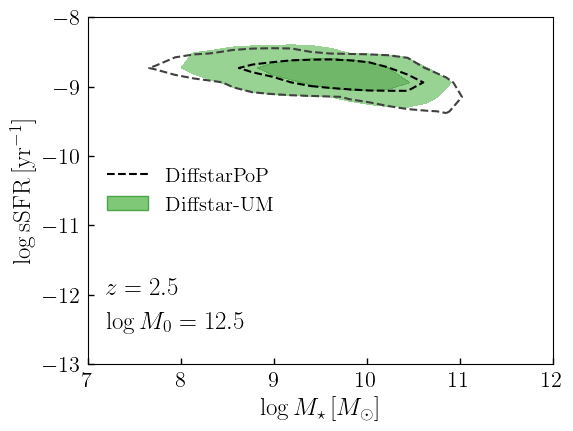

12.5 2.4246574549495032
9.61
nan


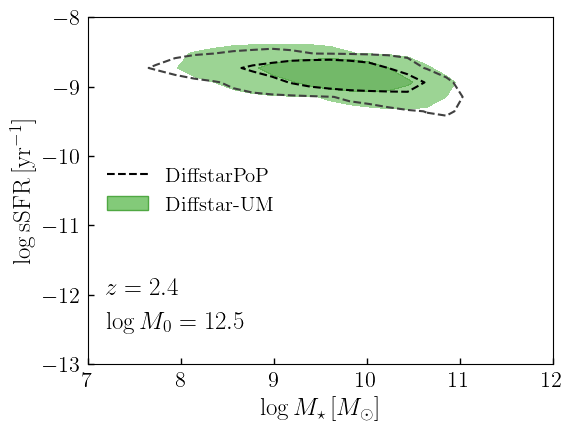

12.5 2.3920224848098486
9.64
nan


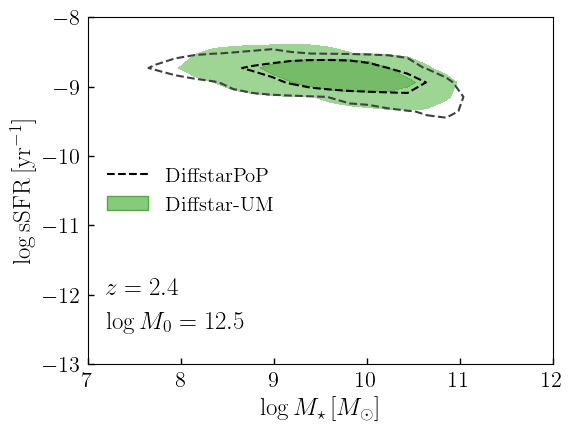

12.5 2.3601297450224576
9.66
nan


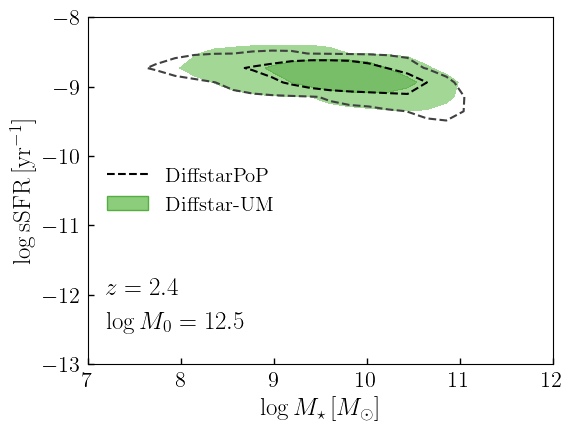

12.5 2.3289522349818914
9.69
nan


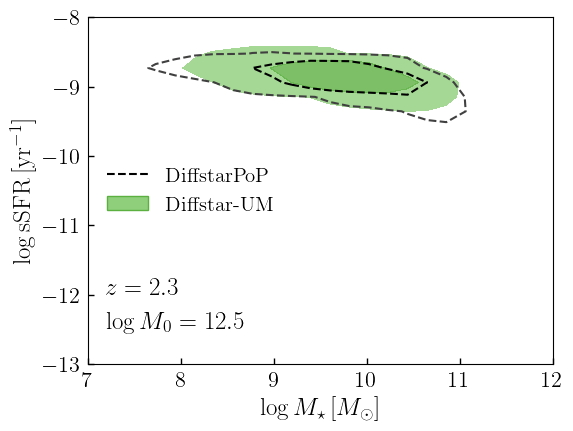

12.5 2.298464152832593
9.71
nan


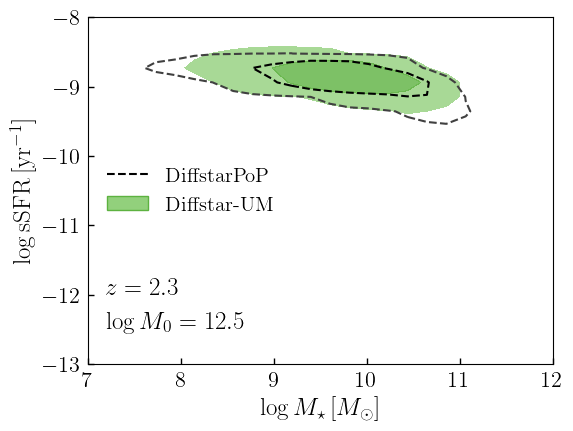

12.5 2.2686410542987208
9.73
nan


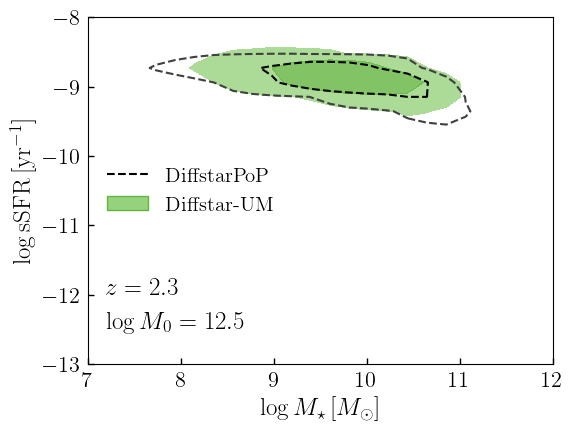

12.5 2.2394596324593614
9.75
nan


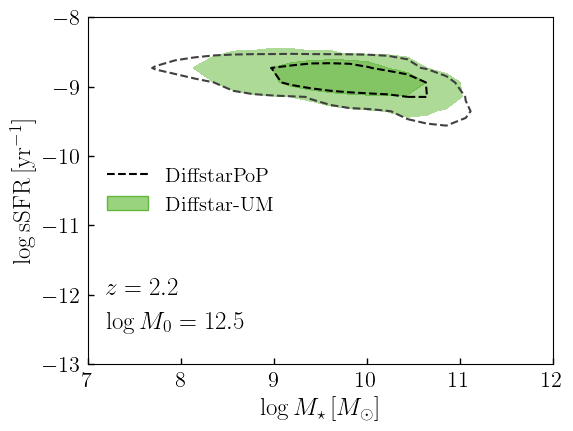

12.5 2.2108976691745337
9.78
nan


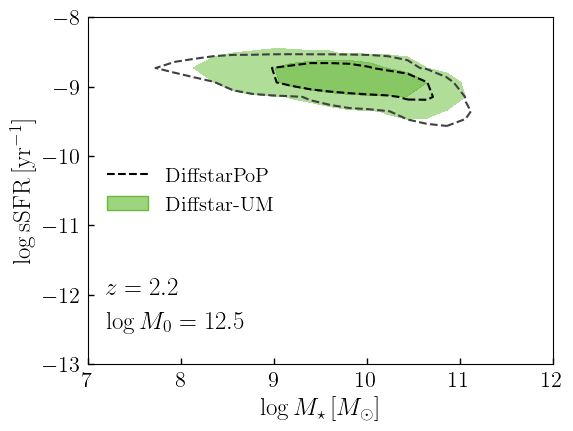

12.5 2.1829340659593766
9.8
nan


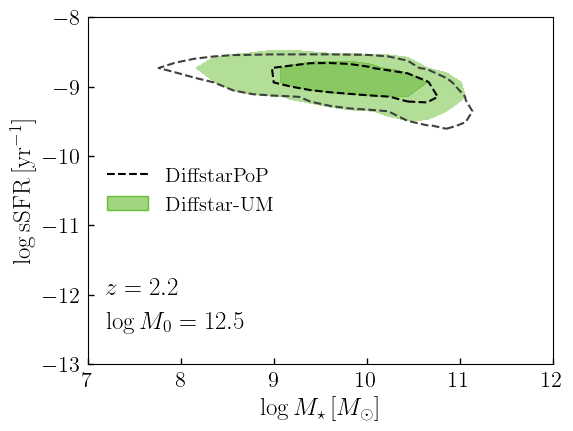

12.5 2.1555485843757594
9.82
nan


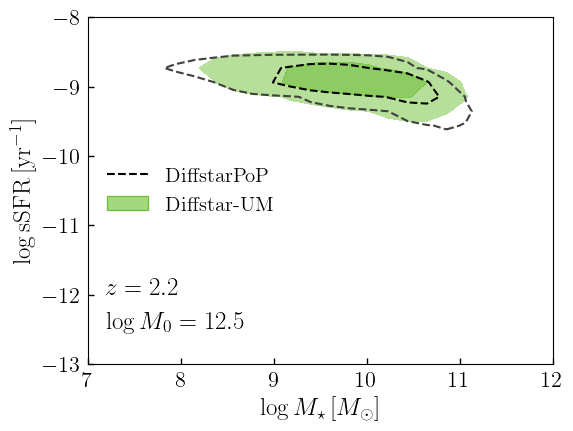

12.5 2.119900809208549
9.85
nan


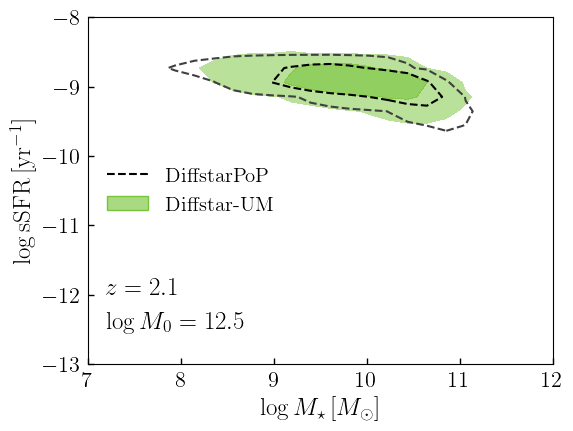

12.5 2.093790990277588
9.86
nan


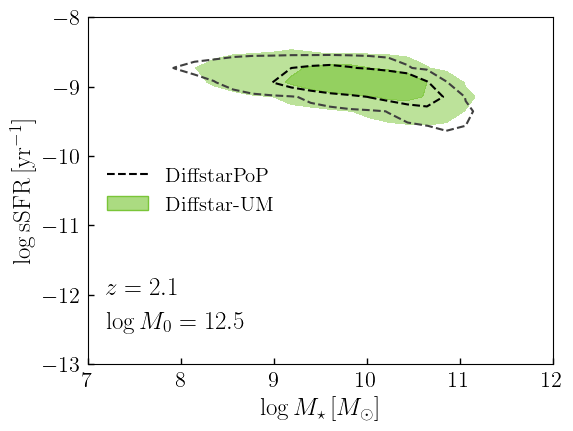

12.5 2.05977964051967
9.89
nan


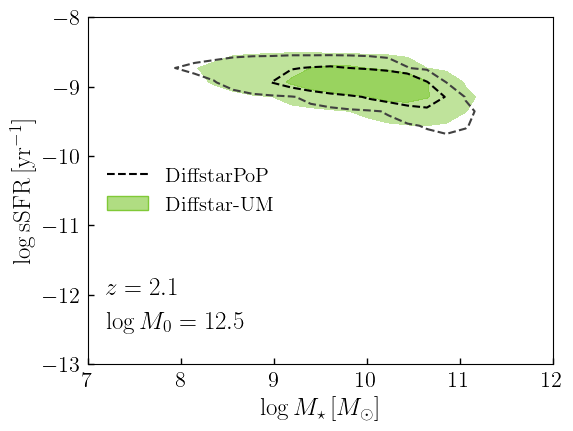

12.5 2.0266490707946287
9.92
nan


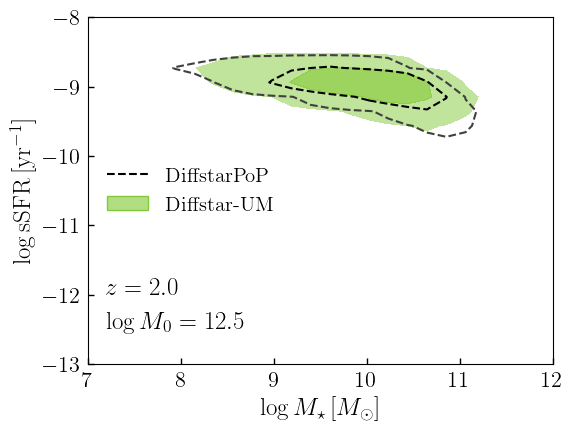

12.5 2.002356971812307
9.93
nan


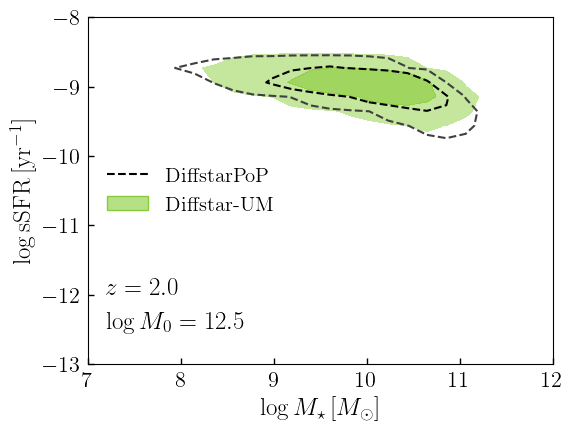

12.5 1.9706806682774862
9.96
nan


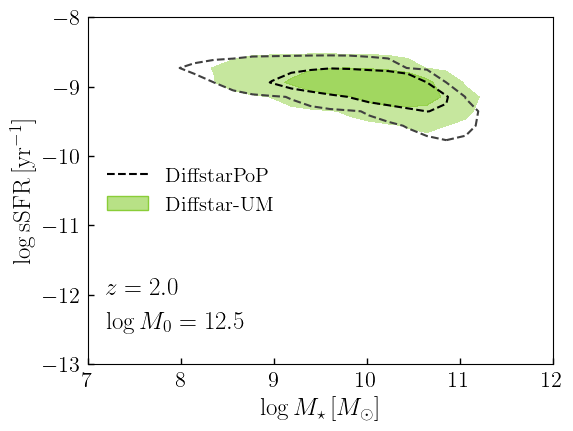

12.5 1.93978909062592
9.98
nan


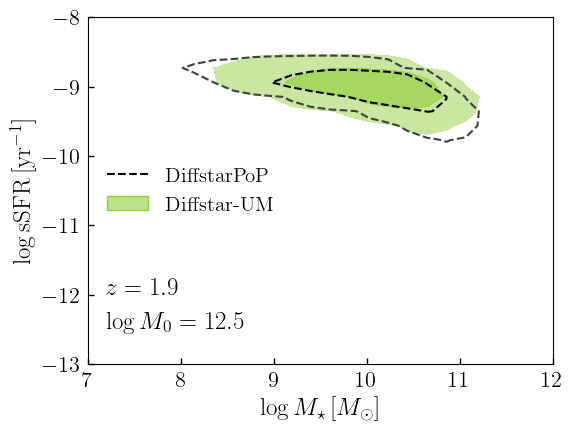

12.5 1.9096508852504683
10.0
nan


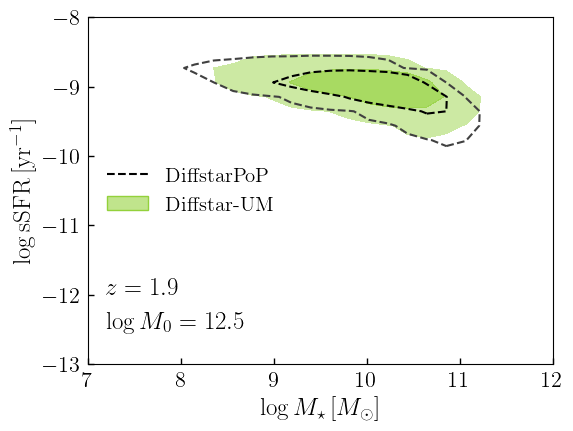

12.5 1.8802364041130433
10.02
nan


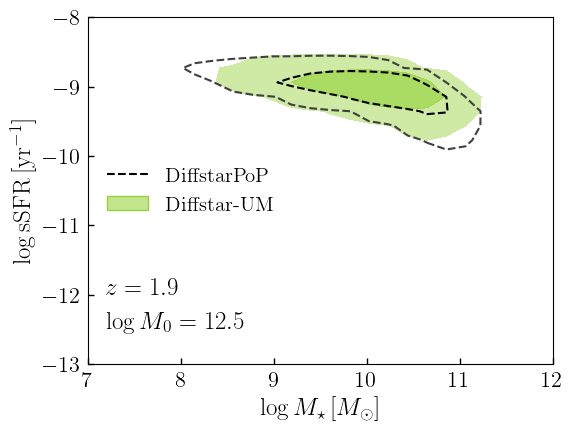

12.5 1.8515175734908202
10.04
nan


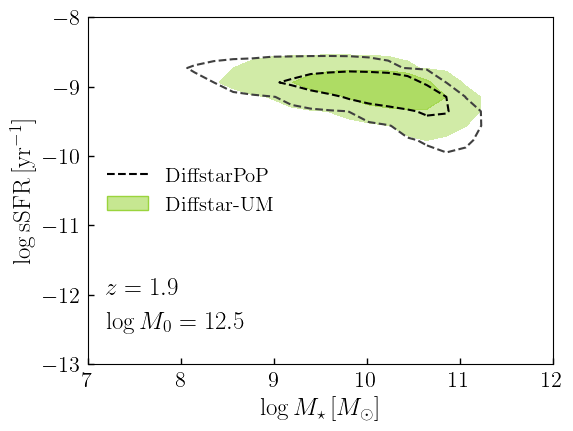

12.5 1.8165568463720843
10.07
nan


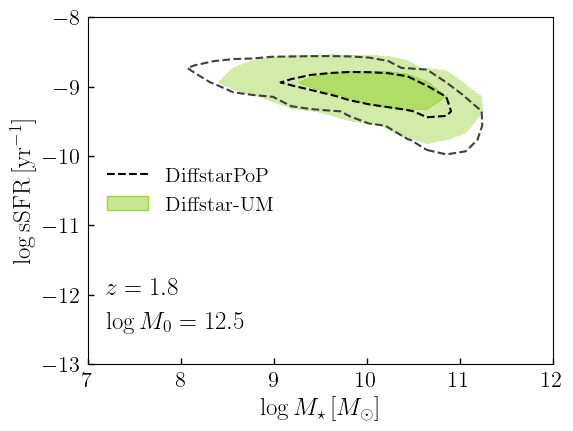

12.5 1.789307984497507
10.09
nan


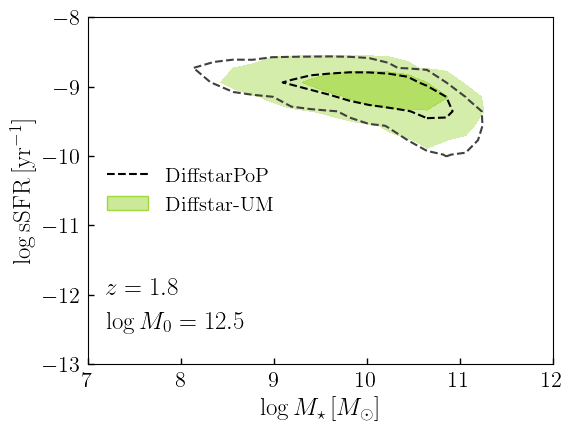

12.5 1.7561078134008234
10.11
nan


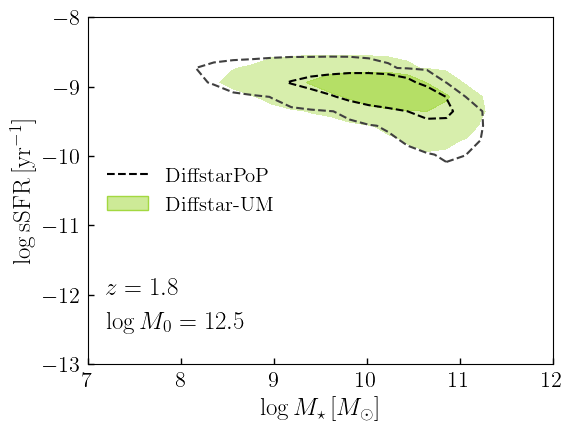

12.5 1.7302092082829221
10.13
nan


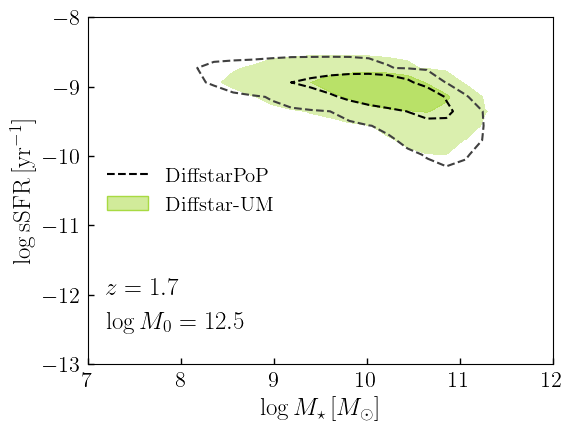

12.5 1.6986282803839976
10.15
nan


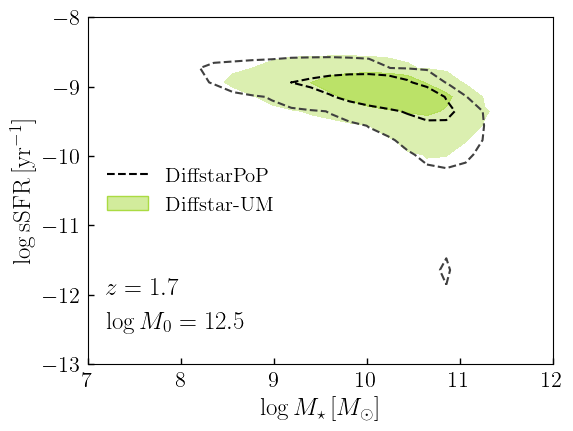

12.5 1.6678915217371184
10.18
nan


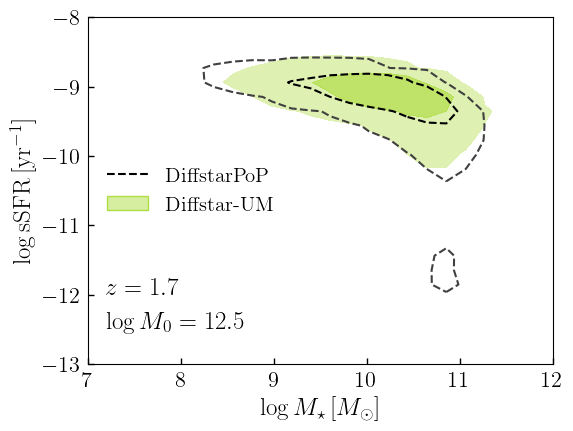

12.5 1.6379623441877367
10.2
nan


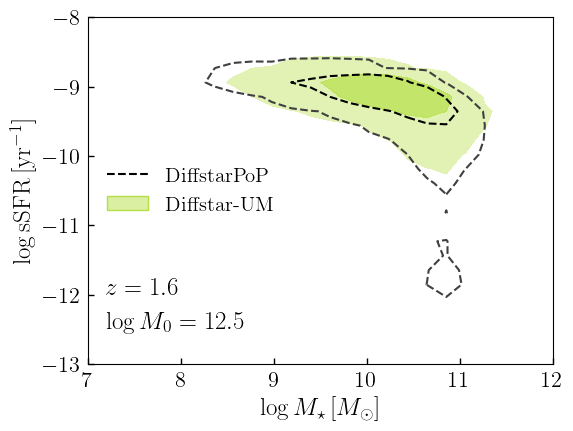

12.5 1.6088063108064117
10.22
nan


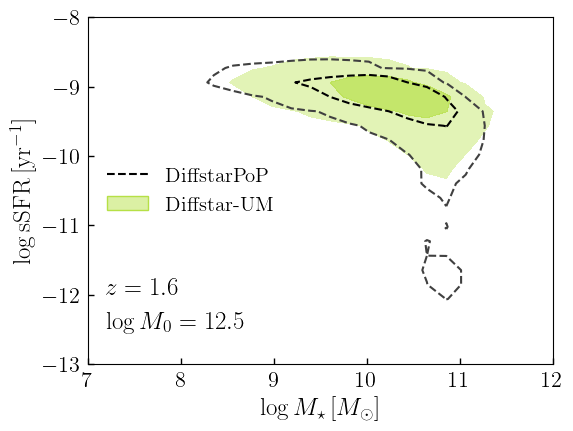

12.5 1.574794027948389
10.24
nan


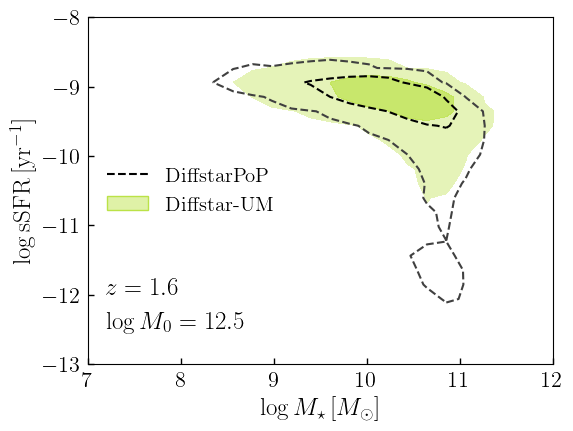

12.5 1.547227208692221
10.26
nan


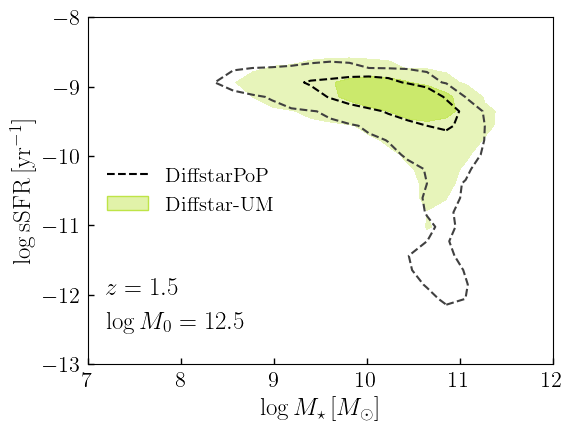

12.5 1.5150363617252194
10.28
nan


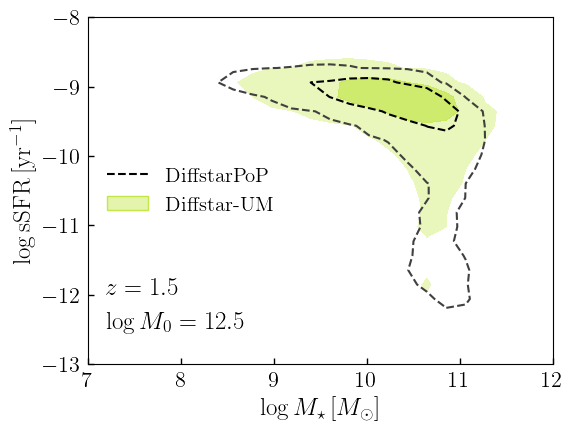

12.5 1.4837719820219124
10.3
nan


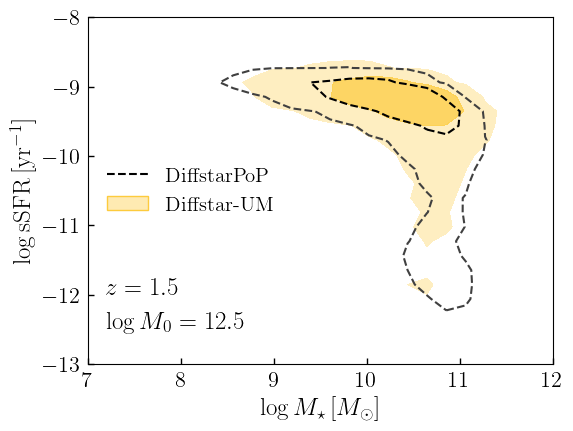

12.5 1.453390617925071
10.32
nan


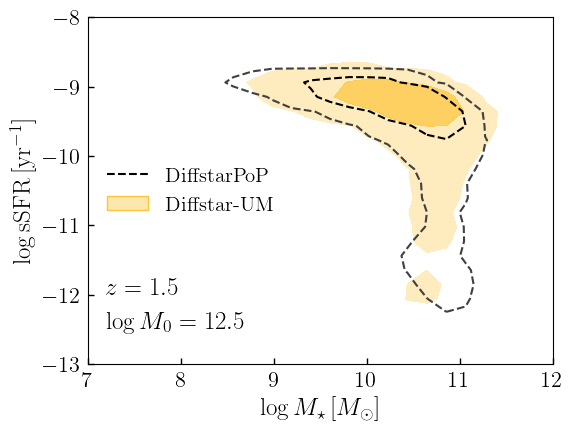

12.5 1.423851603397813
10.34
nan


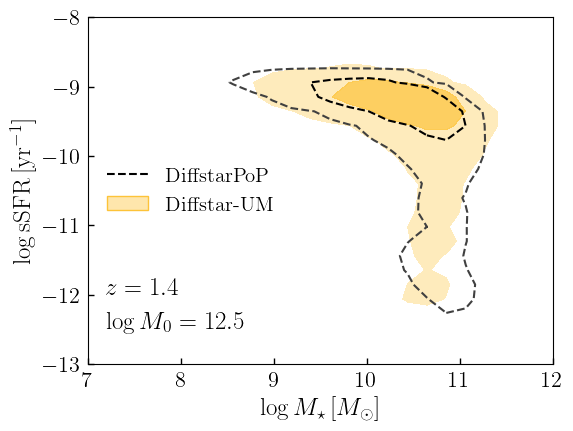

12.5 1.395116756566505
10.36
nan


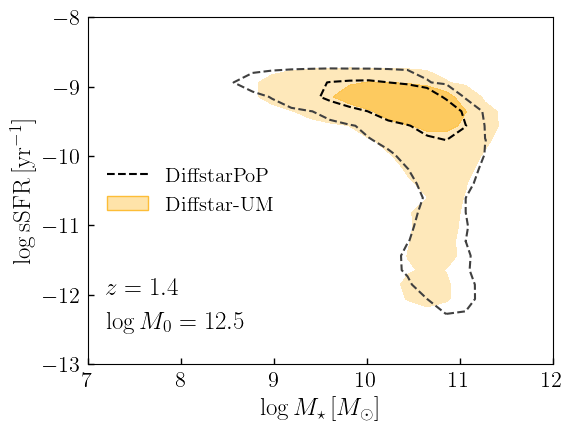

12.5 1.3625615232179442
10.38
nan


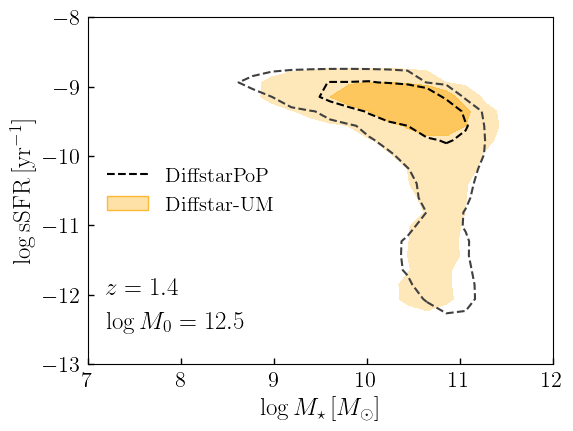

12.5 1.3354490620360584
10.4
nan


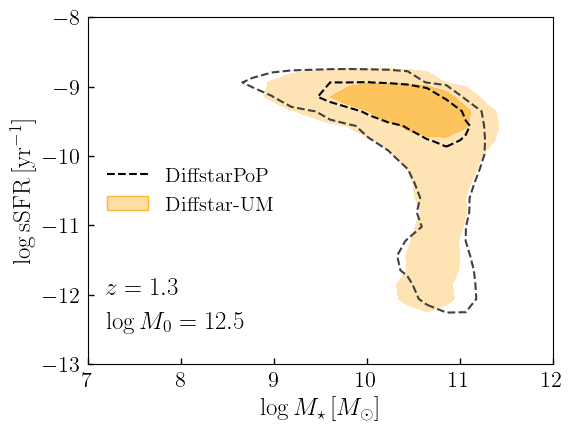

12.5 1.3046978576981727
10.41
nan


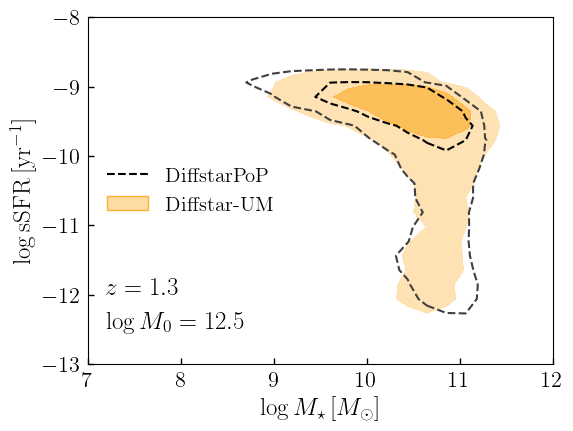

12.5 1.2706572128014941
10.43
nan


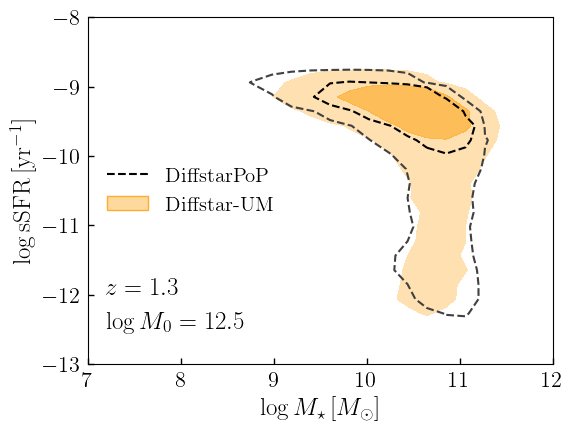

12.5 1.24178858569914
10.45
nan


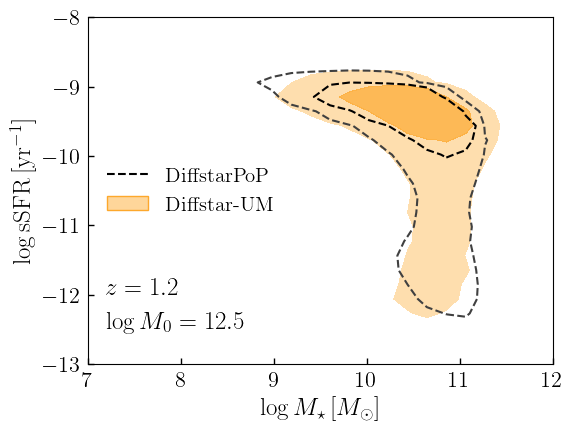

12.5 1.213733391243055
10.47
nan


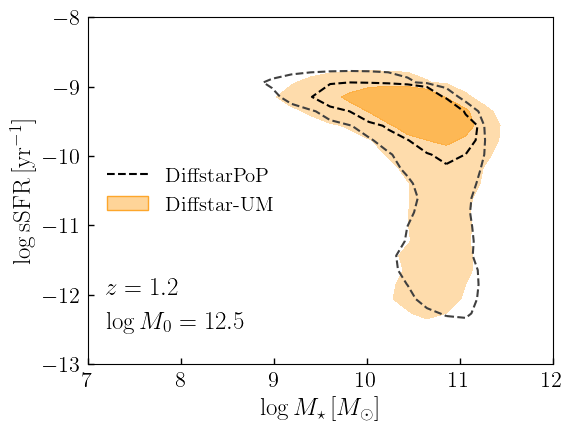

12.5 1.1826180079852109
10.48
nan


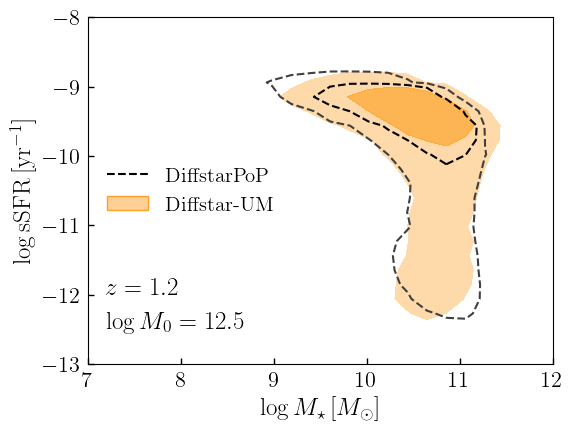

12.5 1.1524631567434145
10.5
nan


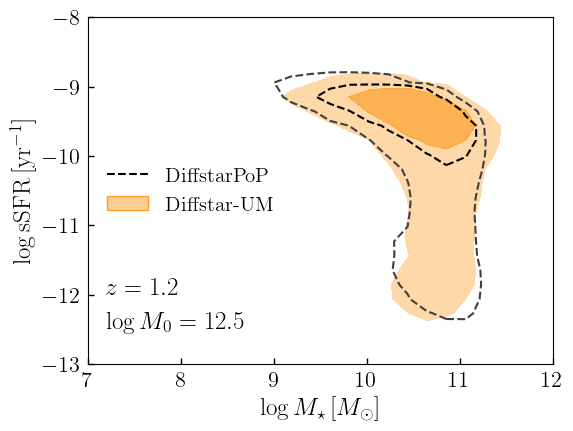

12.5 1.1196263023193873
10.52
nan


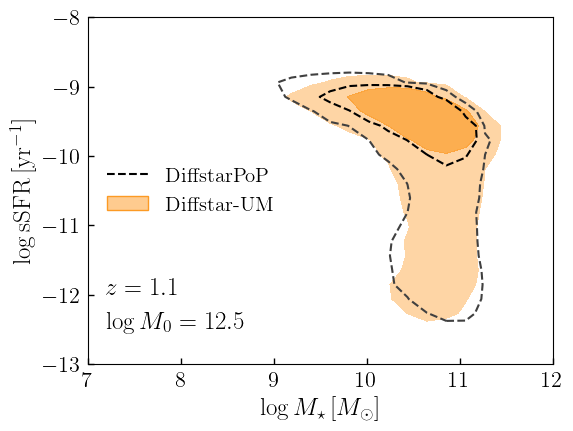

12.5 1.0913543045062977
10.53
nan


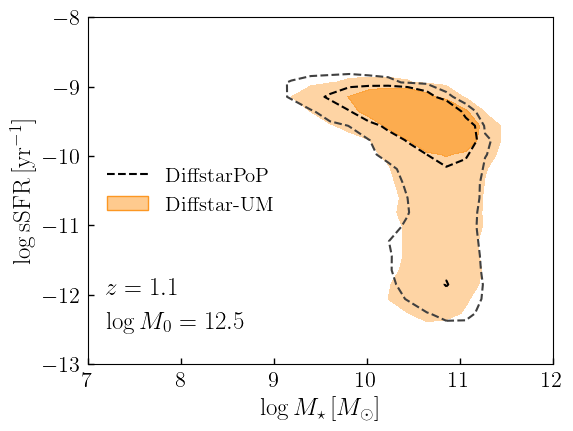

12.5 1.0605245802433465
10.55
nan


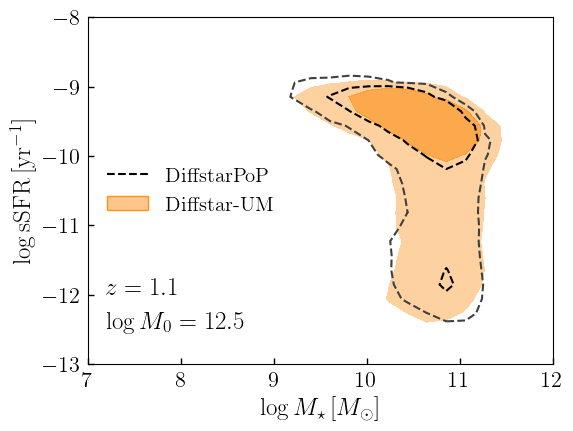

12.5 1.0306749543557128
10.56
nan


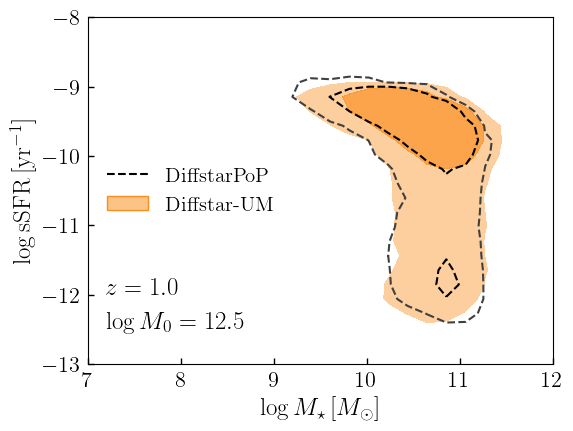

12.5 0.998595366951
10.58
nan


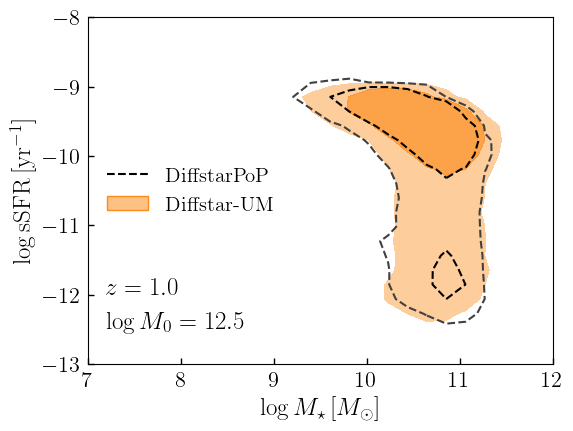

12.5 0.9706493495609776
10.59
nan


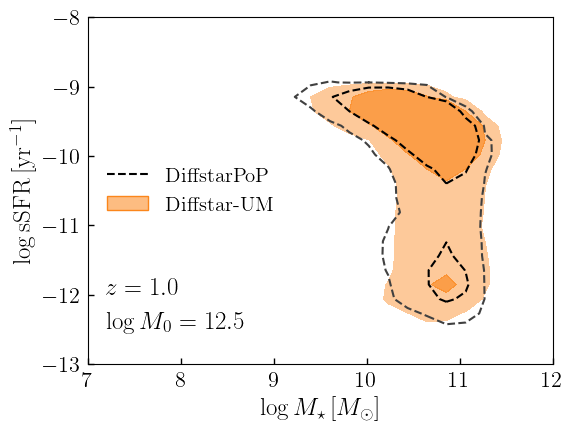

12.5 0.9405708076297298
10.61
nan


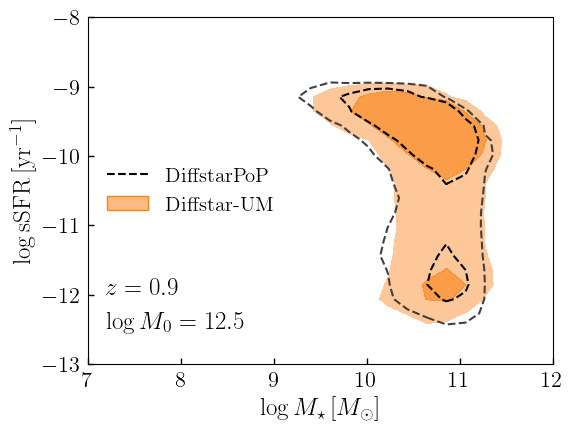

12.5 0.9086018993582455
10.62
nan


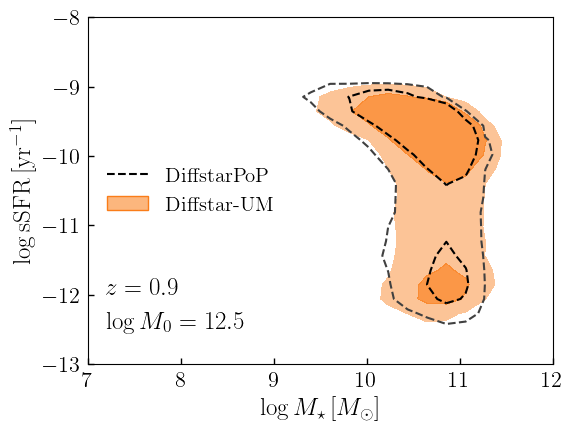

12.5 0.8777366354437223
10.63
nan


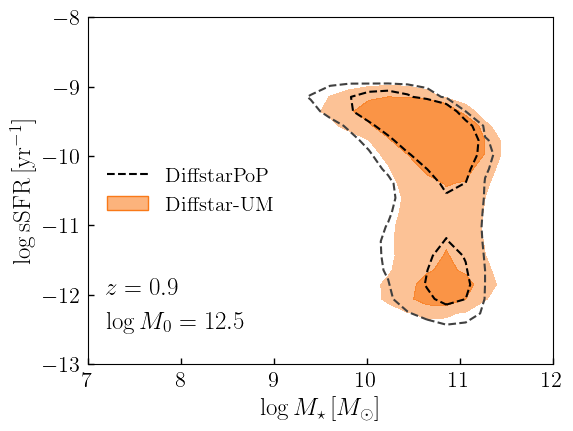

12.5 0.8479112224068129
10.65
nan


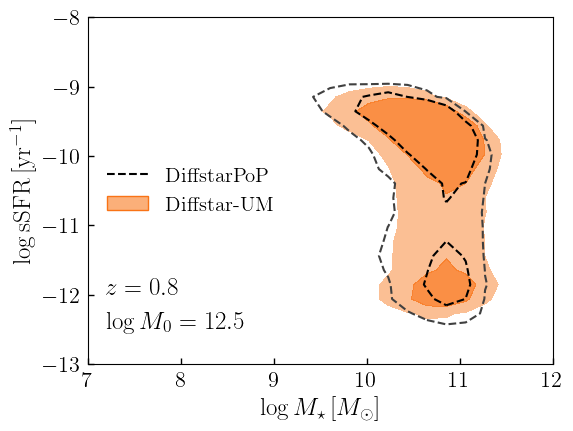

12.5 0.8190668468933079
10.66
nan


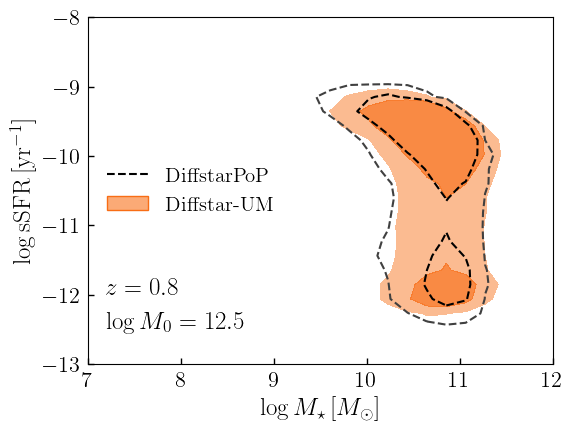

12.5 0.7886554020119209
10.67
nan


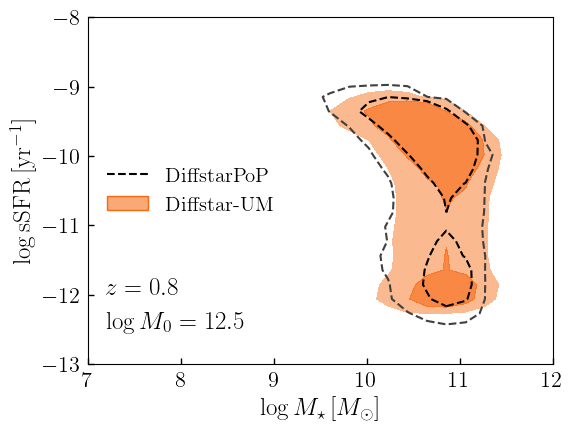

12.5 0.7568790117990879
10.68
nan


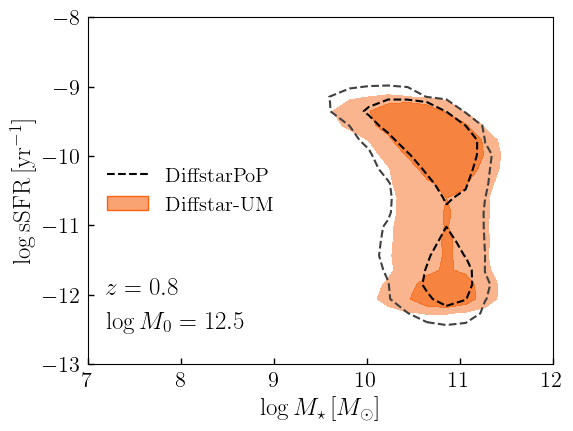

12.5 0.7262449851476577
10.69
nan


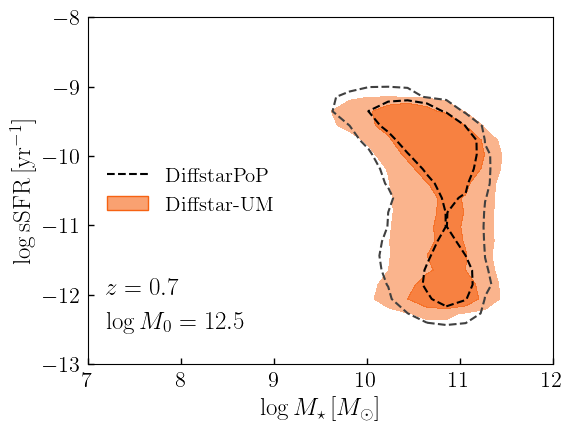

12.5 0.6966838385014489
10.7
nan


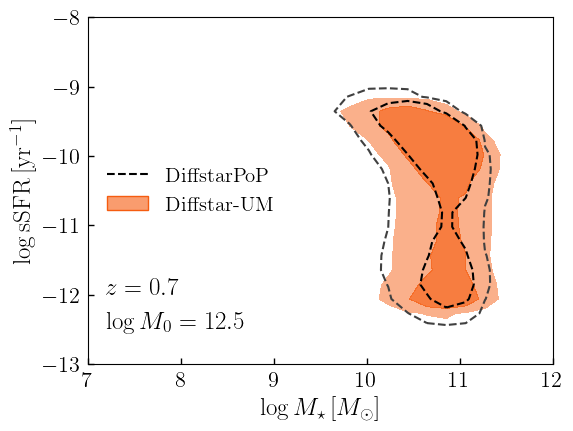

12.5 0.6659756113033419
10.71
nan


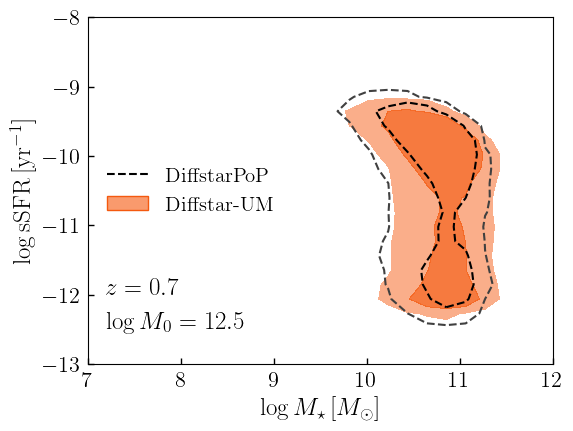

12.5 0.6363648142075694
10.72
nan


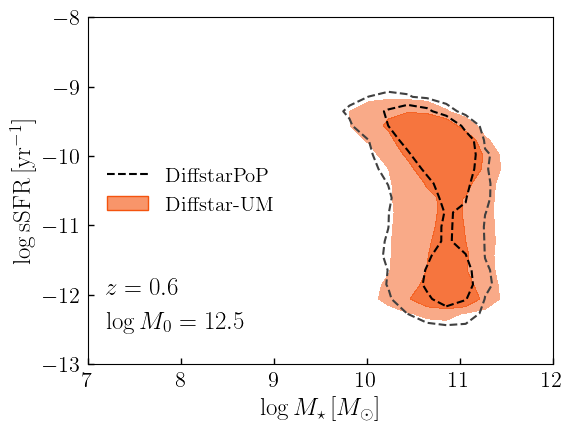

12.5 0.605780968067031
10.73
nan


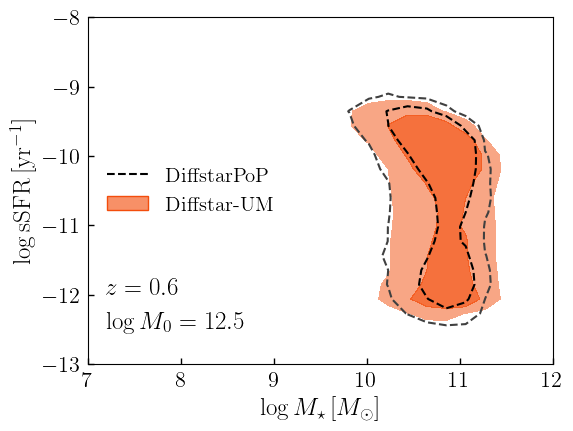

12.5 0.5763050958622952
10.74
nan


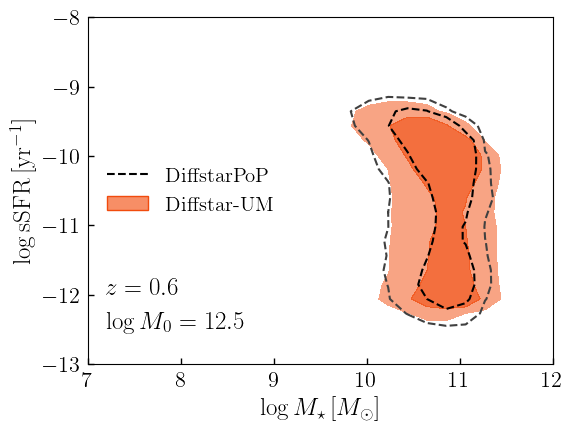

12.5 0.5460080999423912
10.75
nan


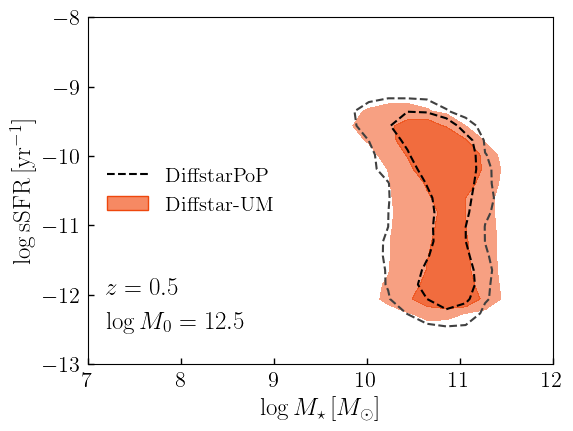

12.5 0.5150281769278837
10.75
nan


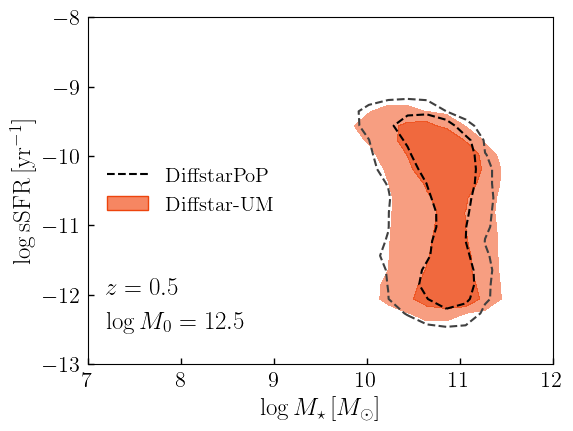

12.5 0.4852142059797738
10.76
nan


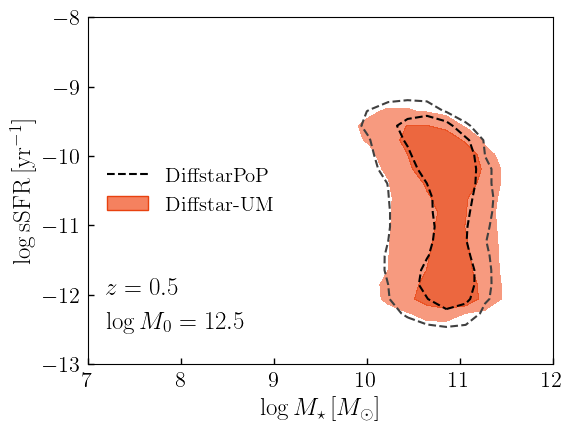

12.5 0.45483343483316874
10.77
nan


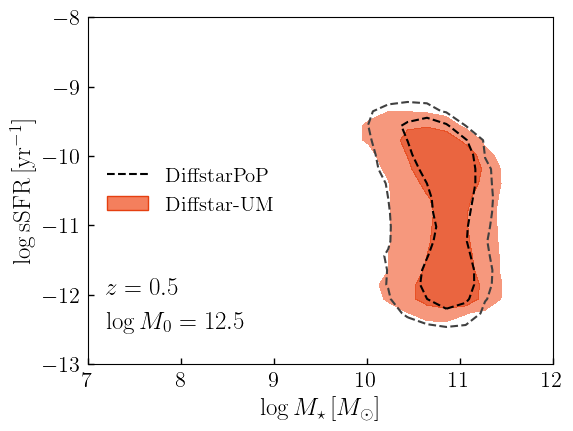

12.5 0.42400107140596144
10.78
nan


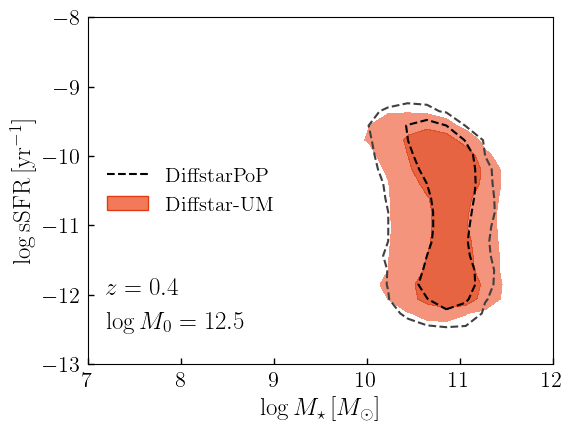

12.5 0.39435300706162857
10.78
nan


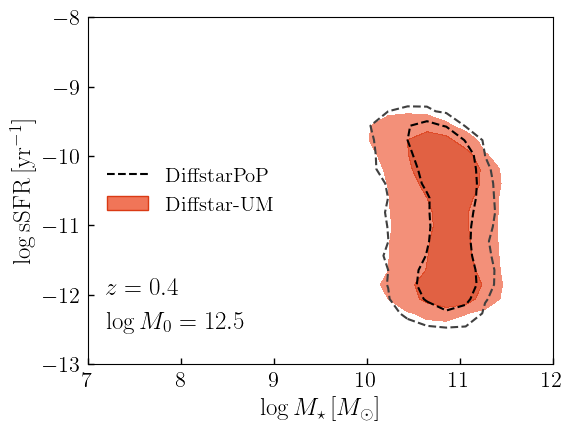

12.5 0.3643374042131193
10.79
nan


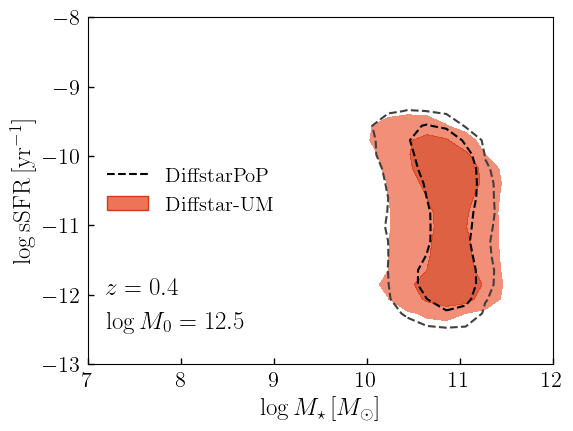

12.5 0.3326358337711671
10.79
nan


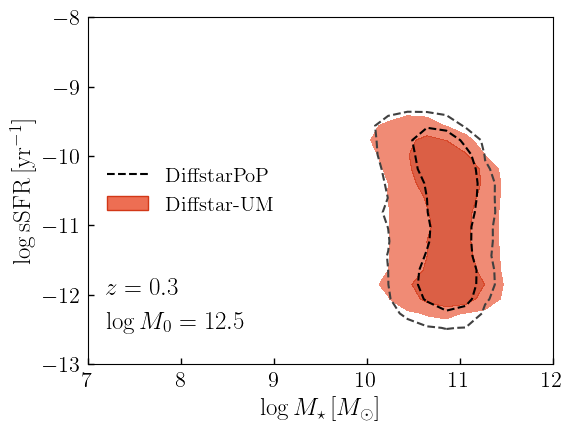

12.5 0.3035719388148142
10.8
nan


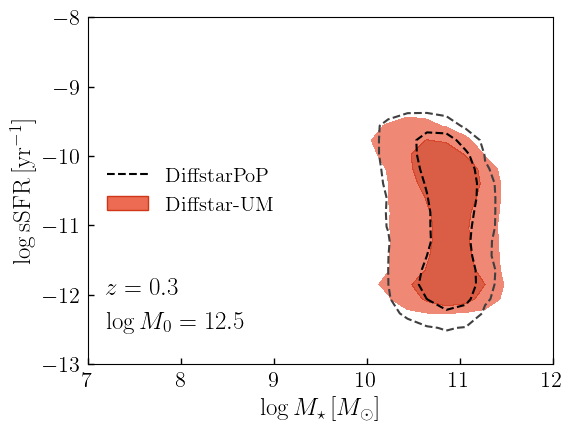

12.5 0.27298689520619124
10.81
nan


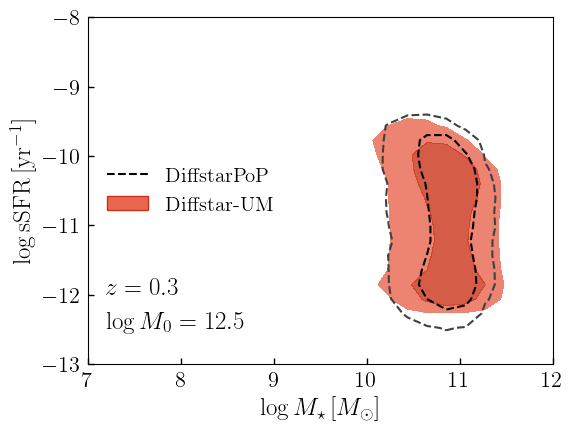

12.5 0.24236428944275734
10.81
nan


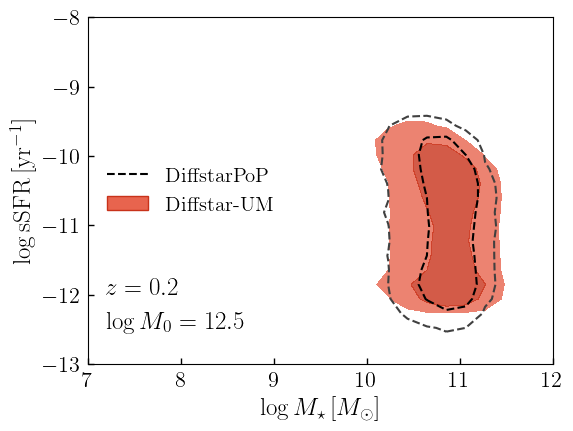

12.5 0.21176812260677474
10.82
nan


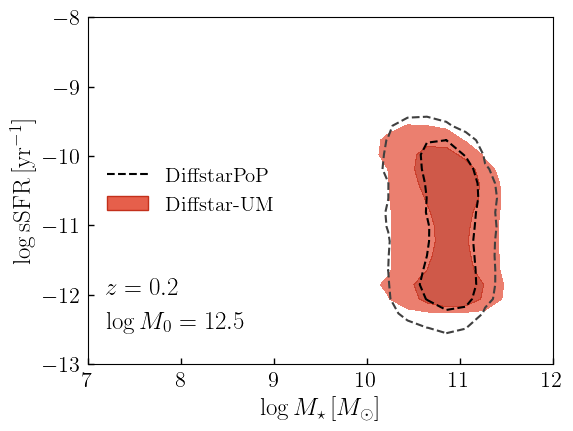

12.5 0.1812556506449588
10.82
nan


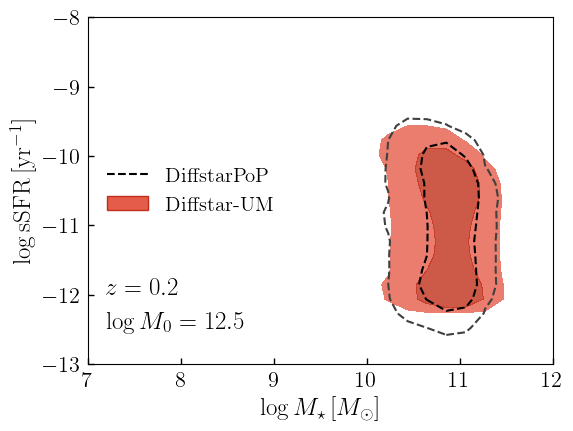

12.5 0.1519803269683838
10.83
nan


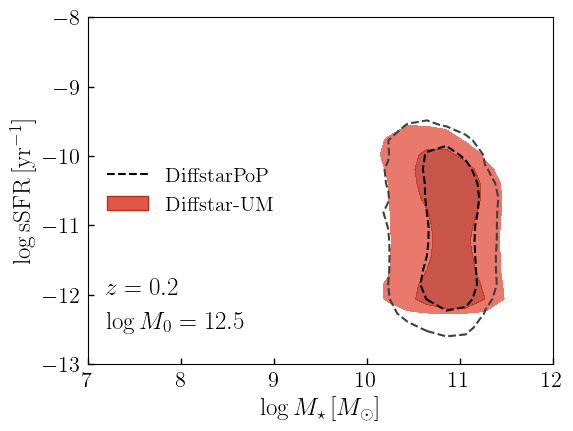

12.5 0.12173655790388731
10.83
nan


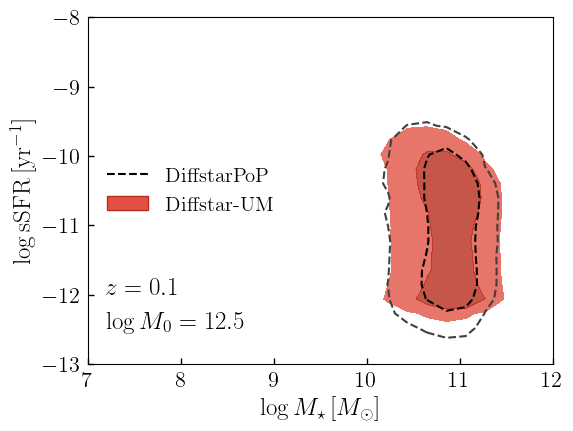

12.5 0.09070138939688771
10.83
nan


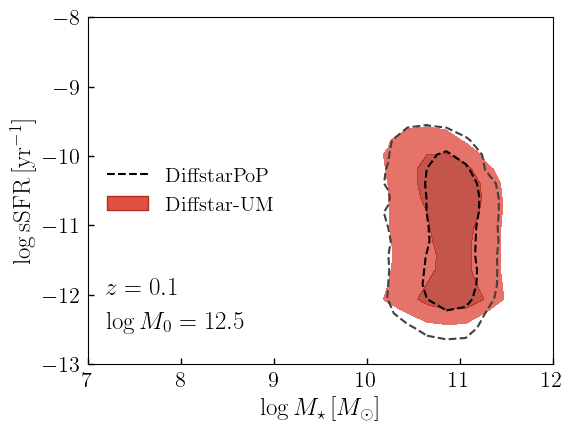

12.5 0.06097744987405092
10.84
nan


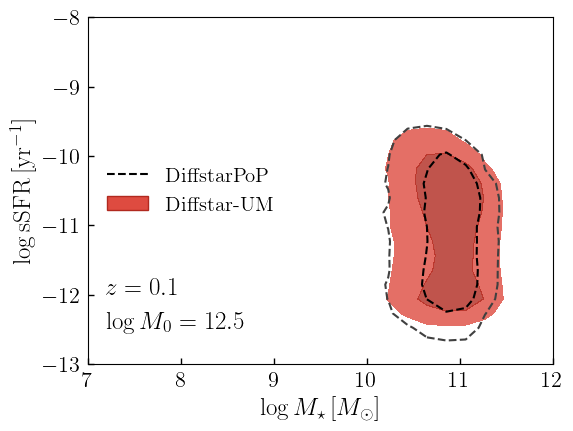

12.5 0.030609420547916037
10.84
nan


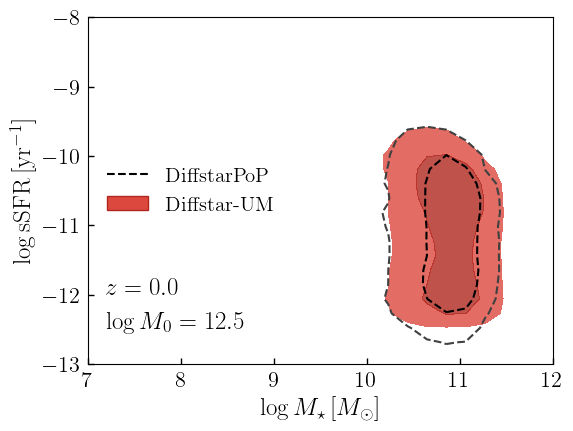

12.5 -0.00025703638540851655
10.85
nan


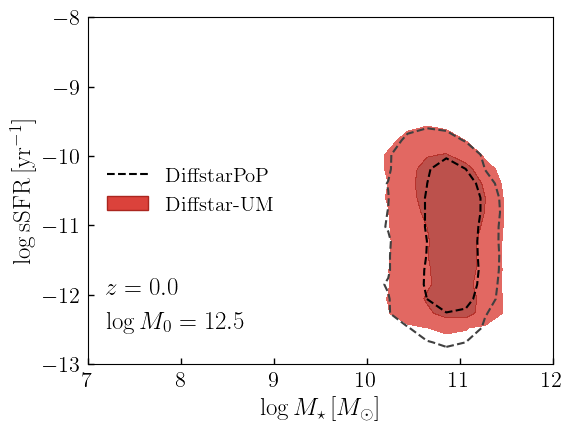

In [24]:


colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']
colors_test = plt.get_cmap("Greys")(np.linspace(0.3,0.7, 3))
colors_greys = plt.get_cmap("Greys")(np.array([0.8, 1.0]))
n_histories = int(5e4)
ran_key = jran.PRNGKey(0)

nbins_x = np.linspace(7, 12, 25)
nbins_y = np.linspace(-13, -8.0, 25)
        
# nbins_x = bins_mstar.copy()
# nbins_y = bins_ssfr.copy()

smooth = False
# for i, bin_id in enumerate([2,4,6]):

bin_id = 3
t_table = np.linspace(1.0, TODAY, 1000)
lgt = jnp.log10(t_table)
z_table = np.array([z_at_value(Planck13.age, x * u.Gyr, zmin=-1) for x in t_table])

t0 = time.time()
histories = draw_sfh_MIX(
    t_table,
    logm0_binmids[bin_id],
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id],
    p50.reshape(len(logm0_binmids),Nhalos)[bin_id],
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    #init_guess[0:N_PDF_Q],
    #init_guess[N_PDF_Q:N_PDF_Q+N_PDF_MS],
    #init_guess[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
    #init_guess[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
    outputs[0][0:N_PDF_Q],
    outputs[0][N_PDF_Q:N_PDF_Q+N_PDF_MS],
    outputs[0][N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
    outputs[0][N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
)

weights = histories[4].copy()
_params = np.zeros((Nhalos, 6))
_params[:, 0] = np.log10(TODAY)
_params[:, 1:3] = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id][:, 0:2]
_params[:, 3] = 3.5
_params[:, 4:6] = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id][:, 2:4]

mah_histories = _calc_halo_history_vmap(lgt, *_params.T)

_mask = (logmpeak > logm0_binmids[bin_id] - logm0_bin_widths[bin_id]) 
_mask &= (logmpeak < logm0_binmids[bin_id] + logm0_bin_widths[bin_id])
mah_histories_SMDPL = _calc_halo_history_vmap(lgt, *mah_params_arr[_mask].T)

histories_SMDPL = sm_sfr_history_diffstar_scan_XsfhXmah_vmap(
    t_table,
    jnp.log10(t_table),
    _get_dt_array(t_table),
    mah_params_arr[_mask][:, np.array([1,2,4,5])],
    u_fit_params_arr[_mask][:,np.array([0,1,2,4])],
    u_fit_params_arr[_mask][:,5:9],
    index_select,
    index_high,
    fstar_tdelay,
)
t1 = time.time()
print("time i", t1-t0)

_ids = np.argmin(np.subtract.outer(z_table, np.linspace(0, 3.0, 100))**2, axis=0)[::-1]

# for j, t_id in enumerate(t_sel_hists[::-1]):
for j, t_id in enumerate(_ids):

    # j = 0
    # t_id = _ids[j]
    print(logm0_binmids[bin_id], z_table[t_id])

    _fact = 1.5
    fig, ax = plt.subplots(1, 1, figsize=(4*_fact,3*_fact))

    xdata = np.log10(histories[0][:, t_id])
    print(np.round(np.average(xdata, weights=np.array(weights)),2))
    ydata = np.log10(histories[1][:, t_id] / histories[0][:, t_id])

    density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, weights=weights, level=0.68, linestyles=['--'], colors=[colors_greys[1]])
    density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, weights=weights, level=0.95, linestyles=['--'], colors=[colors_greys[0]])

    xdata = np.log10(histories_SMDPL[0][:, t_id])
    ydata = np.log10(histories_SMDPL[1][:, t_id] / histories_SMDPL[0][:, t_id])
    print(np.round(np.mean(xdata),2))
    # density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, level=0.68, linestyles=['--'], colors=[colors[4]])
    # density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, level=0.95, linestyles=['--'], colors=[colors[4]])
    # density_contourf(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, levels=[0.68, 0.95], linestyles=['--'], colors=[colors[4]])
    # colors_ = plt.get_cmap("RdYlGn")(np.linspace(0.0,1.0, 10))
    colors_ = np.concatenate((
        np.array(plt.get_cmap("RdYlGn")(np.linspace(0.1,0.4, int(len(_ids)/2)))),
        np.array(plt.get_cmap("RdYlGn")(np.linspace(0.6, 0.9, int(len(_ids)/2)))),
    ))[::-1]
    colors_ = [
        adjust_lightness(colors_[j], amount=1.1),
        adjust_lightness(colors_[j], amount=0.8),
        # colors_[j],
    ]
    density_contourf(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, levels=[0.0, .68, 0.95], colors=colors_, alpha=0.8)

    ax.text(7.2, -12.5, r"$\log M_0 = %.1f$"%logm0_binmids[bin_id], fontsize=18)
    ax.text(7.2, -12.5+0.5, r"$z = %.1f$"%abs(z_table[t_id]), fontsize=18)
    ax.set_xlabel(r'$\log M_\star\,[M_\odot]$')
    ax.set_ylabel(r'$\log \rm{sSFR}\,[\rm{yr}^{-1}]$')
    ax.set_xticks(np.arange(7,12.1,1))
    ax.set_yticks(np.arange(-13,-7.9,1))

    fig.subplots_adjust(wspace=0.4, hspace=0.3)

    legend_elements = [
        Line2D([0], [0], color='k', ls='--', label=r'DiffstarPoP'),
        Patch(facecolor=colors_[0], edgecolor=colors_[1], label=r'Diffstar-UM')
    ]
    ax.legend(handles=legend_elements, loc="center left")
    fig.savefig("mstar_ssfr_plots/mstar_vs_ssfr_diffstarpop_smdpl_m0%.2f_zevol%d.png"%(logm0_binmids[bin_id], j), bbox_inches="tight", dpi=300)
    plt.show()
    #break
        

248289
time i 33.04466390609741
11.5 0.4967190594981553
9.41
9.45


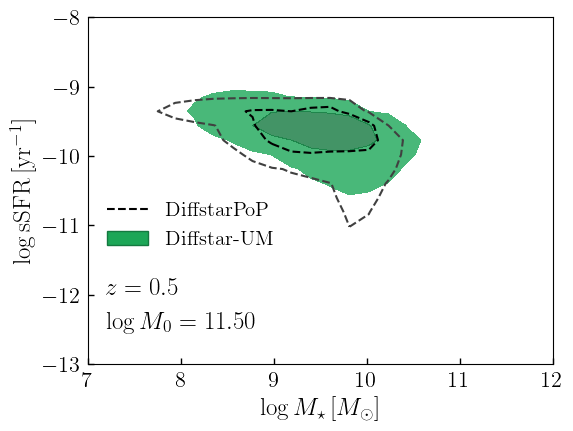

247072
time i 35.94131922721863
11.527272727272727 0.4967190594981553
9.46
9.51


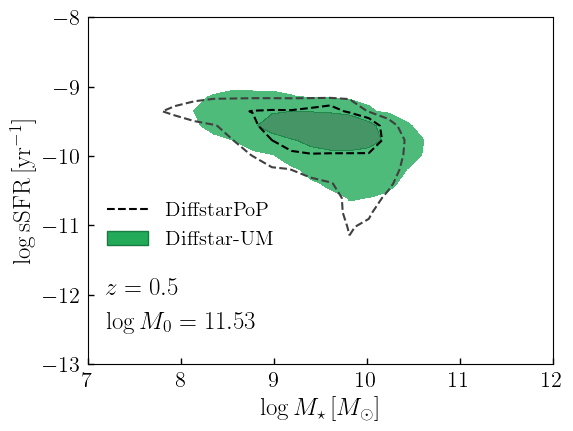

246076
time i 35.808281898498535
11.554545454545455 0.4967190594981553
9.52
9.56


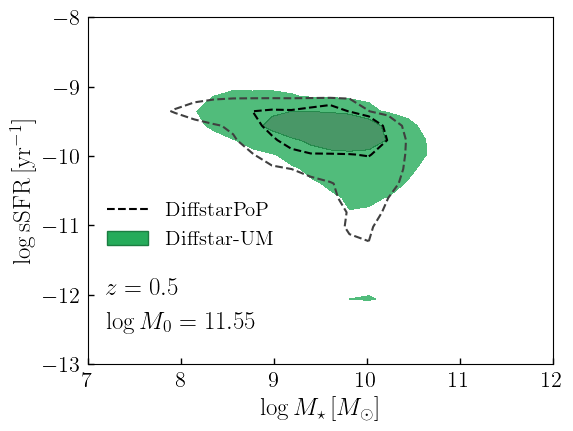

244989
time i 32.544718980789185
11.581818181818182 0.4967190594981553
9.58
9.62


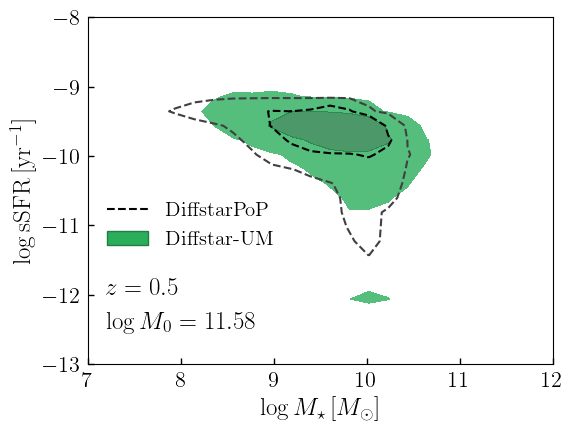

243996
time i 32.2905752658844
11.60909090909091 0.4967190594981553
9.64
9.68


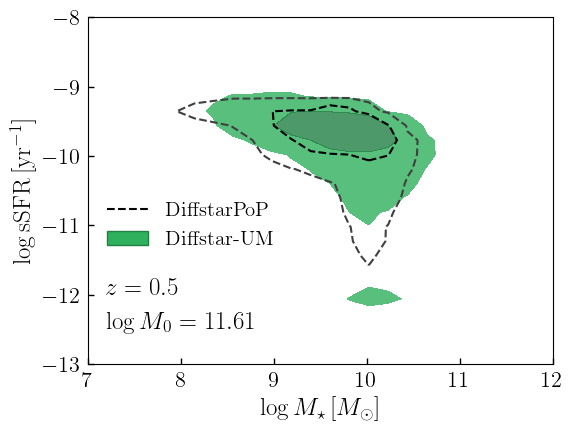

242995
time i 32.585806131362915
11.636363636363637 0.4967190594981553
9.7
9.73


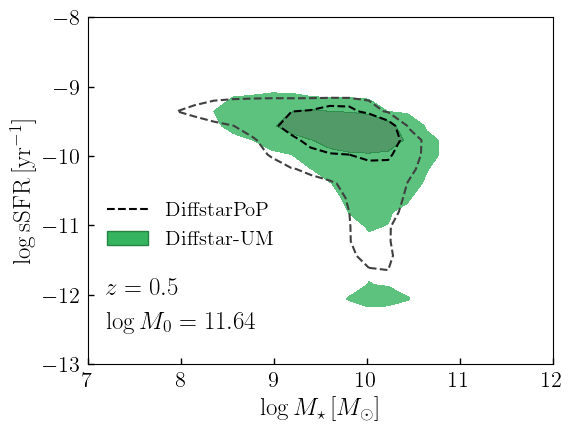

241799
time i 32.29919409751892
11.663636363636364 0.4967190594981553
9.74
9.79


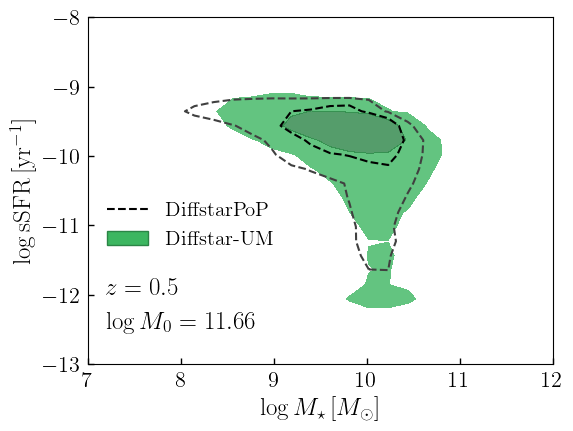

241074
time i 33.18273186683655
11.690909090909091 0.4967190594981553
9.8
9.84


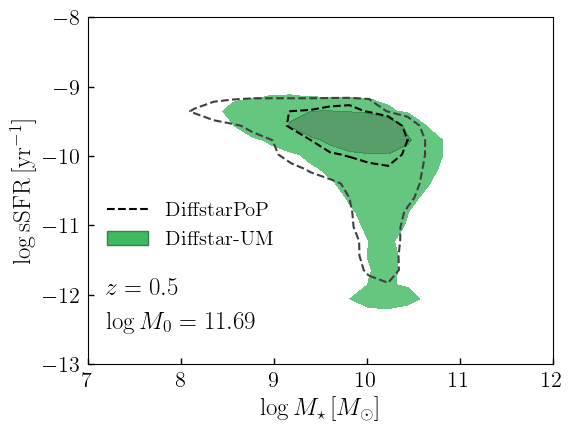

239937
time i 33.3137149810791
11.718181818181819 0.4967190594981553
9.84
9.89


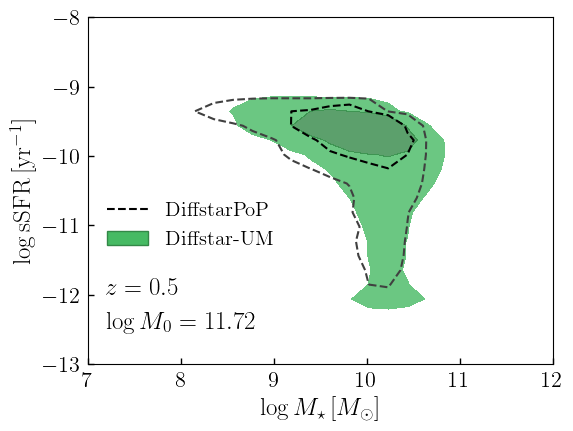

238517
time i 32.41894006729126
11.745454545454546 0.4967190594981553
9.9
9.94


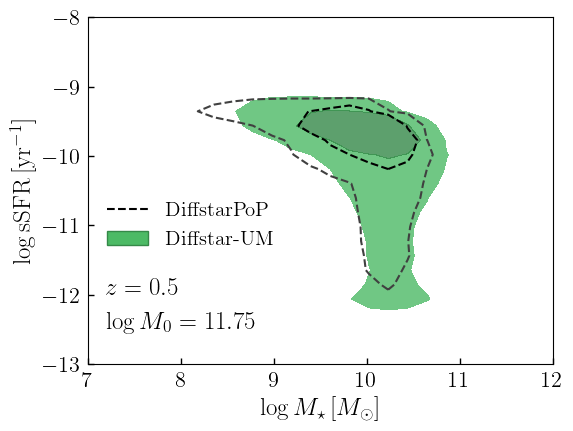

237400
time i 34.6963849067688
11.772727272727273 0.4967190594981553
9.96
9.99


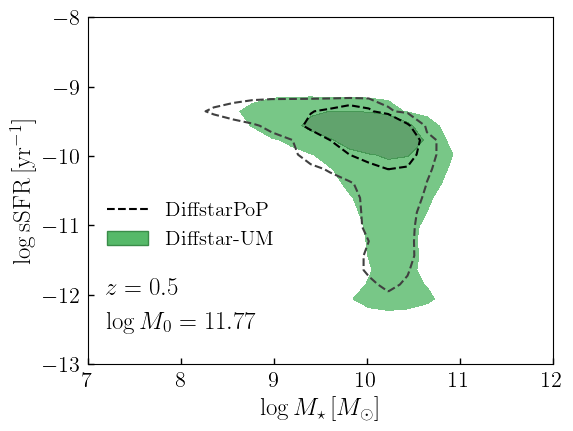

236236
time i 35.76346802711487
11.8 0.4967190594981553
10.0
10.04


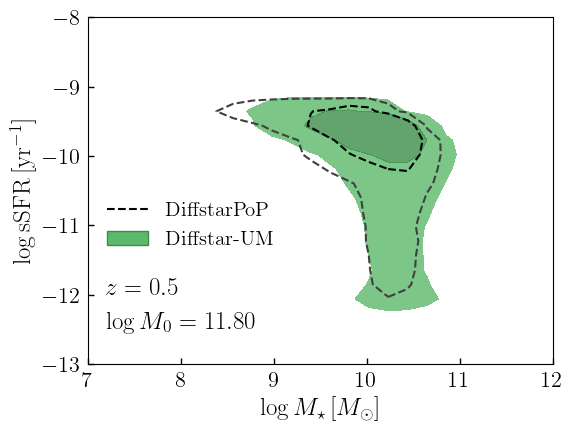

235239
time i 36.22163987159729
11.827272727272728 0.4967190594981553
10.05
10.09


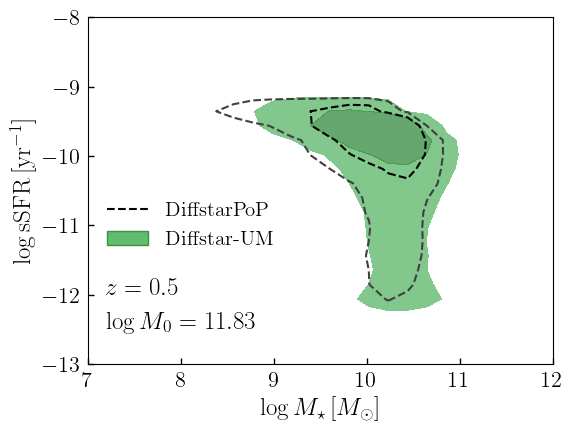

234030
time i 35.53209590911865
11.854545454545454 0.4967190594981553
10.09
10.13


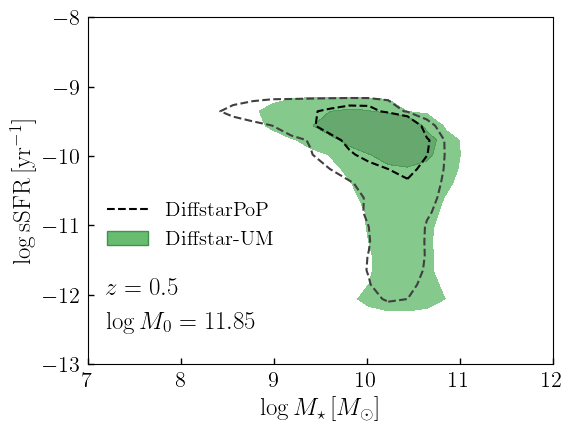

232869
time i 32.85458302497864
11.881818181818181 0.4967190594981553
10.14
10.18


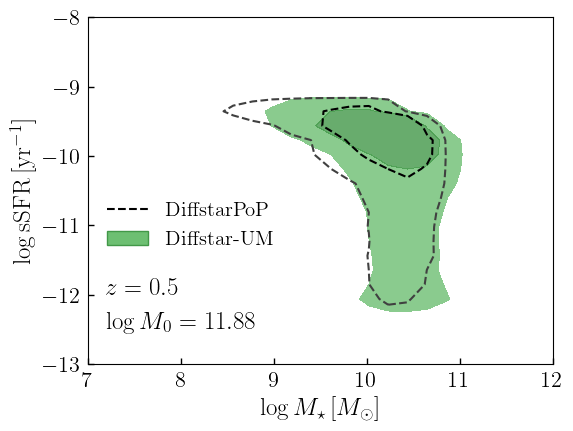

232007
time i 35.28318166732788
11.909090909090908 0.4967190594981553
10.18
10.22


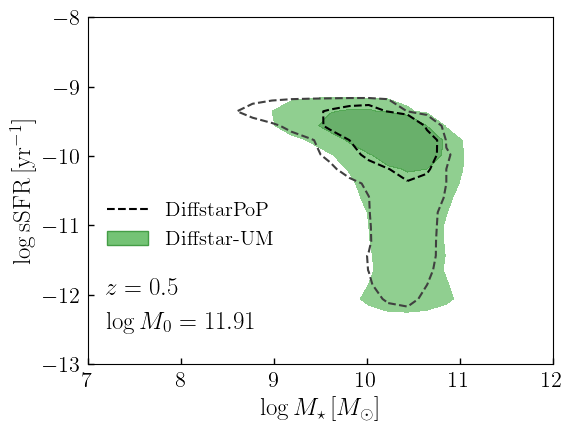

229517
time i 31.886751890182495
11.936363636363636 0.4967190594981553
10.22
10.26


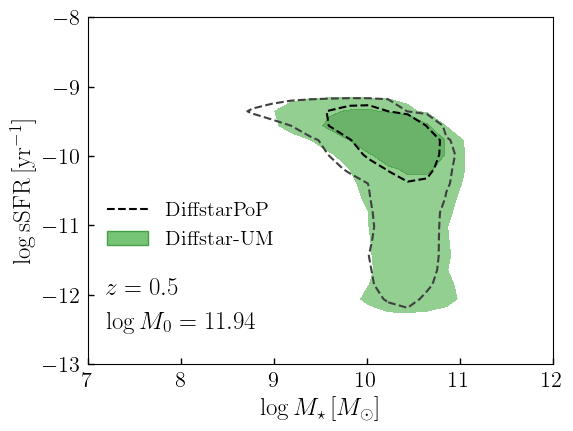

225577
time i 31.087207317352295
11.963636363636363 0.4967190594981553
10.26
10.3


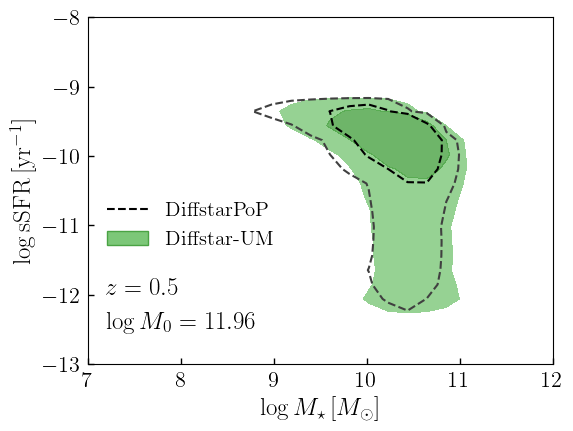

220379
time i 30.565059900283813
11.99090909090909 0.4967190594981553
10.29
10.33


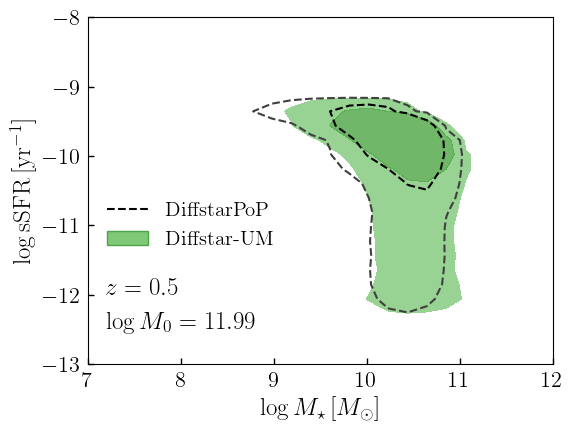

213561
time i 30.58565402030945
12.018181818181818 0.4967190594981553
10.33
10.37


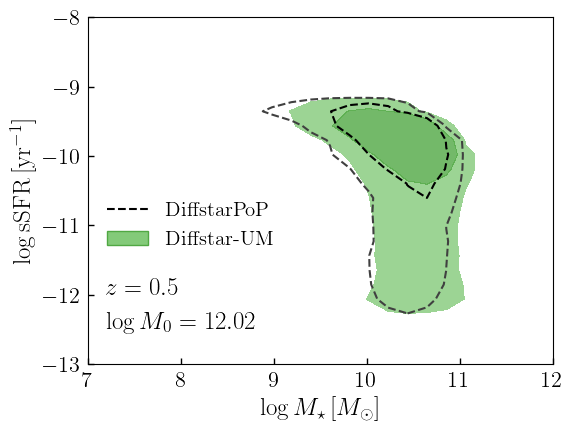

206205
time i 29.53087615966797
12.045454545454545 0.4967190594981553
10.36
10.4


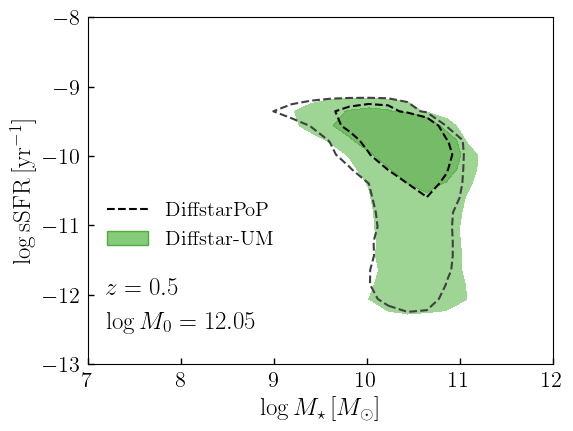

197192
time i 28.47782301902771
12.072727272727272 0.4967190594981553
10.39
10.43


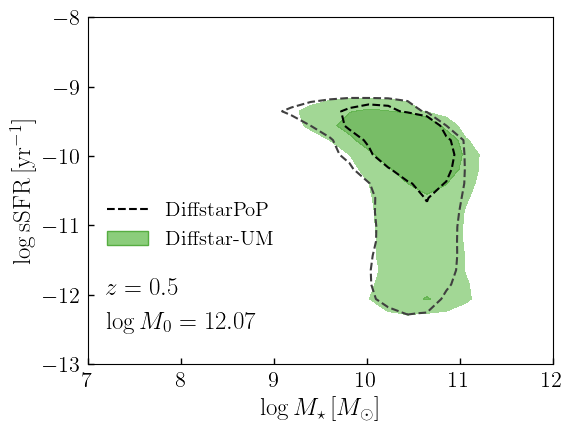

187239
time i 26.866316080093384
12.1 0.4967190594981553
10.43
10.46


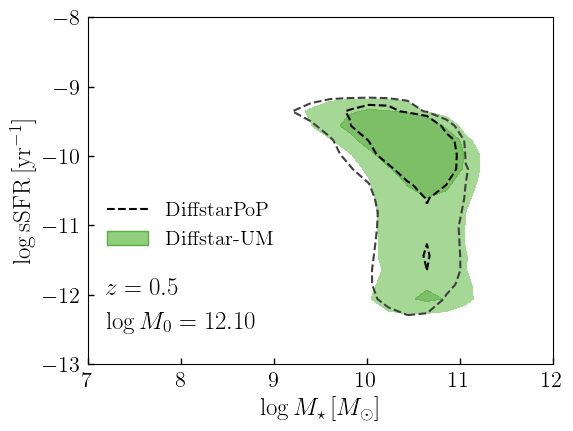

176799
time i 25.981723070144653
12.127272727272727 0.4967190594981553
10.46
10.49


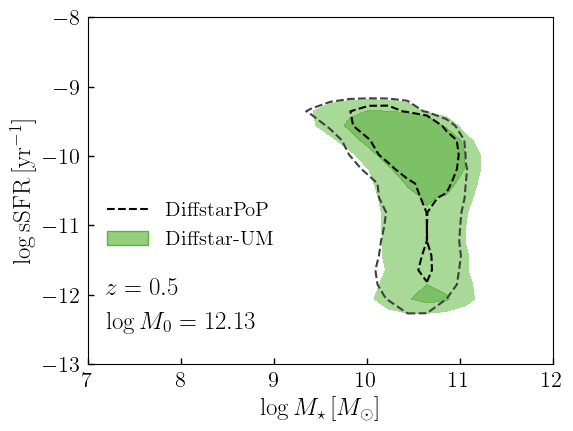

167198
time i 25.214722871780396
12.154545454545454 0.4967190594981553
10.49
10.52


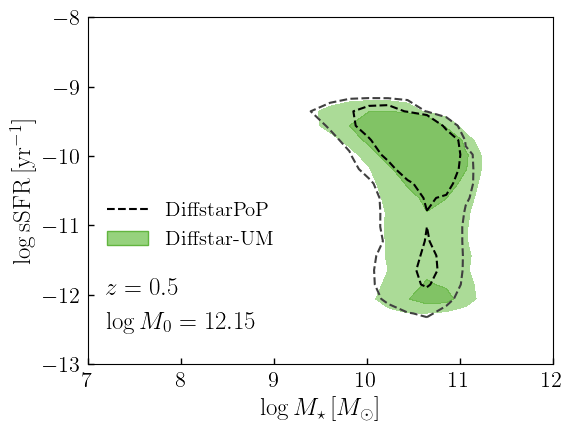

157971
time i 24.37512707710266
12.181818181818182 0.4967190594981553
10.51
10.55


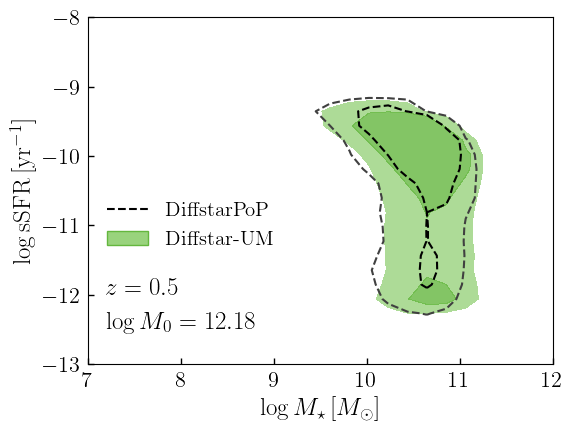

149075
time i 23.449568033218384
12.209090909090909 0.4967190594981553
10.54
10.57


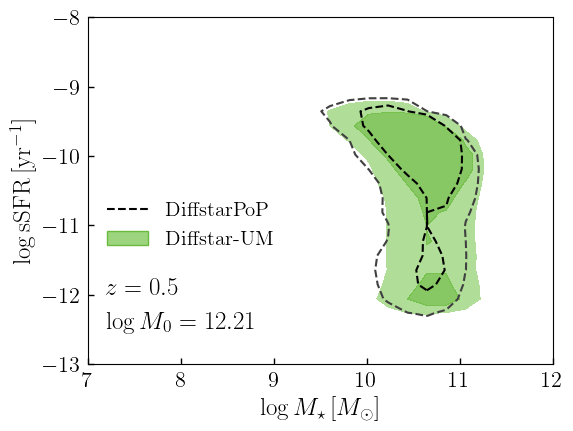

140804
time i 22.74255108833313
12.236363636363636 0.4967190594981553
10.56
10.6


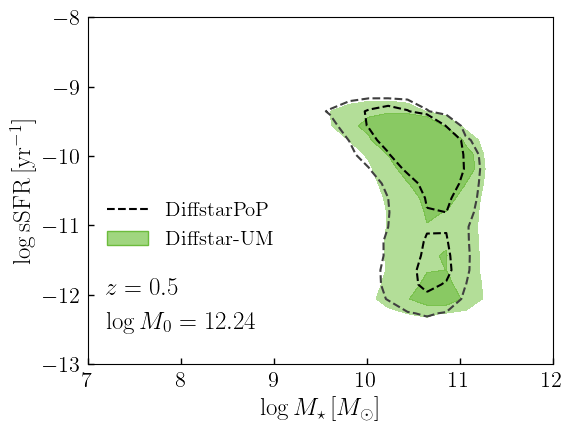

132886
time i 25.891751050949097
12.263636363636364 0.4967190594981553
10.59
10.62


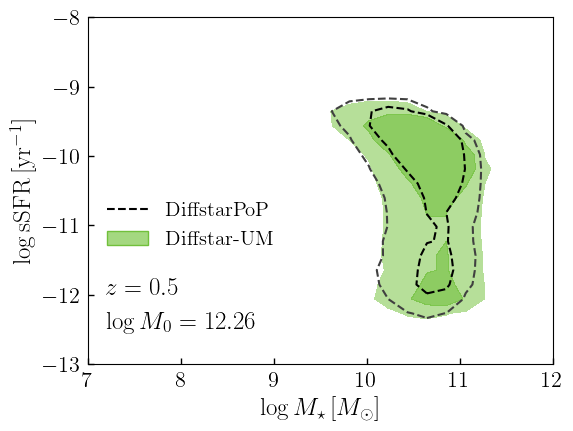

125390
time i 23.096938848495483
12.290909090909091 0.4967190594981553
10.61
10.64


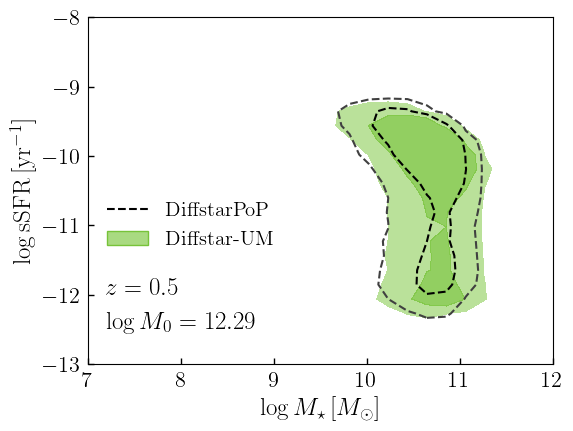

118333
time i 21.75967001914978
12.318181818181818 0.4967190594981553
10.64
10.66


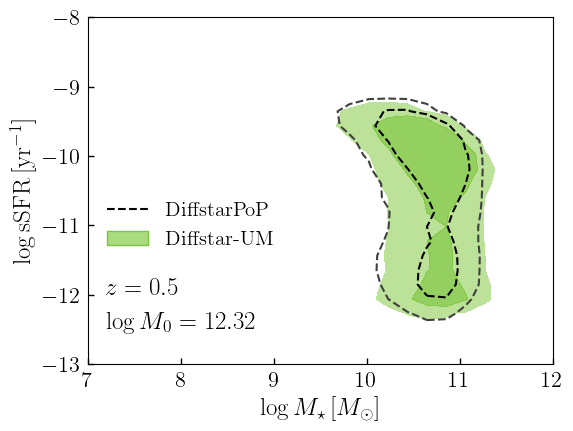

111714
time i 20.32430911064148
12.345454545454546 0.4967190594981553
10.66
10.68


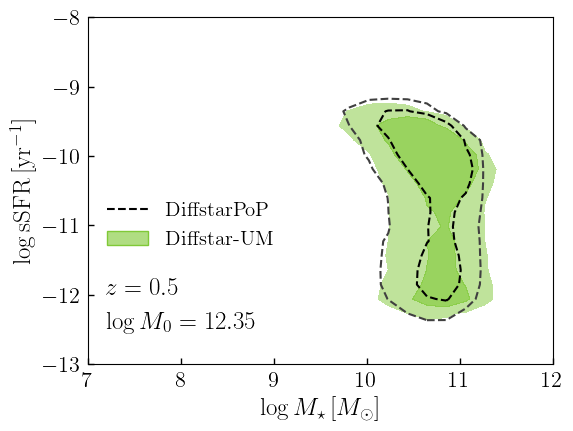

105272
time i 19.248760223388672
12.372727272727273 0.4967190594981553
10.68
10.7


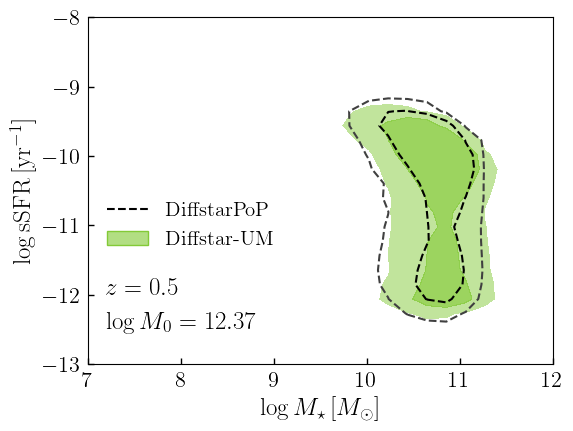

99362
time i 18.570878982543945
12.4 0.4967190594981553
10.69
10.72


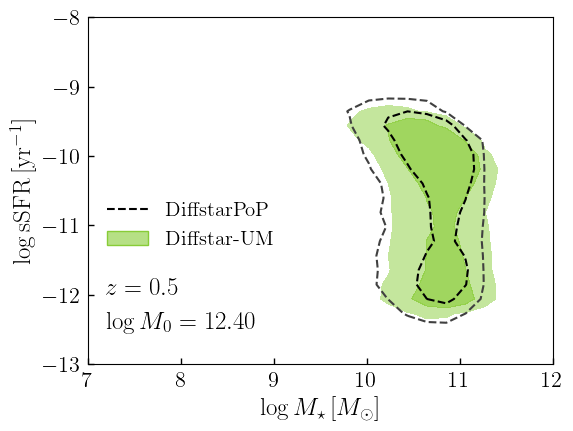

93895
time i 18.05602788925171
12.427272727272728 0.4967190594981553
10.71
10.74


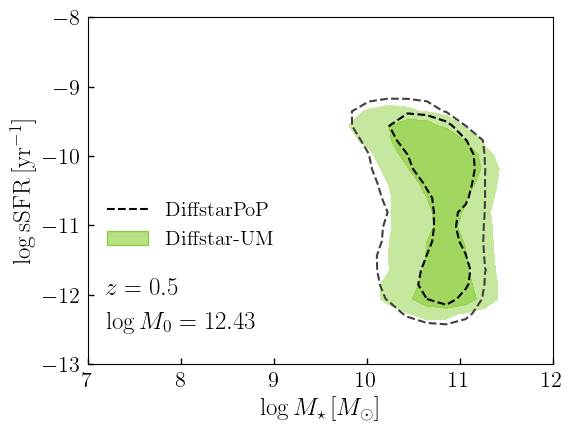

88600
time i 19.95570993423462
12.454545454545455 0.4967190594981553
10.73
10.75


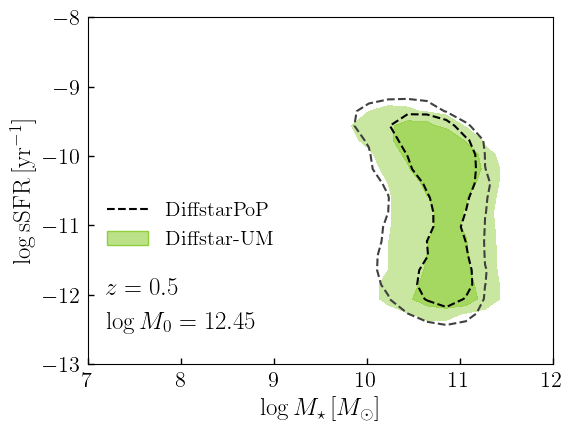

83526
time i 18.19024682044983
12.48181818181818 0.4967190594981553
10.75
10.77


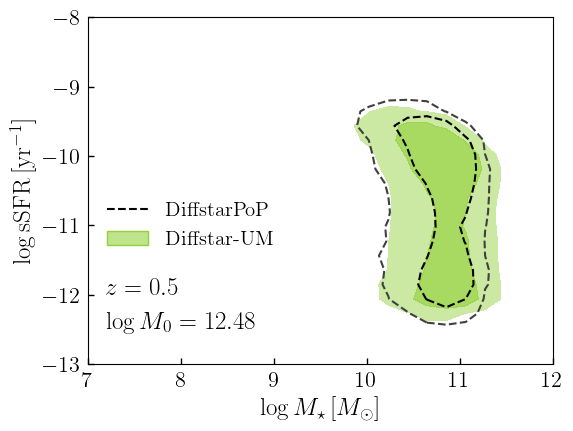

78830
time i 16.617081880569458
12.509090909090908 0.4967190594981553
10.76
10.78


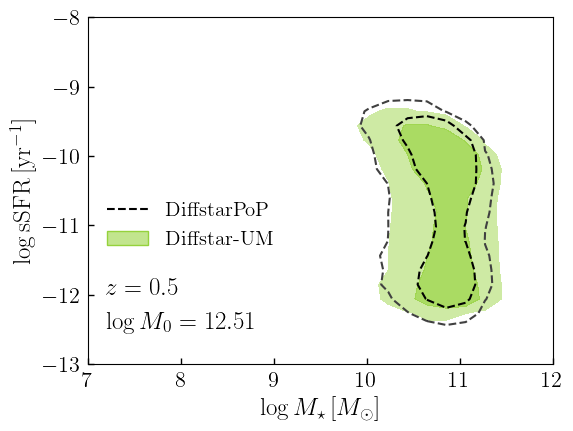

74237
time i 15.85019302368164
12.536363636363635 0.4967190594981553
10.78
10.8


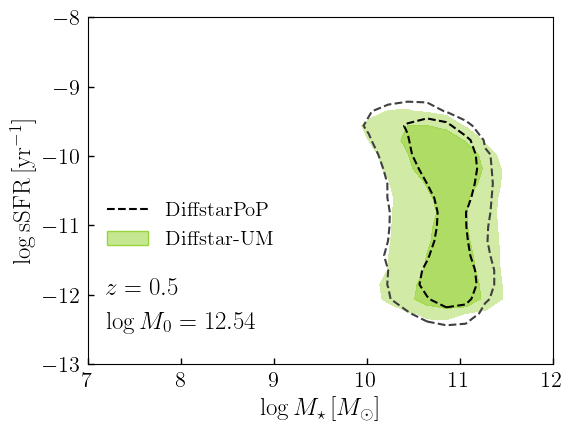

70112
time i 15.407371997833252
12.563636363636363 0.4967190594981553
10.79
10.81


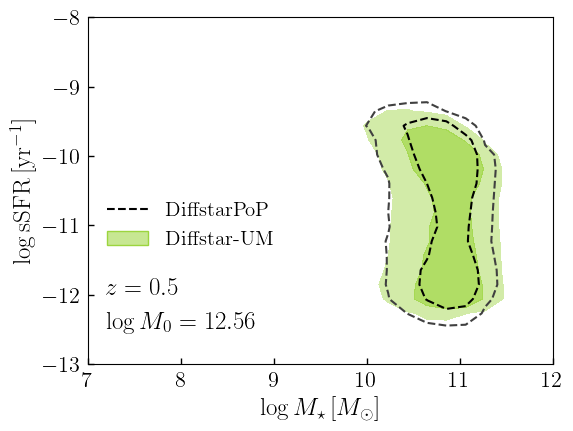

66174
time i 15.563367128372192
12.59090909090909 0.4967190594981553
10.8
10.82


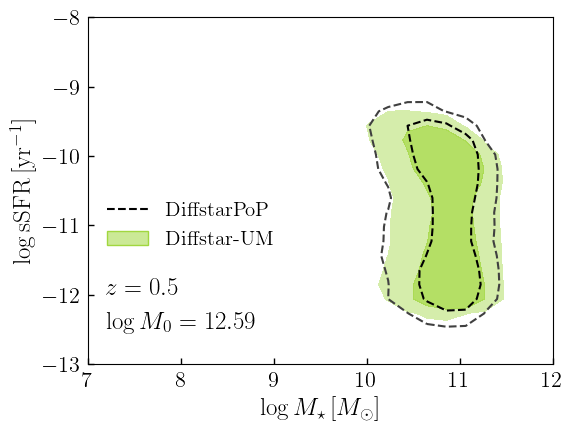

62596
time i 14.700525999069214
12.618181818181817 0.4967190594981553
10.81
10.83


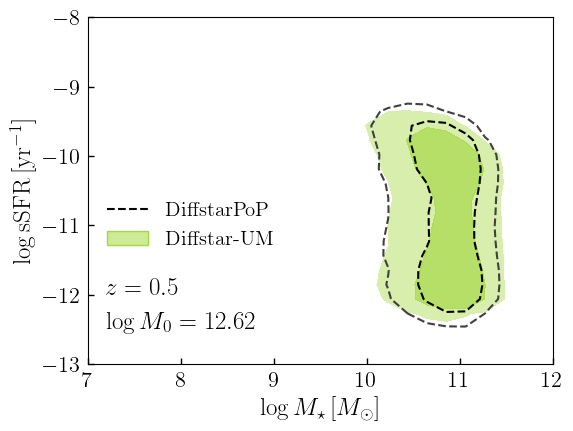

59032
time i 14.152740001678467
12.645454545454545 0.4967190594981553
10.82
10.84


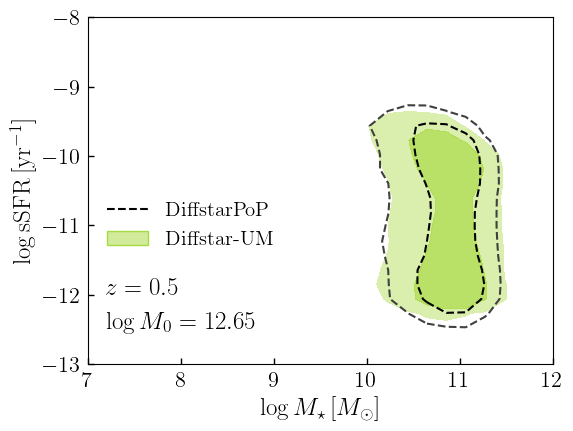

55628
time i 13.730354070663452
12.672727272727272 0.4967190594981553
10.84
10.84


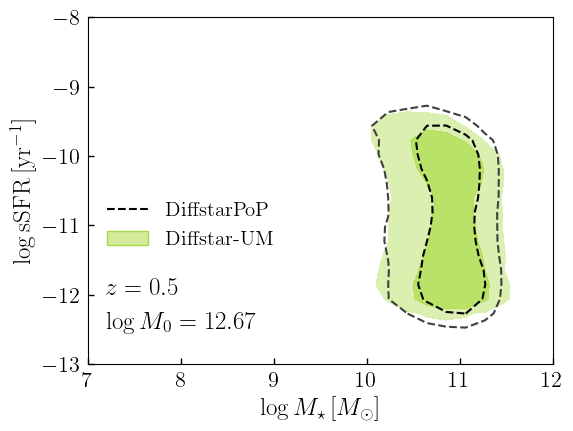

52332
time i 14.407365083694458
12.7 0.4967190594981553
10.84
10.85


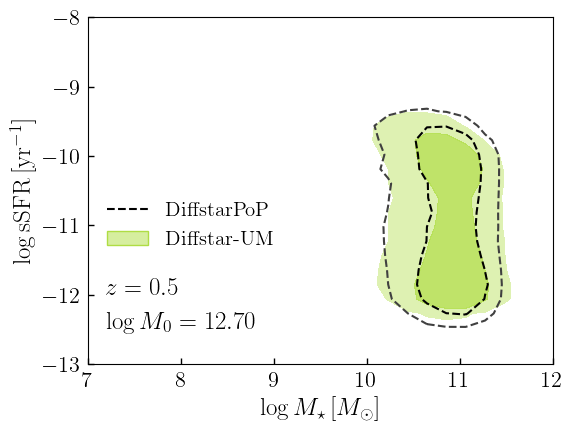

49442
time i 13.865944147109985
12.727272727272727 0.4967190594981553
10.85
10.86


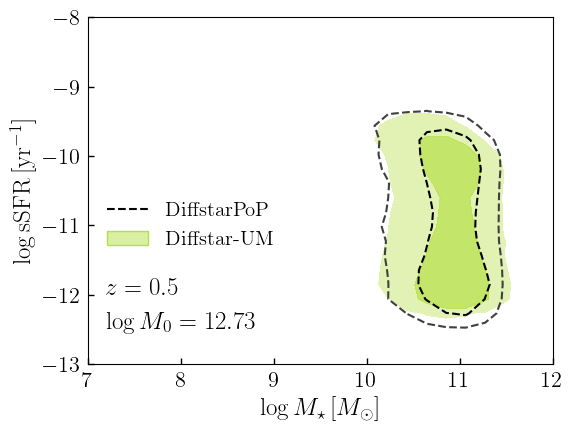

46551
time i 12.549966812133789
12.754545454545454 0.4967190594981553
10.86
10.86


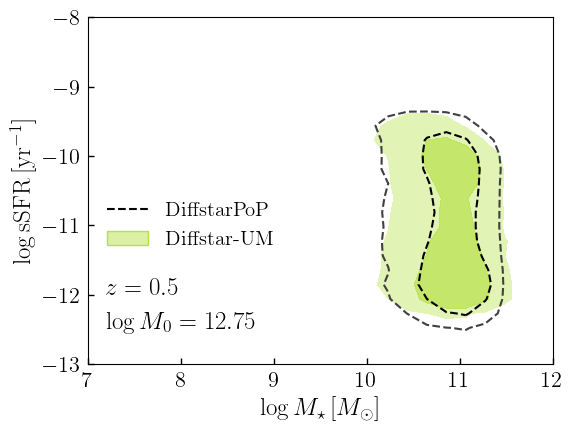

43661
time i 12.867204189300537
12.781818181818181 0.4967190594981553
10.87
10.87


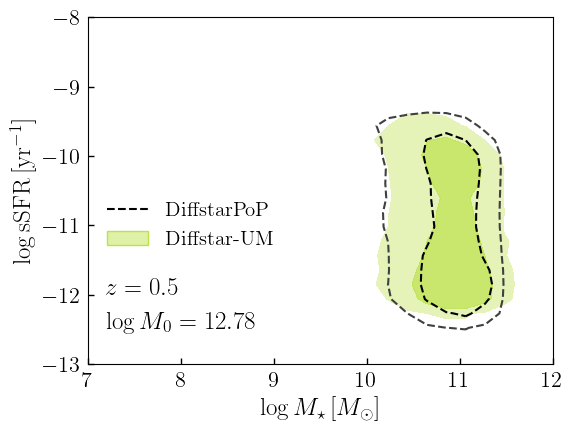

41120
time i 12.50508189201355
12.809090909090909 0.4967190594981553
10.87
10.87


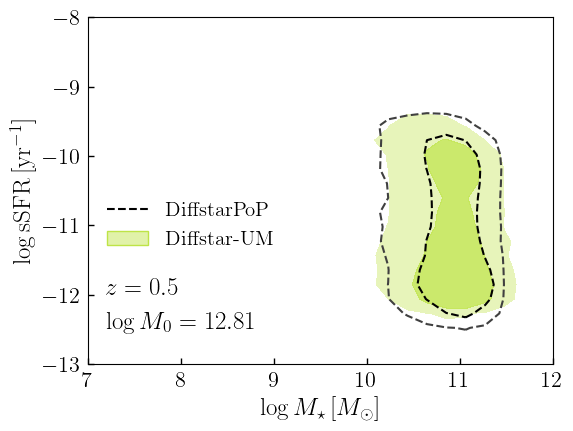

38724
time i 12.290266990661621
12.836363636363636 0.4967190594981553
10.88
10.88


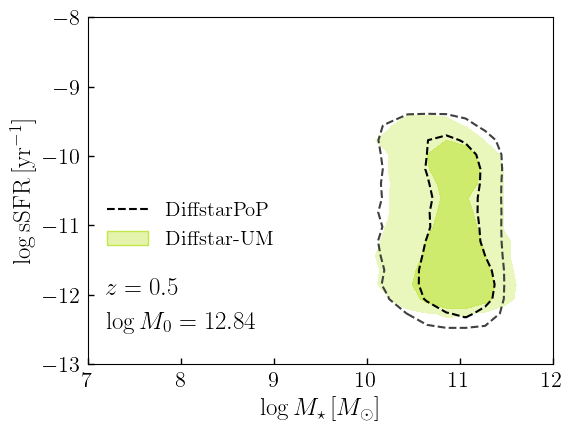

36427
time i 11.577107906341553
12.863636363636363 0.4967190594981553
10.88
10.88


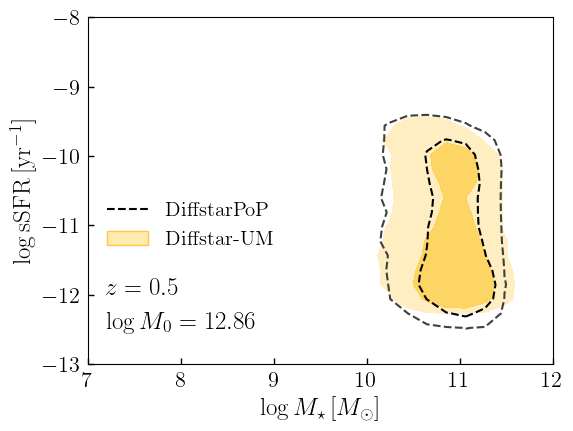

34247
time i 11.293275833129883
12.89090909090909 0.4967190594981553
10.89
10.88


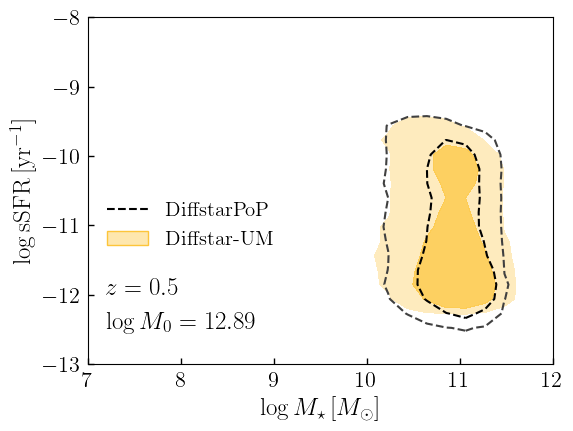

32417
time i 12.009929895401001
12.918181818181818 0.4967190594981553
10.89
10.88


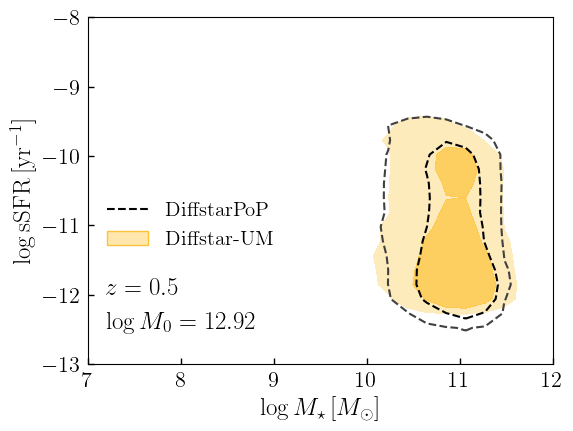

30552
time i 11.039798021316528
12.945454545454545 0.4967190594981553
10.89
10.88


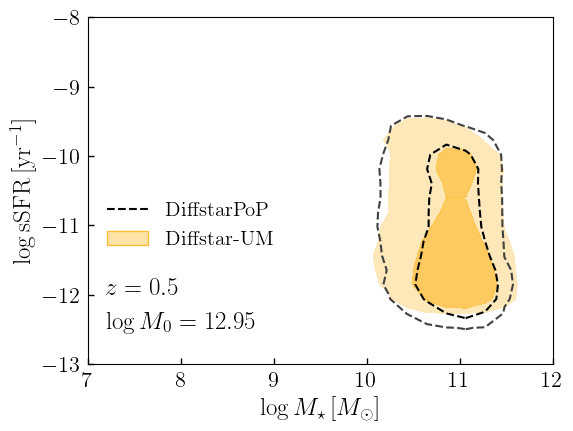

28826
time i 10.918575048446655
12.972727272727273 0.4967190594981553
10.9
10.89


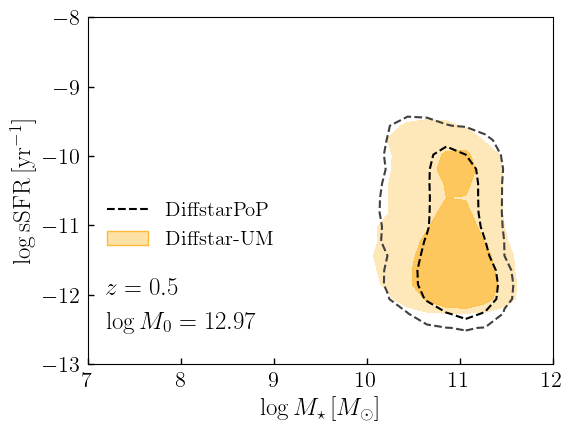

27108
time i 10.663730144500732
13.0 0.4967190594981553
10.9
10.89


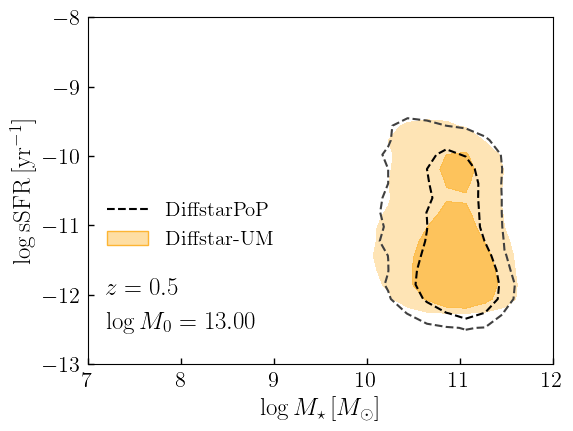

25560
time i 10.485335111618042
13.027272727272727 0.4967190594981553
10.9
10.89


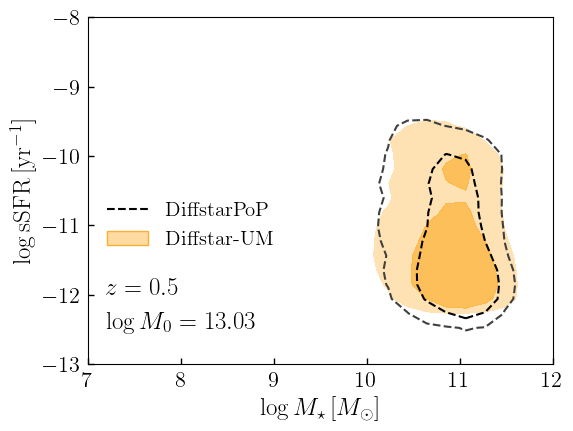

24055
time i 11.27814793586731
13.054545454545455 0.4967190594981553
10.9
10.89


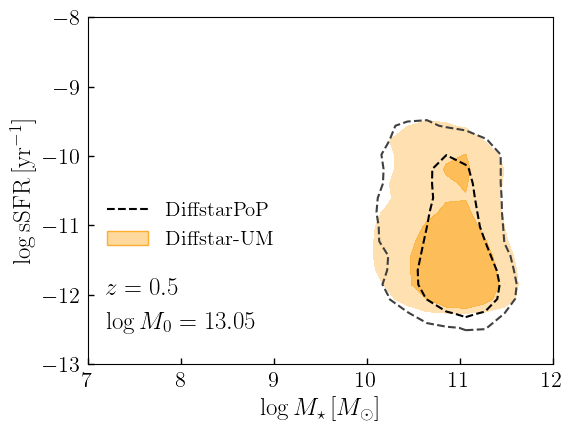

22689
time i 11.392222881317139
13.081818181818182 0.4967190594981553
10.9
10.89


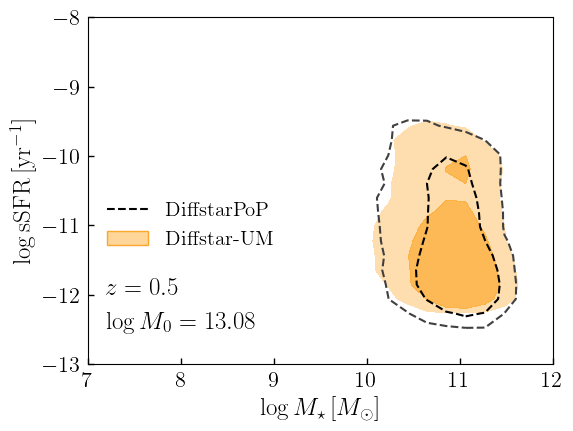

21194
time i 10.507757186889648
13.10909090909091 0.4967190594981553
10.9
10.89


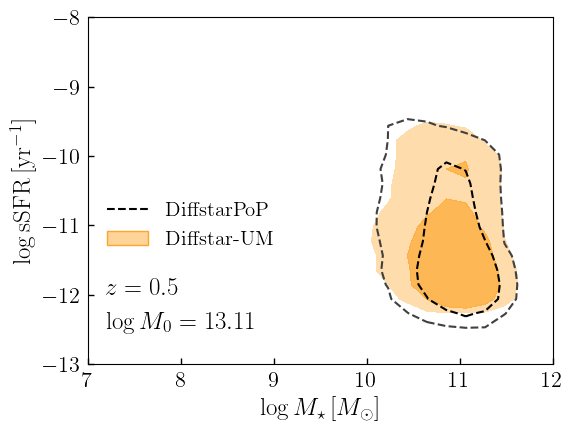

19899
time i 10.17052698135376
13.136363636363637 0.4967190594981553
10.9
10.88


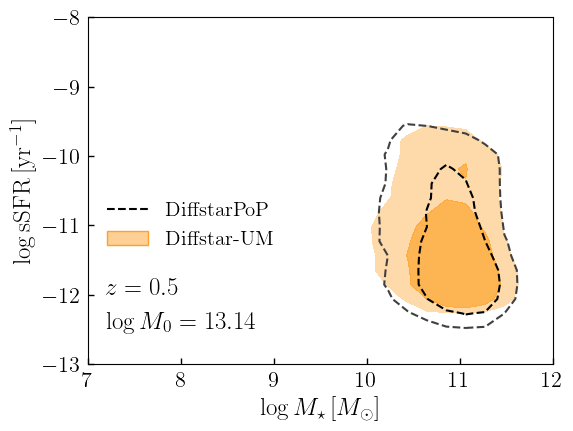

18688
time i 10.13267707824707
13.163636363636364 0.4967190594981553
10.9
10.88


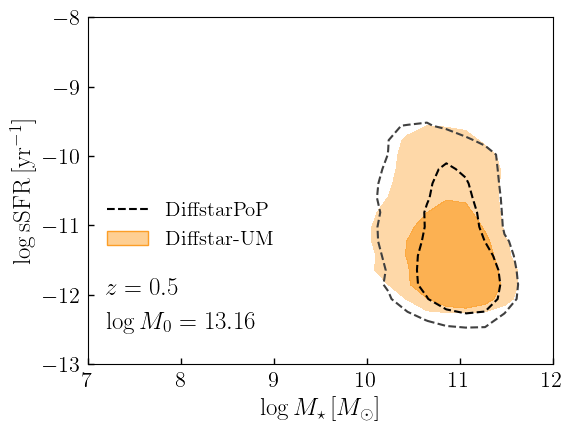

17459
time i 10.178691864013672
13.190909090909091 0.4967190594981553
10.9
10.88


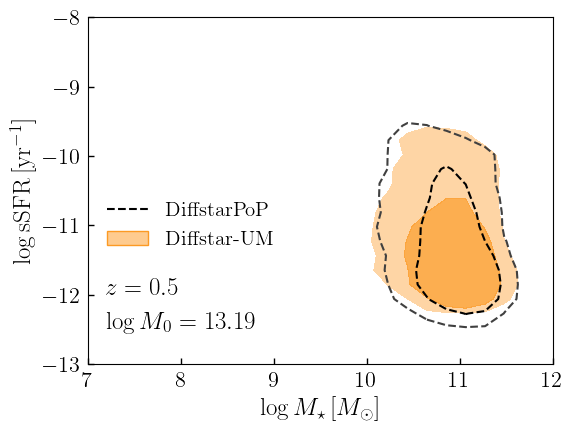

16248
time i 10.48084807395935
13.218181818181817 0.4967190594981553
10.89
10.88


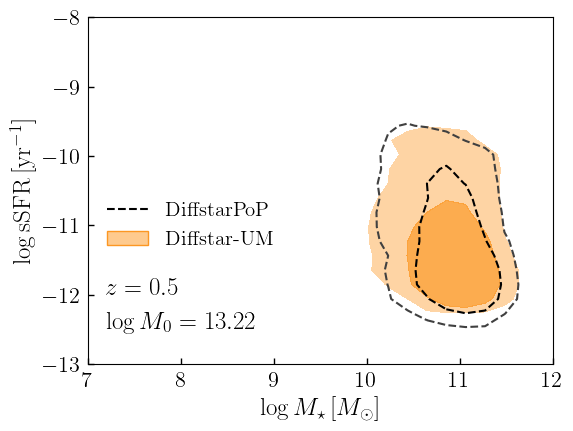

15312
time i 10.775583982467651
13.245454545454544 0.4967190594981553
10.9
10.87


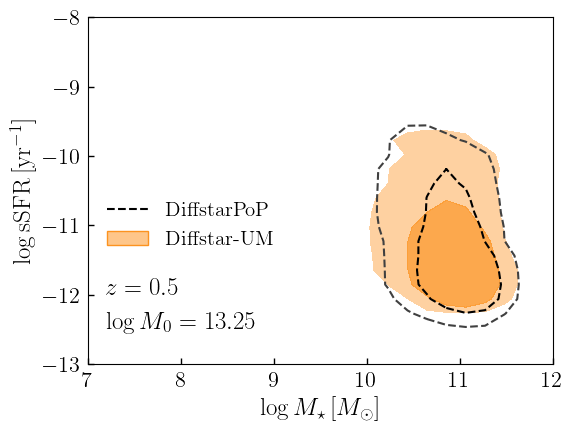

14395
time i 10.798373937606812
13.272727272727272 0.4967190594981553
10.89
10.87


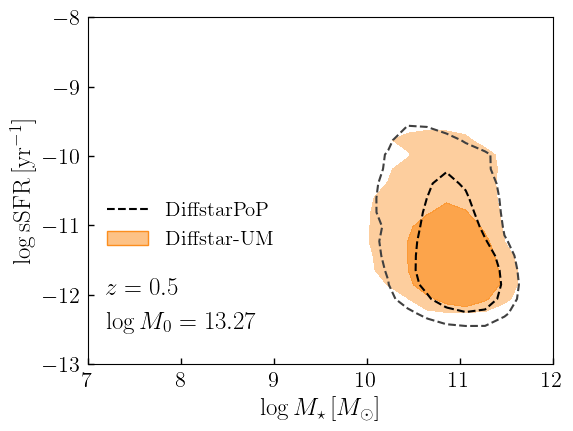

13598
time i 10.87469220161438
13.299999999999999 0.4967190594981553
10.89
10.87


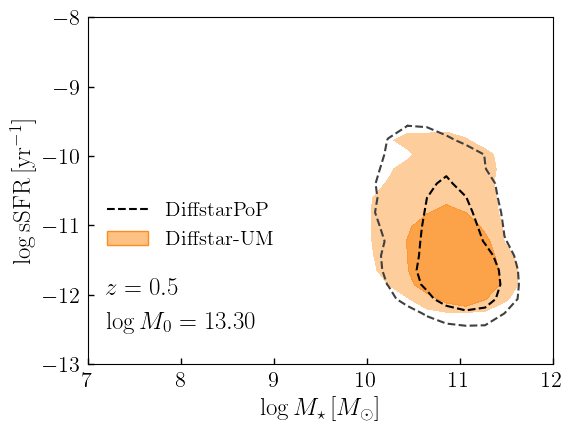

12790
time i 10.845248937606812
13.327272727272726 0.4967190594981553
10.89
10.87


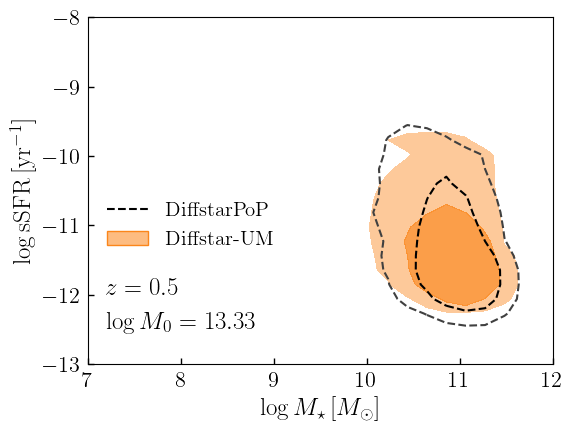

11957
time i 9.77621603012085
13.354545454545454 0.4967190594981553
10.89
10.87


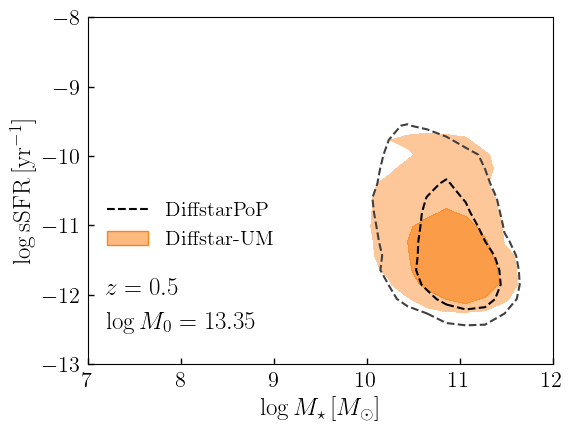

11271
time i 10.70137906074524
13.381818181818181 0.4967190594981553
10.88
10.86


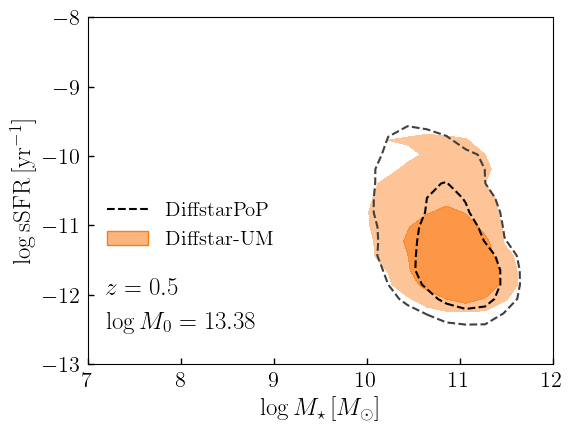

10558
time i 9.718472003936768
13.409090909090908 0.4967190594981553
10.88
10.86


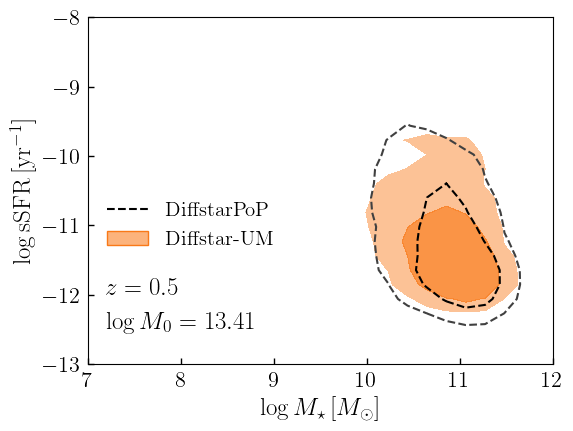

9841
time i 9.715244054794312
13.436363636363636 0.4967190594981553
10.88
10.86


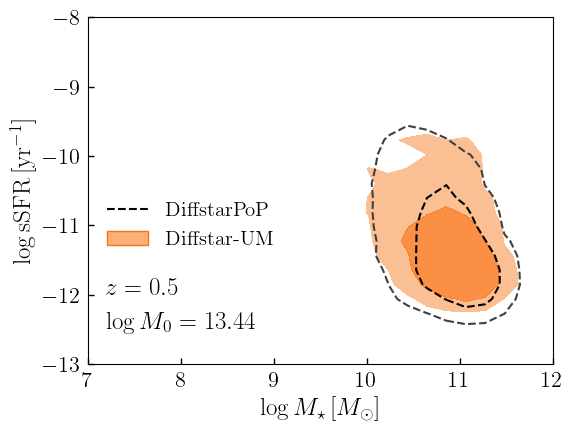

9226
time i 10.198269844055176
13.463636363636363 0.4967190594981553
10.87
10.85


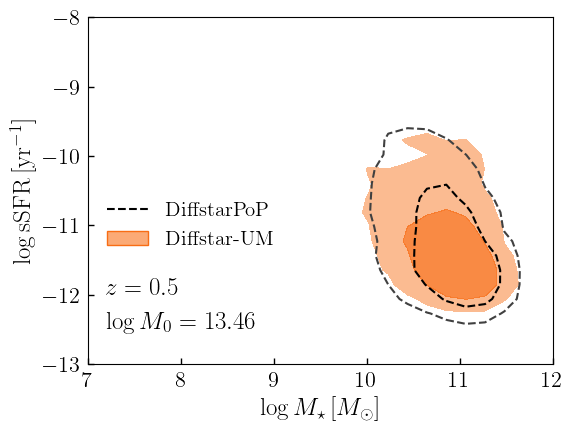

8641
time i 9.972300052642822
13.49090909090909 0.4967190594981553
10.87
10.85


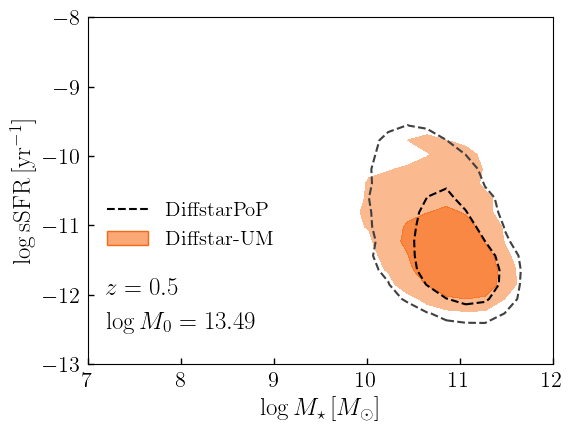

8103
time i 9.81449007987976
13.518181818181818 0.4967190594981553
10.86
10.84


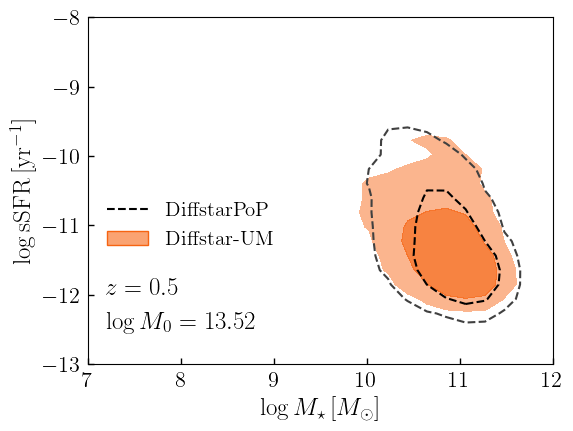

7539
time i 9.530484914779663
13.545454545454545 0.4967190594981553
10.86
10.84


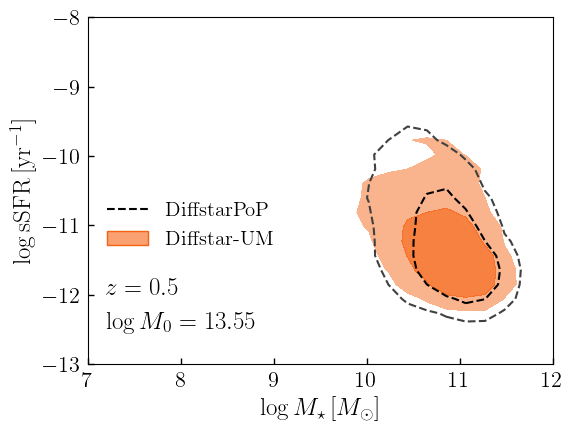

7019
time i 10.178537130355835
13.572727272727272 0.4967190594981553
10.86
10.84


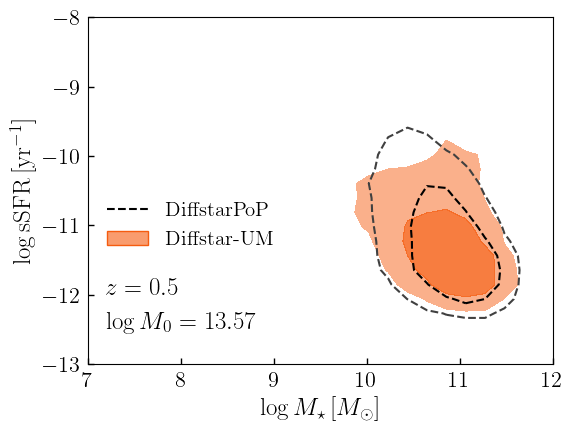

6560
time i 8.592517852783203
13.6 0.4967190594981553
10.85
10.84


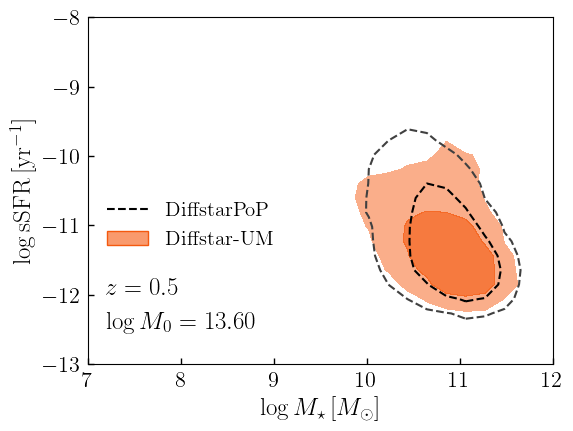

6131
time i 9.92769718170166
13.627272727272727 0.4967190594981553
10.85
10.83


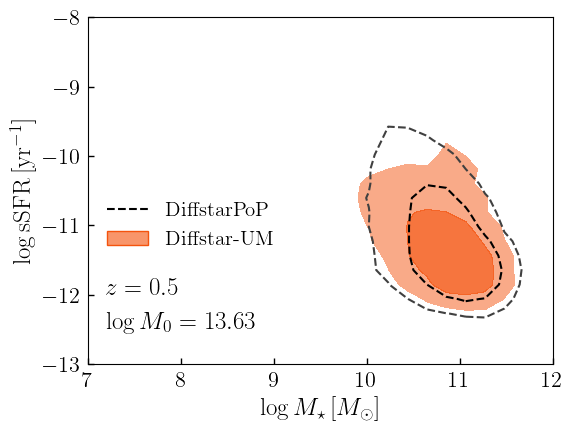

5698
time i 9.643339157104492
13.654545454545454 0.4967190594981553
10.84
10.83


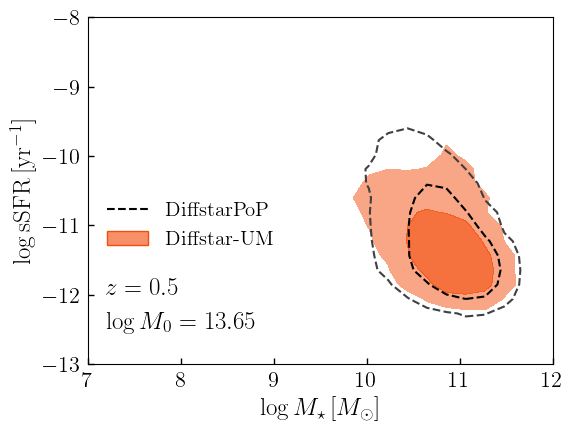

5313
time i 9.505965948104858
13.681818181818182 0.4967190594981553
10.84
10.83


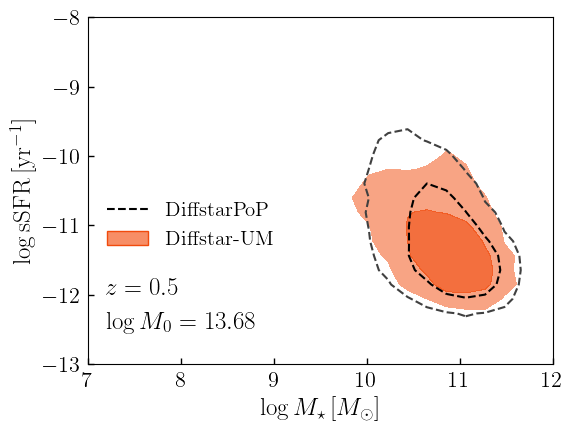

4966
time i 9.503652811050415
13.709090909090909 0.4967190594981553
10.83
10.82


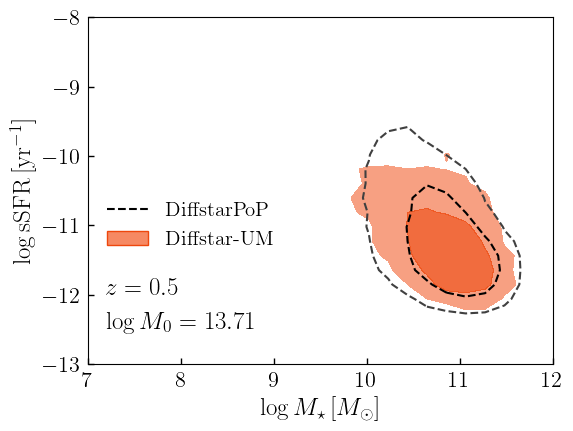

4615
time i 9.554726839065552
13.736363636363636 0.4967190594981553
10.82
10.82


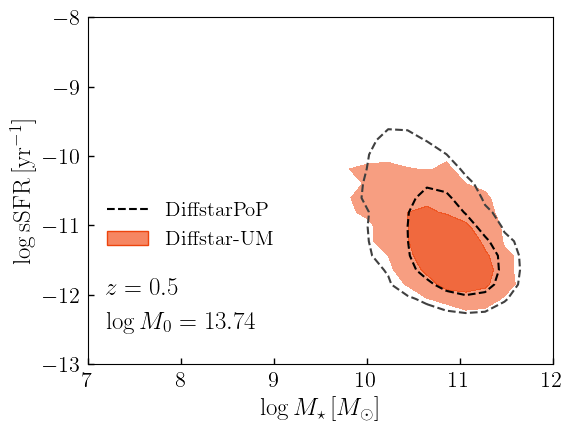

4329
time i 9.889158010482788
13.763636363636362 0.4967190594981553
10.82
10.82


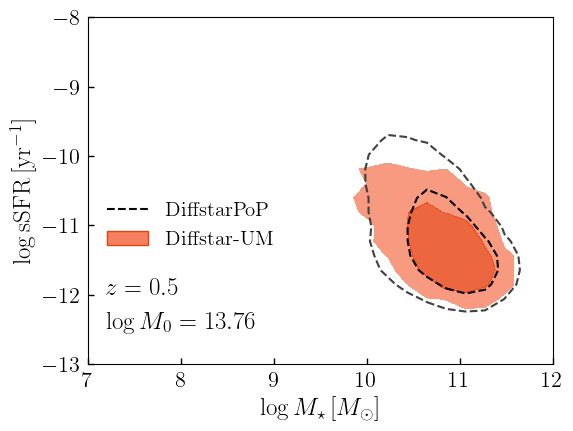

4033
time i 9.859128952026367
13.79090909090909 0.4967190594981553
10.82
10.81


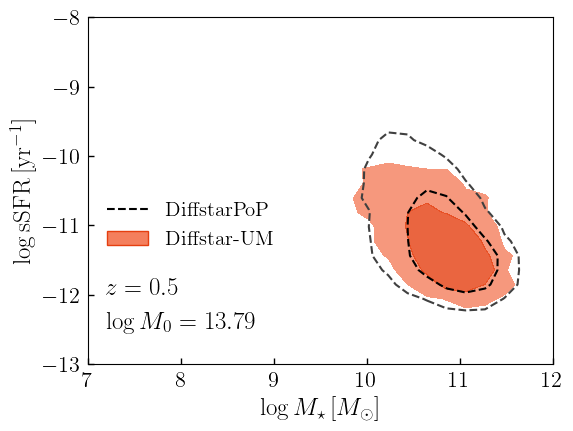

3769
time i 9.309643030166626
13.818181818181817 0.4967190594981553
10.81
10.81


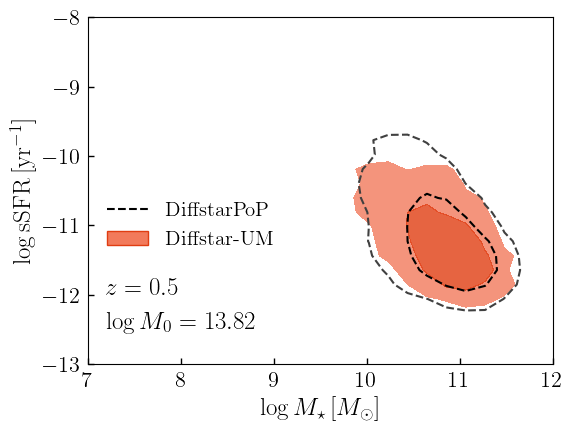

3556
time i 9.340018272399902
13.845454545454544 0.4967190594981553
10.81
10.81


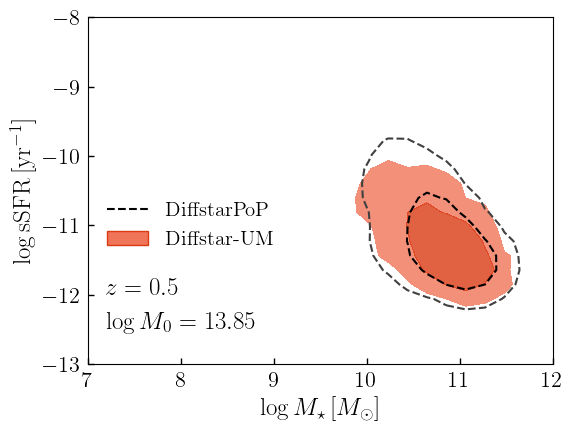

3282
time i 9.380407810211182
13.872727272727271 0.4967190594981553
10.8
10.81


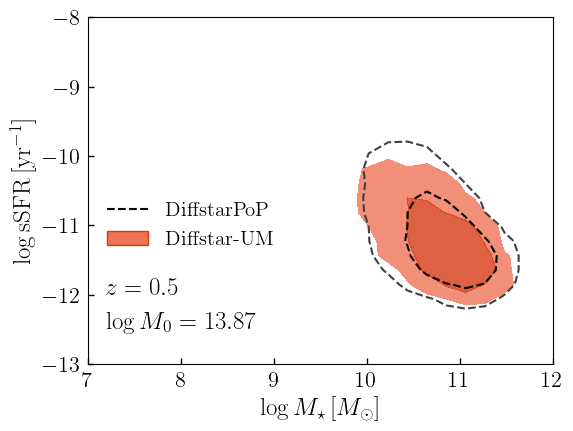

3069
time i 9.356403112411499
13.899999999999999 0.4967190594981553
10.8
10.81


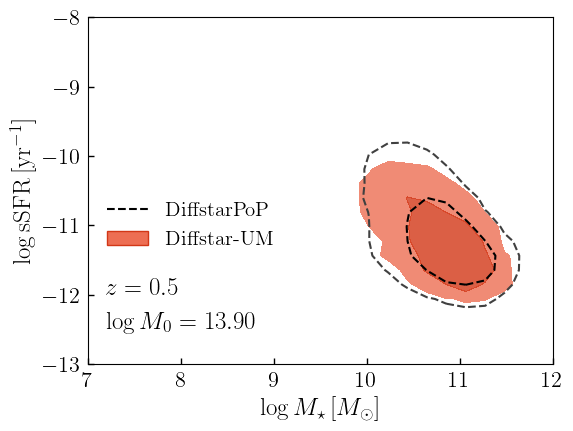

2832
time i 9.321534872055054
13.927272727272726 0.4967190594981553
10.79
10.81


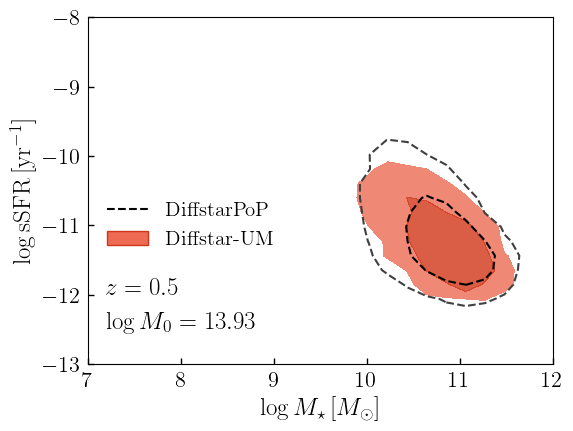

2616
time i 9.79907512664795
13.954545454545453 0.4967190594981553
10.79
10.81


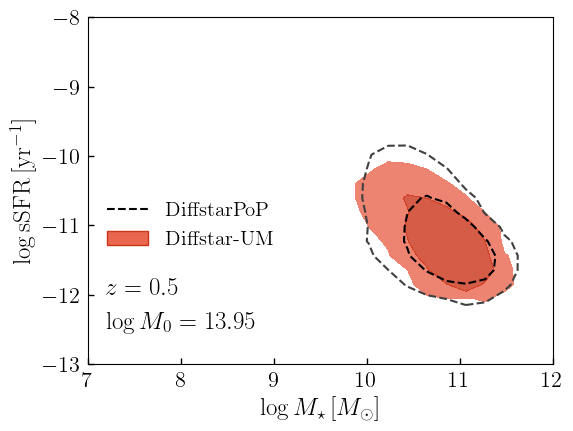

2450
time i 9.35860013961792
13.98181818181818 0.4967190594981553
10.78
10.8


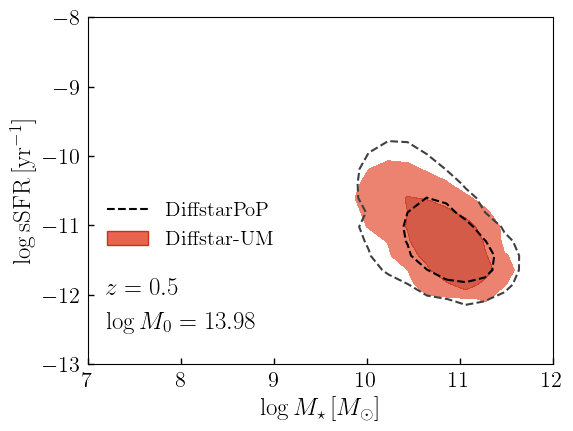

2254
time i 9.32729697227478
14.009090909090908 0.4967190594981553
10.78
10.81


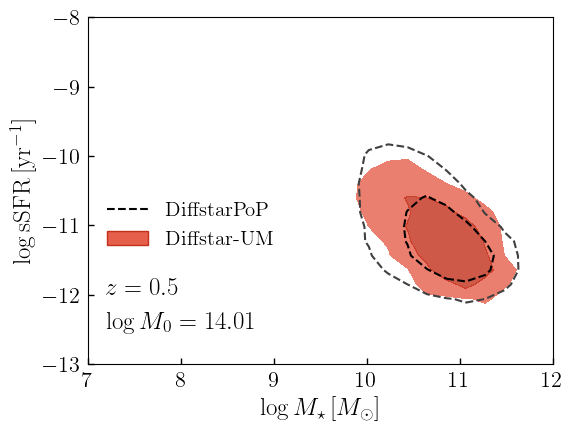

2077
time i 9.261841058731079
14.036363636363635 0.4967190594981553
10.77
10.8


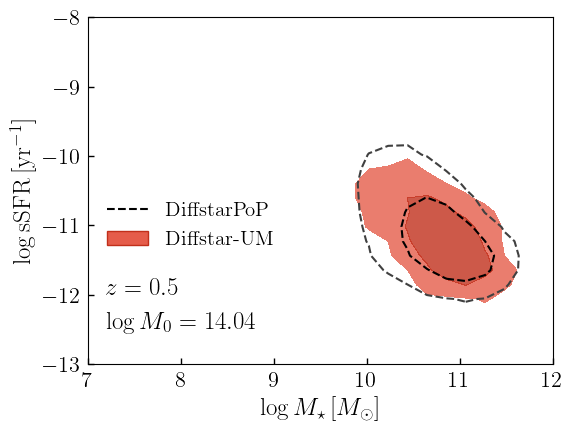

1909
time i 9.533841133117676
14.063636363636363 0.4967190594981553
10.76
10.79


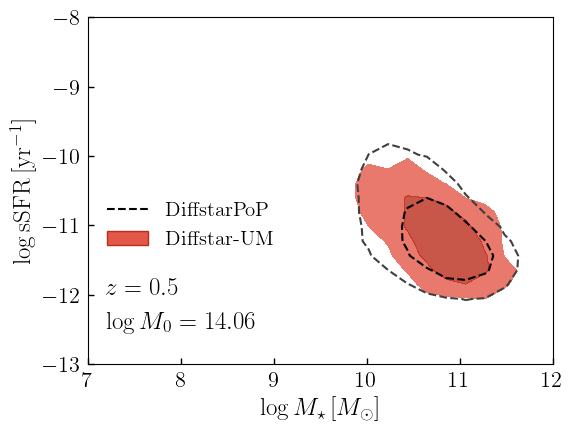

1738
time i 9.2968270778656
14.09090909090909 0.4967190594981553
10.76
10.78


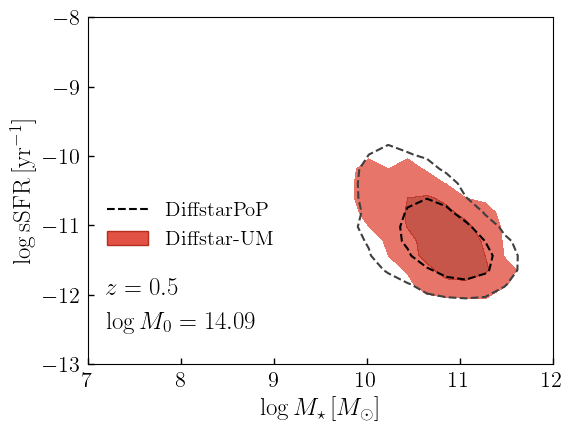

1618
time i 9.725462913513184
14.118181818181817 0.4967190594981553
10.76
10.78


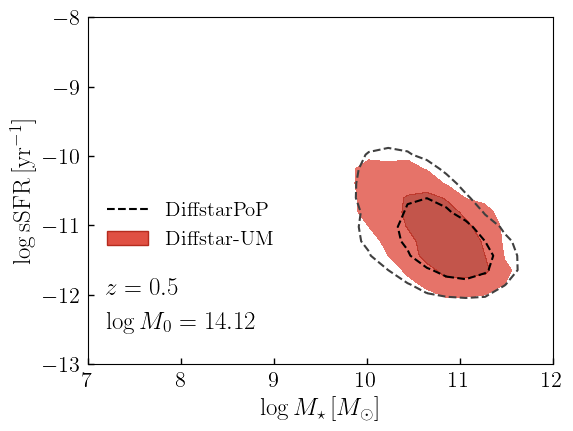

1472
time i 8.260836124420166
14.145454545454545 0.4967190594981553
10.75
10.77


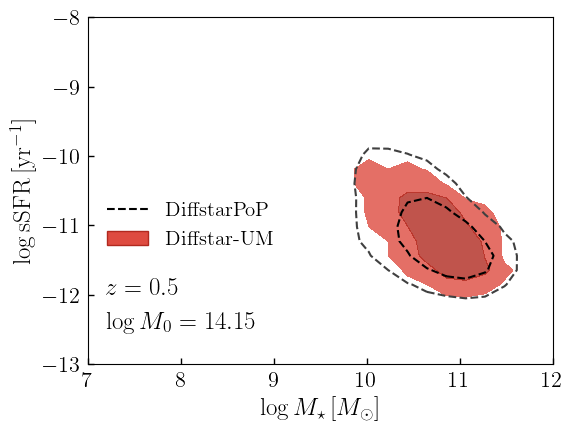

1336
time i 8.235298156738281
14.172727272727272 0.4967190594981553
10.74
10.77


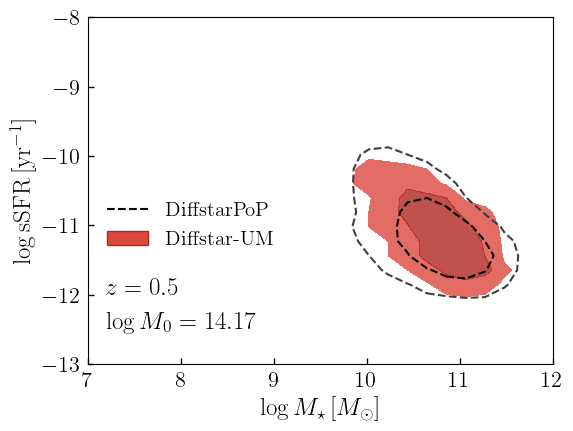

1177
time i 8.424548864364624
14.2 0.4967190594981553
10.74
10.77


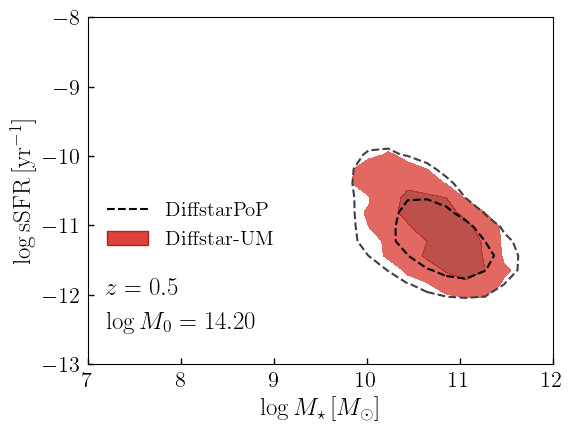

In [23]:
logm0_binmids = np.linspace(11.5, 14.2, 100)
logm0_bin_widths = np.ones_like(logm0_binmids) * 0.1


normal_values = (mah_params_arr[:, 4] < 4.5)
normal_values &= (mah_params_arr[:, 2] < 2.0)


colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']
colors_test = plt.get_cmap("Greys")(np.linspace(0.3,0.7, 3))
colors_greys = plt.get_cmap("Greys")(np.array([0.8, 1.0]))
n_histories = int(5e4)
ran_key = jran.PRNGKey(0)

nbins_x = np.linspace(7, 12, 25)
nbins_y = np.linspace(-13, -8.0, 25)
        
# nbins_x = bins_mstar.copy()
# nbins_y = bins_ssfr.copy()

Nhalos = int(1e4)

smooth = False
# for i, bin_id in enumerate(_bins):
for i, bin_id in enumerate(range(len(logm0_binmids))):

    t_table = np.linspace(1.0, TODAY, 100)
    lgt = jnp.log10(t_table)
    z_table = np.array([z_at_value(Planck13.age, x * u.Gyr, zmin=-1) for x in t_table])
    
    _sel = (logmpeak > logm0_binmids[i] - logm0_bin_widths[i]) & (logmpeak < logm0_binmids[i] + logm0_bin_widths[i])
    _sel &= normal_values
    print(_sel.sum())
    sel = np.random.choice(np.arange(len(p50_arr))[_sel], Nhalos, replace=True)
    _halo_data_MC = mah_params_arr[sel]
    _p50 = p50_arr[sel]

    t0 = time.time()
    histories = draw_sfh_MIX(
        t_table,
        logm0_binmids[bin_id],
        _halo_data_MC[:, np.array([1,2,4,5])],
        _p50,
        n_histories,
        ran_key,
        index_select,
        index_high,
        fstar_tdelay,
        #init_guess[0:N_PDF_Q],
        #init_guess[N_PDF_Q:N_PDF_Q+N_PDF_MS],
        #init_guess[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
        #init_guess[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
        outputs[0][0:N_PDF_Q],
        outputs[0][N_PDF_Q:N_PDF_Q+N_PDF_MS],
        outputs[0][N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
        outputs[0][N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
    )

    weights = histories[4].copy()
    _params = np.zeros((Nhalos, 6))
    _params[:, 0] = np.log10(TODAY)
    _params[:, 1:3] = _halo_data_MC[:, 0:2]
    _params[:, 3] = 3.5
    _params[:, 4:6] = _halo_data_MC[:, 2:4]

    mah_histories = _calc_halo_history_vmap(lgt, *_params.T)

    _mask = (logmpeak > logm0_binmids[bin_id] - logm0_bin_widths[bin_id]) 
    _mask &= (logmpeak < logm0_binmids[bin_id] + logm0_bin_widths[bin_id])
    mah_histories_SMDPL = _calc_halo_history_vmap(lgt, *mah_params_arr[_mask].T)

    histories_SMDPL = sm_sfr_history_diffstar_scan_XsfhXmah_vmap(
        t_table,
        jnp.log10(t_table),
        _get_dt_array(t_table),
        mah_params_arr[_mask][:, np.array([1,2,4,5])],
        u_fit_params_arr[_mask][:,np.array([0,1,2,4])],
        u_fit_params_arr[_mask][:,5:9],
        index_select,
        index_high,
        fstar_tdelay,
    )
    t1 = time.time()
    print("time i", t1-t0)

    t_id = np.argmin(abs(z_table - 0.5))

    # for j, t_id in enumerate(t_sel_hists[::-1]):

    # j = 0
    # t_id = _ids[j]
    print(logm0_binmids[bin_id], z_table[t_id])

    _fact = 1.5
    fig, ax = plt.subplots(1, 1, figsize=(4*_fact,3*_fact))

    xdata = np.log10(histories[0][:, t_id])
    print(np.round(np.average(xdata, weights=np.array(weights)),2))
    ydata = np.log10(histories[1][:, t_id] / histories[0][:, t_id])

    density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, weights=weights, level=0.68, linestyles=['--'], colors=[colors_greys[1]])
    density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, weights=weights, level=0.95, linestyles=['--'], colors=[colors_greys[0]])

    xdata = np.log10(histories_SMDPL[0][:, t_id])
    ydata = np.log10(histories_SMDPL[1][:, t_id] / histories_SMDPL[0][:, t_id])
    print(np.round(np.mean(xdata),2))
    # density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, level=0.68, linestyles=['--'], colors=[colors[4]])
    # density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, level=0.95, linestyles=['--'], colors=[colors[4]])
    # density_contourf(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, levels=[0.68, 0.95], linestyles=['--'], colors=[colors[4]])
    # colors_ = plt.get_cmap("RdYlGn")(np.linspace(0.0,1.0, 10))
    colors_ = np.concatenate((
        np.array(plt.get_cmap("RdYlGn")(np.linspace(0.1,0.4, int(len(logm0_binmids)/2)))),
        np.array(plt.get_cmap("RdYlGn")(np.linspace(0.6, 0.9, int(len(logm0_binmids)/2)))),
    ))[::-1]
    colors_ = [
        adjust_lightness(colors_[i], amount=1.1),
        adjust_lightness(colors_[i], amount=0.8),
        # colors_[j],
    ]
    density_contourf(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, levels=[0.0, .68, 0.95], colors=colors_, alpha=0.8)

    ax.text(7.2, -12.5, r"$\log M_0 = %.2f$"%logm0_binmids[bin_id], fontsize=18)
    ax.text(7.2, -12.5+0.5, r"$z = %.1f$"%abs(z_table[t_id]), fontsize=18)
    ax.set_xlabel(r'$\log M_\star\,[M_\odot]$')
    ax.set_ylabel(r'$\log \rm{sSFR}\,[\rm{yr}^{-1}]$')
    ax.set_xticks(np.arange(7,12.1,1))
    ax.set_yticks(np.arange(-13,-7.9,1))

    fig.subplots_adjust(wspace=0.4, hspace=0.3)

    legend_elements = [
        Line2D([0], [0], color='k', ls='--', label=r'DiffstarPoP'),
        Patch(facecolor=colors_[0], edgecolor=colors_[1], label=r'Diffstar-UM')
    ]
    ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(0.,0.4))
    fig.savefig("mstar_ssfr_plots/mstar_vs_ssfr_diffstarpop_smdpl_z%.2f_m0evol%d.png"%(z_table[t_id], bin_id), bbox_inches="tight", dpi=300)
    plt.show()
    #break

In [148]:
_halo_data_MC.shape

(10000, 6)

Text(0, 0.5, '$\\log \\rm{sSFR}\\,[\\rm{yr}^{-1}]$')

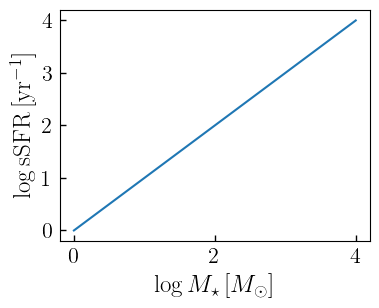

In [142]:
plt.plot(np.arange(5))
plt.xlabel(r'$\log M_\star\,[M_\odot]$')
plt.ylabel(r'$\log \rm{sSFR}\,[\rm{yr}^{-1}]$')           

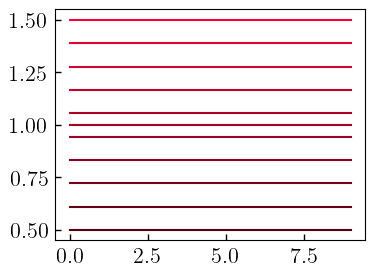

[(0.0, 0.4894117647058823, 0.25882352941176473), array([0.        , 0.40784314, 0.21568627, 1.        ])]


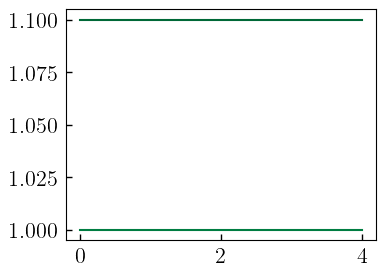

[(0.15741637831603217, 0.7323644752018454, 0.38523644752018454), array([0.13118032, 0.61030373, 0.32103037, 1.        ])]


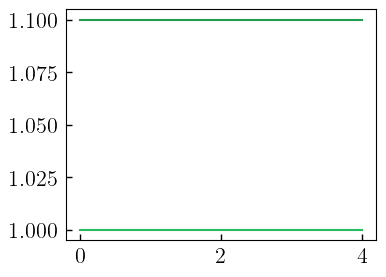

[(0.6001916506775558, 0.8277525385998796, 0.5598368500967756), array([0.44921184, 0.76270665, 0.39361784, 1.        ])]


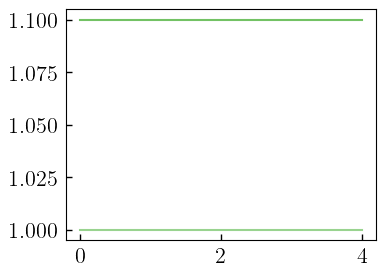

[(0.8319274587305279, 0.9284135472370767, 0.677860962566845), array([0.71764706, 0.87973856, 0.45882353, 1.        ])]


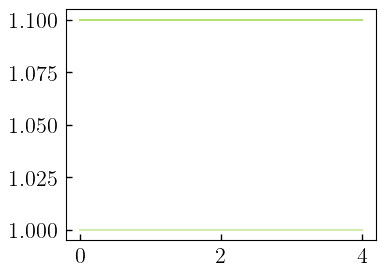

[(0.9825024341287316, 0.9926326038436764, 0.924230141254363), array([0.91526336, 0.96432141, 0.63306421, 1.        ])]


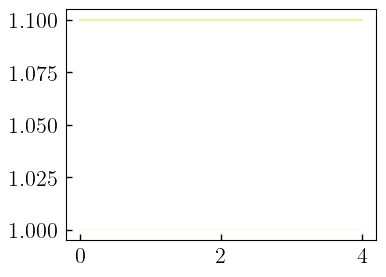

[(0.9997402694123462, 0.9919483517827289, 0.9572608839901912), array([0.99777009, 0.93087274, 0.63306421, 1.        ])]


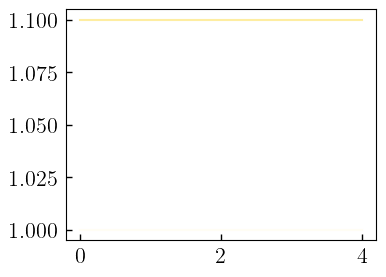

[(0.9967335217839998, 0.8739139408623859, 0.7177762821375685), array([0.99346405, 0.74771242, 0.43529412, 1.        ])]


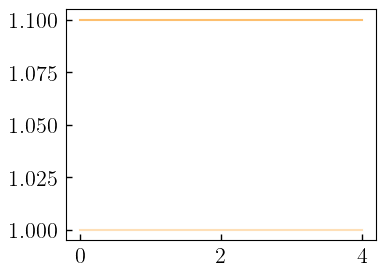

[(0.9758450490736792, 0.6514712388635315, 0.5236705218605768), array([0.96378316, 0.47743176, 0.28581315, 1.        ])]


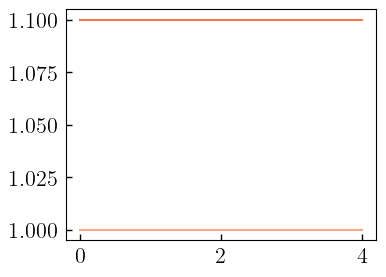

[(0.8844973974611055, 0.3751278727025086, 0.33709429804062463), array([0.85428681, 0.21168781, 0.16370627, 1.        ])]


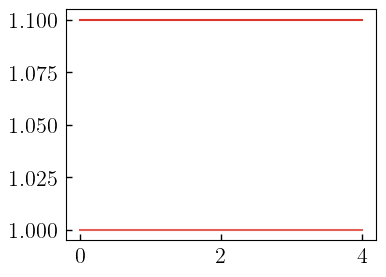

[(0.7764705882352941, 0.0, 0.17882352941176433), array([0.64705882, 0.        , 0.14901961, 1.        ])]


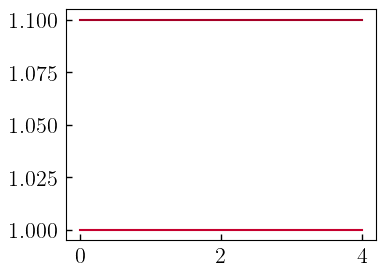

In [123]:
colors_ = np.array(plt.get_cmap("RdYlGn")(np.linspace(0.0,1.0, len(_ids)))[::-1])

for j, t_id in enumerate(_ids):

    colors_2 = [
        adjust_lightness(colors_[j], amount=1.2),
        colors_[j],
    ]
    print(colors_2)
    plt.plot(np.ones(5), color=colors_2[0])
    plt.plot(np.ones(5)*1.1, color=colors_2[1])
    plt.show()
    

In [83]:
colors_[:,0]

array([0.64705882, 0.85428681, 0.96378316, 0.99346405, 0.99777009,
       0.91526336, 0.71764706, 0.44921184, 0.13118032, 0.        ])